<a href="https://colab.research.google.com/github/sun9huni/first-repository/blob/main/0603_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [3]:
playground_series_s4e11_path = kagglehub.competition_download('playground-series-s4e11')

print('Data source import complete.')

100%|██████████| 4.55M/4.55M [00:00<00:00, 79.1MB/s]

Extracting files...


Data source import complete.


In [4]:
!pip install squarify
!pip install category-encoders
!pip install catboost

# Core Libraries
import pandas as pd
import numpy as np
from scipy import stats
import random
import warnings

# Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import squarify
%matplotlib inline

# Machine Learning Libraries
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, HistGradientBoostingClassifier

# Set random seed
rs = 1004

# Ignore warnings
warnings.filterwarnings("ignore")

# Set color palette for Seaborn
colors= ['#1c76b6', '#a7dae9', '#eb6a20', '#f59d3d', '#677fa0', '#d6e4ed', '#f7e9e5']
sns.set_palette(colors)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.4 MB/s eta 0:00:00


In [95]:
# Read the train and test datasets using the downloaded path
df_train = pd.read_csv(f"{playground_series_s4e11_path}/train.csv")
df_test = pd.read_csv(f"{playground_series_s4e11_path}/test.csv")

print("First 5 rows of our dataset:")
df_train.head()

First 5 rows of our dataset:


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


--- 학생 수가 100명 넘는 도시별 통계 ---
             City  Total_Count  Student_Count  Student_Ratio
17      Hyderabad         4496           1340       0.298043
10       Srinagar         5074           1372       0.270398
21        Lucknow         4280           1155       0.269860
27         Bhopal         3475            934       0.268777
20          Thane         4289           1139       0.265563
19         Jaipur         4328           1036       0.239372
0          Kalyan         6591           1570       0.238204
13           Agra         4684           1094       0.233561
14          Surat         4636           1078       0.232528
2     Vasai-Virar         5765           1290       0.223764
24        Chennai         4044            885       0.218843
26          Delhi         3593            768       0.213749
6        Ludhiana         5226           1111       0.212591
25      Ghaziabad         3620            745       0.205801
3         Kolkata         5689           1066       0.18

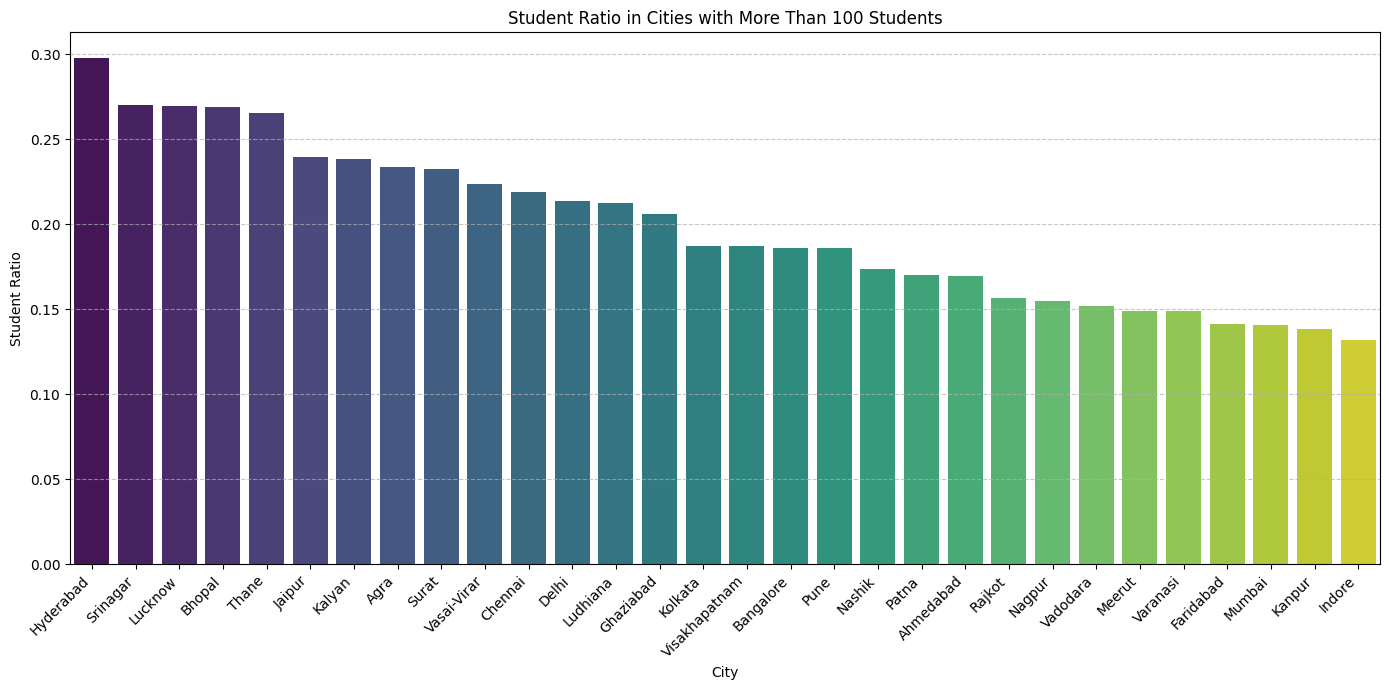

In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# df_train 데이터프레임이 이미 로드되어 있고,
# 'City' 컬럼과 'Working Professional or Student' 컬럼이 포함되어 있다고 가정합니다.

# 1. 도시별 전체 개체 수 계산
city_total_counts = df_train['City'].value_counts().reset_index()
city_total_counts.columns = ['City', 'Total_Count']

# 2. 도시별 학생 수 계산
# 'Working Professional or Student'가 'Student'인 경우만 필터링하여 도시별 카운트 계산
student_counts = df_train[df_train['Working Professional or Student'] == 'Student']['City'].value_counts().reset_index()
student_counts.columns = ['City', 'Student_Count']

# 3. 전체 카운트와 학생 수 카운트 데이터프레임을 도시를 기준으로 병합
city_stats = pd.merge(city_total_counts, student_counts, on='City', how='left')

# 학생 수가 없는 도시는 병합 후 Student_Count가 NaN이 되므로 0으로 채워줍니다.
city_stats['Student_Count'] = city_stats['Student_Count'].fillna(0).astype(int)

# 4. 학생 비율 계산
city_stats['Student_Ratio'] = city_stats['Student_Count'] / city_stats['Total_Count']

# 5. 학생 수가 100명을 넘는 도시만 필터링
filtered_city_stats = city_stats[city_stats['Student_Count'] > 100].sort_values(by='Student_Ratio', ascending=False)


print("--- 학생 수가 100명 넘는 도시별 통계 ---")
print(filtered_city_stats)
print("-" * 30)


# 6. 필터링된 도시의 학생 비율 시각화 (막대 그래프)
if not filtered_city_stats.empty:
    plt.figure(figsize=(14, 7)) # 그래프 크기 설정 (필터링된 도시 수에 따라 조절)
    # 막대 그래프 생성
    sns.barplot(data=filtered_city_stats, x='City', y='Student_Ratio', palette='viridis')

    plt.title('Student Ratio in Cities with More Than 100 Students') # 그래프 제목 설정
    plt.xlabel('City') # x축 레이블 설정
    plt.ylabel('Student Ratio') # y축 레이블 설정
    plt.xticks(rotation=45, ha='right') # 도시 이름이 겹치지 않도록 회전
    plt.grid(axis='y', linestyle='--', alpha=0.7) # y축 그리드 추가
    plt.tight_layout() # 그래프 여백 자동 조절
    plt.show()
else:
    print("학생 수가 100명을 넘는 도시가 없습니다.")

--- 학생 수가 100명 넘는 도시별 학생 비율 및 우울증 비율 ---
             City  Student_Ratio  Student_Count  Depression_Ratio
0          Kalyan       0.238204           1570          0.199666
1           Patna       0.169986           1007          0.163234
2     Vasai-Virar       0.223764           1290          0.197918
3         Kolkata       0.187379           1066          0.173668
4       Ahmedabad       0.169428            951          0.217887
5          Meerut       0.149240            825          0.134045
6        Ludhiana       0.212591           1111          0.192690
7            Pune       0.185797            968          0.161036
8          Rajkot       0.156712            816          0.173228
9   Visakhapatnam       0.187210            969          0.159196
10       Srinagar       0.270398           1372          0.211667
11         Mumbai       0.140757            699          0.131293
12         Indore       0.131979            643          0.160920
13           Agra       0.233561   

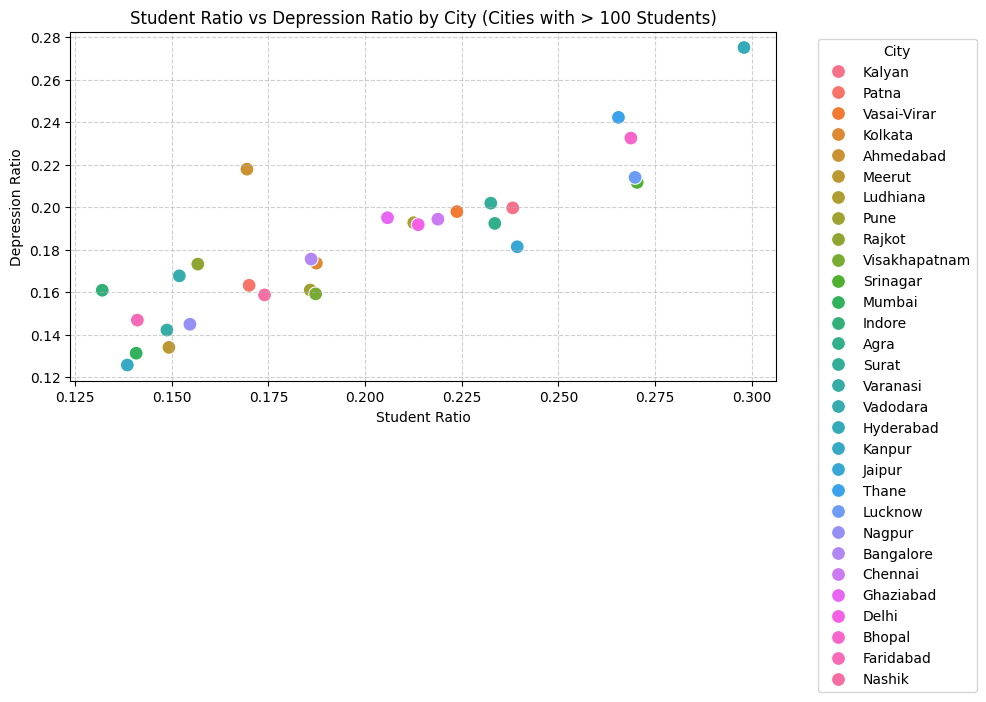

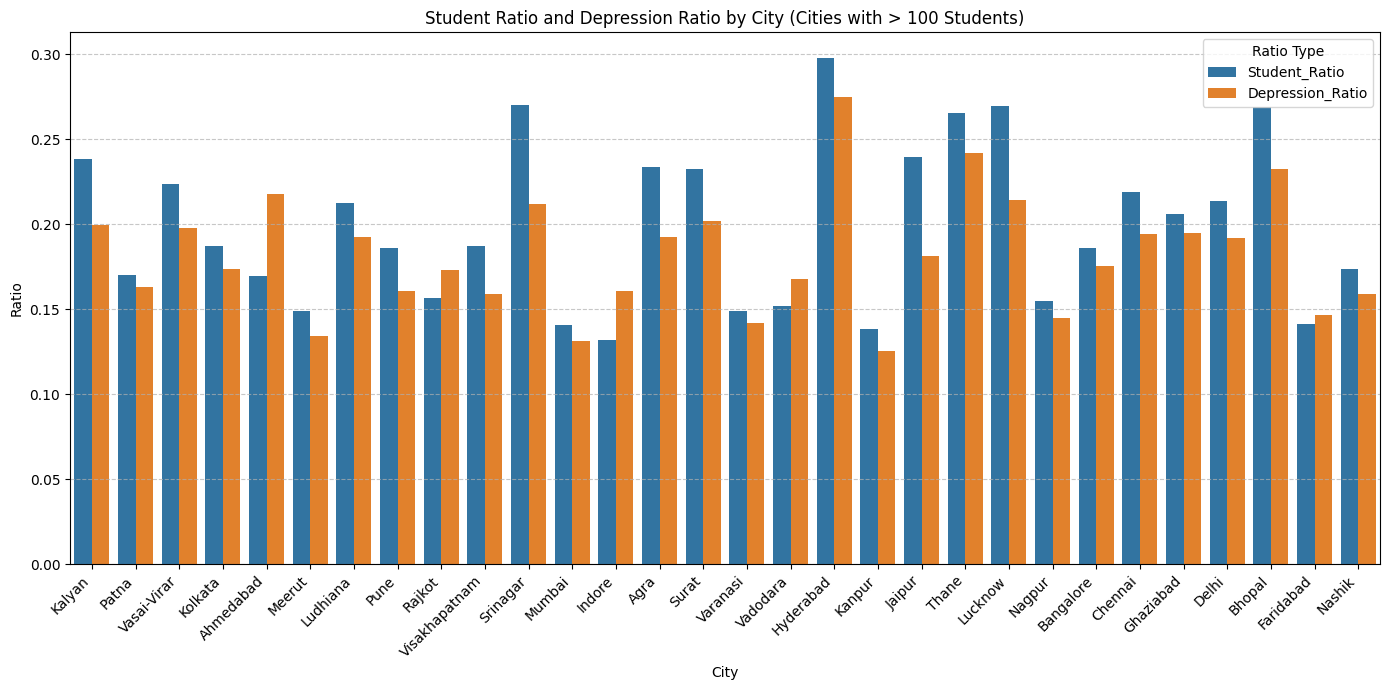

In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# df_train 데이터프레임이 이미 로드되어 있고,
# 'City' 컬럼과 'Depression' 컬럼이 포함되어 있다고 가정합니다.

# 1. 도시별 전체 개체 수 계산 (앞서 계산한 city_total_counts 재사용)
city_total_counts = df_train['City'].value_counts().reset_index()
city_total_counts.columns = ['City', 'Total_Count']

# 2. 도시별 우울증 있는 개체 수 계산
# 'Depression'이 1인 경우만 필터링하여 도시별 카운트 계산
depressed_counts = df_train[df_train['Depression'] == 1]['City'].value_counts().reset_index()
depressed_counts.columns = ['City', 'Depressed_Count']

# 3. 도시별 전체 통계와 우울증 통계 병합
city_depression_stats = pd.merge(city_total_counts, depressed_counts, on='City', how='left')

# 우울증 있는 개체가 없는 도시는 병합 후 Depressed_Count가 NaN이 되므로 0으로 채워줍니다.
city_depression_stats['Depressed_Count'] = city_depression_stats['Depressed_Count'].fillna(0).astype(int)

# 4. 도시별 우울증 비율 계산
city_depression_stats['Depression_Ratio'] = city_depression_stats['Depressed_Count'] / city_depression_stats['Total_Count']

# 5. 기존에 계산한 도시별 학생 비율 데이터와 병합
# 앞서 "학생 수가 100명 넘는 도시별 학생 비율 시각화" 코드에서 계산한 city_stats DataFrame이 있다고 가정합니다.
# 만약 city_stats DataFrame이 없다면, 해당 코드를 먼저 실행하여 city_stats를 생성해야 합니다.
# 여기서는 city_stats DataFrame에 이미 'City', 'Total_Count', 'Student_Count', 'Student_Ratio' 컬럼이 있다고 가정합니다.

# 필요한 컬럼만 선택하여 병합
# city_stats는 전체 도시 정보를 포함하고 있으므로, 전체 도시를 기준으로 병합합니다.
# 학생 비율이 100명 넘는 도시 필터링은 시각화 단계에서 수행합니다.
city_combined_stats = pd.merge(city_stats[['City', 'Student_Ratio', 'Student_Count']],
                               city_depression_stats[['City', 'Depression_Ratio']],
                               on='City',
                               how='inner') # 두 데이터 모두에 있는 도시만 선택

# 학생 수가 100명을 넘는 도시만 필터링
filtered_city_combined_stats = city_combined_stats[city_combined_stats['Student_Count'] > 100].copy()

print("--- 학생 수가 100명 넘는 도시별 학생 비율 및 우울증 비율 ---")
print(filtered_city_combined_stats)
print("-" * 30)


# 6. 시각화

# 시각화 방법 1: 산점도 (Scatter Plot)
if not filtered_city_combined_stats.empty:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=filtered_city_combined_stats,
                    x='Student_Ratio',
                    y='Depression_Ratio',
                    hue='City', # 도시별로 색상 구분 (도시가 많으면 비효율적일 수 있음)
                    s=100) # 점 크기 설정

    # 도시 이름 표시 (선택 사항, 도시가 많으면 겹칠 수 있음)
    # for i in range(len(filtered_city_combined_stats)):
    #     plt.text(filtered_city_combined_stats['Student_Ratio'].iloc[i] + 0.01,
    #              filtered_city_combined_stats['Depression_Ratio'].iloc[i],
    #              filtered_city_combined_stats['City'].iloc[i],
    #              fontsize=9)

    plt.title('Student Ratio vs Depression Ratio by City (Cities with > 100 Students)')
    plt.xlabel('Student Ratio')
    plt.ylabel('Depression Ratio')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left') # 범례 위치 조정
    plt.tight_layout()
    plt.show()
else:
     print("학생 수가 100명을 넘는 도시가 없습니다.")


# 시각화 방법 2: 결합된 막대 그래프 (Dual Axis Bar Plot 또는 Grouped Bar Plot)
# 두 변수의 스케일이 0-1로 동일하므로 Grouped Bar Plot이 적합합니다.

if not filtered_city_combined_stats.empty:
    # 데이터를 melt하여 seaborn의 barplot으로 그룹화하기 쉽게 만듭니다.
    df_melted = filtered_city_combined_stats.melt(id_vars=['City'],
                                                  value_vars=['Student_Ratio', 'Depression_Ratio'],
                                                  var_name='Ratio_Type',
                                                  value_name='Ratio_Value')

    plt.figure(figsize=(14, 7))
    sns.barplot(data=df_melted,
                x='City',
                y='Ratio_Value',
                hue='Ratio_Type', # 학생 비율 vs 우울증 비율로 그룹화
                palette='tab10') # 다른 색상 팔레트 사용 예시

    plt.title('Student Ratio and Depression Ratio by City (Cities with > 100 Students)')
    plt.xlabel('City')
    plt.ylabel('Ratio')
    plt.xticks(rotation=45, ha='right') # 도시 이름이 겹치지 않도록 회전
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Ratio Type')
    plt.tight_layout()
    plt.show()
else:
    print("학생 수가 100명을 넘는 도시가 없습니다.")

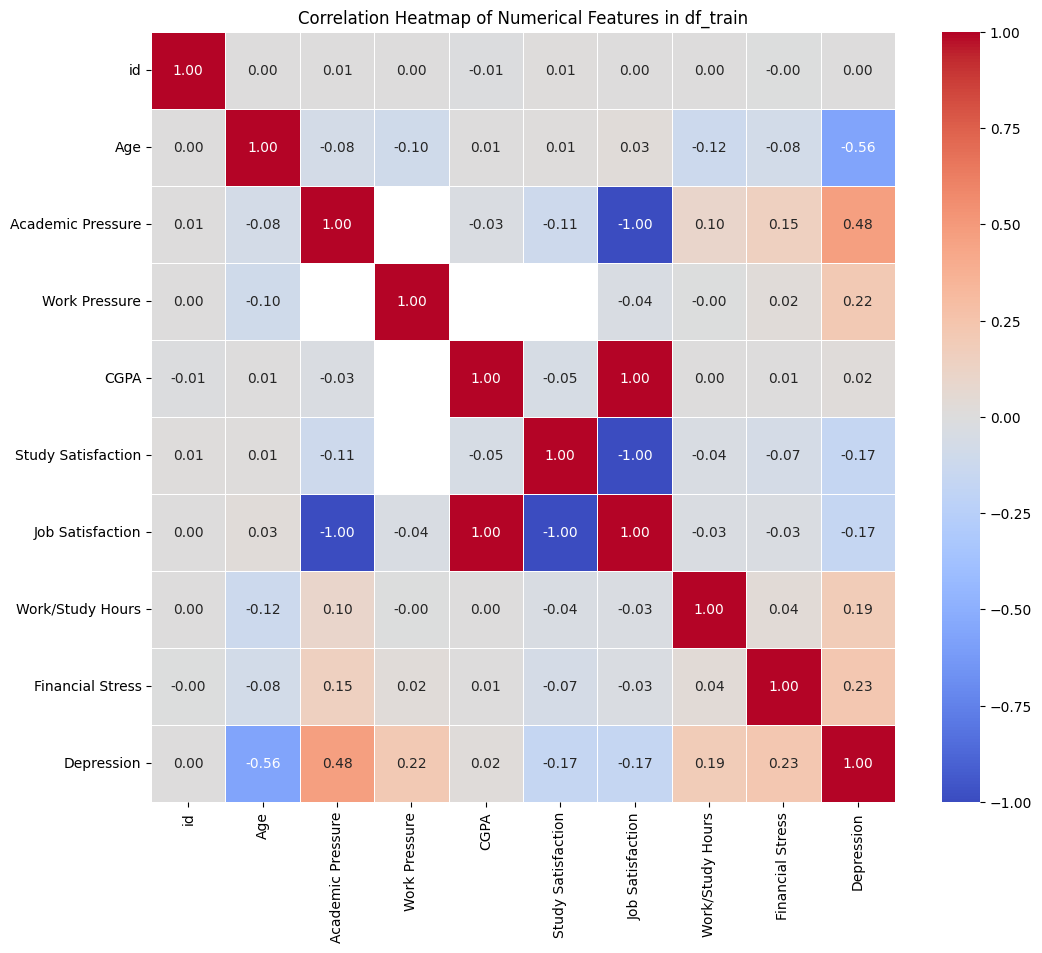

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

# df_train DataFrame의 수치형 피쳐 간의 상관 행렬 계산
# .corr() 메소드는 DataFrame의 모든 수치형 컬럼 간의 pairwise 상관관계를 계산합니다.
correlation_matrix = df_train.corr(numeric_only=True)

# 상관 행렬을 히트맵으로 시각화
plt.figure(figsize=(12, 10)) # 히트맵 크기 설정 (원하는 크기로 조절 가능)
sns.heatmap(correlation_matrix,
            annot=True, # 각 셀에 상관계수 값 표시
            cmap='coolwarm', # 색상 팔레트 설정 ('coolwarm', 'viridis', 'plasma' 등 사용 가능)
            fmt=".2f", # 소수점 둘째 자리까지 표시
            linewidths=.5) # 셀 경계선 두께 설정

plt.title('Correlation Heatmap of Numerical Features in df_train') # 그래프 제목 설정
plt.show() # 그래프 표시

In [99]:
#도시 중 학생 수가 400명이 넘지 않는 도시에 포함된 데이터를 이상치로 판단하고 df_train에서 제거

# 도시에 따른 학생 수 계산
city_student_counts = df_train['City'].value_counts()

# 학생 수가 400명 이하인 도시 리스트 파악
cities_to_remove = city_student_counts[city_student_counts <= 400].index.tolist()

# 이상치 도시(학생 수 400명 이하인 도시)에 포함되지 않는 데이터만 남기고 제거
df_train = df_train[~df_train['City'].isin(cities_to_remove)].copy()

print(f"제거된 도시: {cities_to_remove}")
print("학생 수 400명이 넘는 도시의 데이터만 남은 df_train:")
print(df_train.head())
print(f"이상치 제거 후 df_train의 행 개수: {len(df_train)}")

제거된 도시: ['Mihir', 'Nandini', 'Harsha', 'Saanvi', 'Mahi', 'Vidya', 'Pratyush', 'Bhavna', 'City', 'M.Com', 'Nalini', 'Ayush', 'Atharv', 'MCA', 'Molkata', 'Keshav', 'Gurgaon', 'Vidhi', 'Ishanabad', 'Raghavendra', 'Plata', 'Less Delhi', 'M.Tech', 'Aishwarya', 'Krishna', 'Mira', 'Less than 5 Kalyan', '3.0', 'Morena', 'Moreadhyay', 'Kashk', 'Ishkarsh', 'Tolkata', 'Anvi', 'Aditya', 'Malyansh', 'Ayansh', 'Krinda', 'Vaanya', 'Shrey', 'Harsh', 'Reyansh', 'Kashish', 'Ivaan', 'Kibara', 'Vaishnavi', 'Chhavi', 'Parth', 'Tushar', 'MSc', 'No', 'Gaurav', 'Rashi', 'ME', 'Researcher', 'Kagan', 'Armaan', 'Ithal', 'Nalyan', 'Dhruv', 'Galesabad', 'Itheg', 'Aaradhya', 'Pooja', 'Khushi', 'Khaziabad', 'Jhanvi', 'Unirar']
학생 수 400명이 넘는 도시의 데이터만 남은 df_train:
   id      Name  Gender   Age           City Working Professional or Student  \
0   0  Aaradhya  Female  49.0       Ludhiana            Working Professional   
1   1     Vivan    Male  26.0       Varanasi            Working Professional   
2   2    Yuvraj   

In [100]:
df_train

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140695,140695,Vidya,Female,18.0,Ahmedabad,Working Professional,NaN,NaN,5.0,NaN,NaN,4.0,5-6 hours,Unhealthy,Class 12,No,2.0,4.0,Yes,1
140696,140696,Lata,Female,41.0,Hyderabad,Working Professional,Content Writer,NaN,5.0,NaN,NaN,4.0,7-8 hours,Moderate,B.Tech,Yes,6.0,5.0,Yes,0
140697,140697,Aanchal,Female,24.0,Kolkata,Working Professional,Marketing Manager,NaN,3.0,NaN,NaN,1.0,More than 8 hours,Moderate,B.Com,No,4.0,4.0,No,0
140698,140698,Prachi,Female,49.0,Srinagar,Working Professional,Plumber,NaN,5.0,NaN,NaN,2.0,5-6 hours,Moderate,ME,Yes,10.0,1.0,No,0


In [101]:
# prompt: id, Name, Gender, Working Professional or Student, Working Professional or Student 컬럼을 제거해줘.

df_train = df_train.drop(['id', 'Name', 'Gender','CGPA','Family History of Mental Illness'], axis=1)

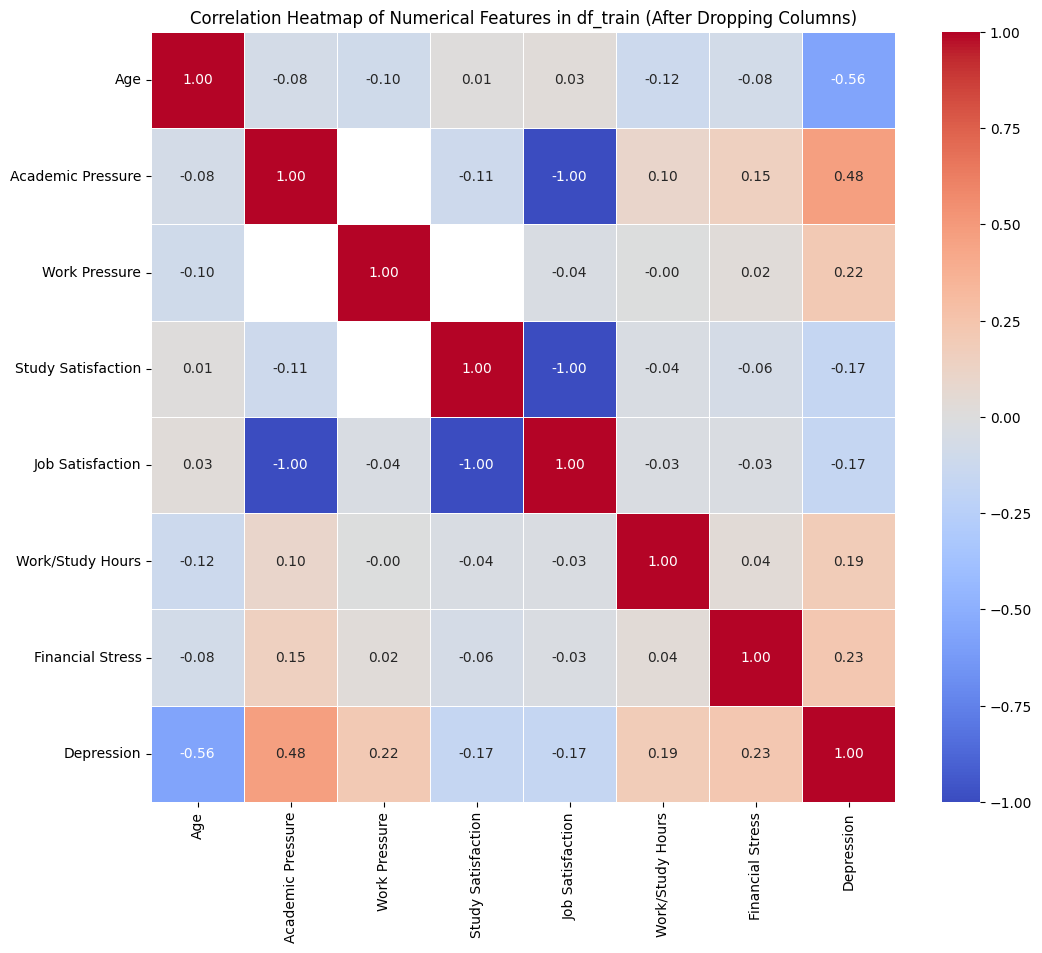

In [102]:
# prompt: df_train의 feature 별 상관관계 히트맵 생성

# 수치형 데이터만 선택
df_train_numeric = df_train.select_dtypes(include=['number'])

# 상관관계 계산
correlation_matrix_filtered = df_train_numeric.corr()

# 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_filtered,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=.5)
plt.title('Correlation Heatmap of Numerical Features in df_train (After Dropping Columns)')
plt.show()

In [103]:
initial_rows = len(df_train)
df_train = df_train[df_train['Work Pressure'].isna()].copy()

removed_rows = initial_rows - len(df_train)
print(f"'Work Pressure'가 NaN 값이 아닌 이상치 데이터 {removed_rows}개를 제거했습니다.")
print("Work Pressure가 NaN인 데이터만 남은 df_train:")
print(df_train.head())
print(f"이상치 제거 후 df_train의 행 개수: {len(df_train)}")

'Work Pressure'가 NaN 값이 아닌 이상치 데이터 112710개를 제거했습니다.
Work Pressure가 NaN인 데이터만 남은 df_train:
     Age           City Working Professional or Student Profession  \
2   33.0  Visakhapatnam                         Student        NaN   
8   24.0      Bangalore                         Student        NaN   
26  31.0       Srinagar                         Student        NaN   
30  28.0       Varanasi                         Student        NaN   
32  25.0         Jaipur                         Student        NaN   

    Academic Pressure  Work Pressure  Study Satisfaction  Job Satisfaction  \
2                 5.0            NaN                 2.0               NaN   
8                 2.0            NaN                 5.0               NaN   
26                3.0            NaN                 5.0               NaN   
30                3.0            NaN                 2.0               NaN   
32                4.0            NaN                 3.0               NaN   

       Sleep Duratio

In [104]:
df_train = df_train.drop(['Work Pressure'],axis = 1)

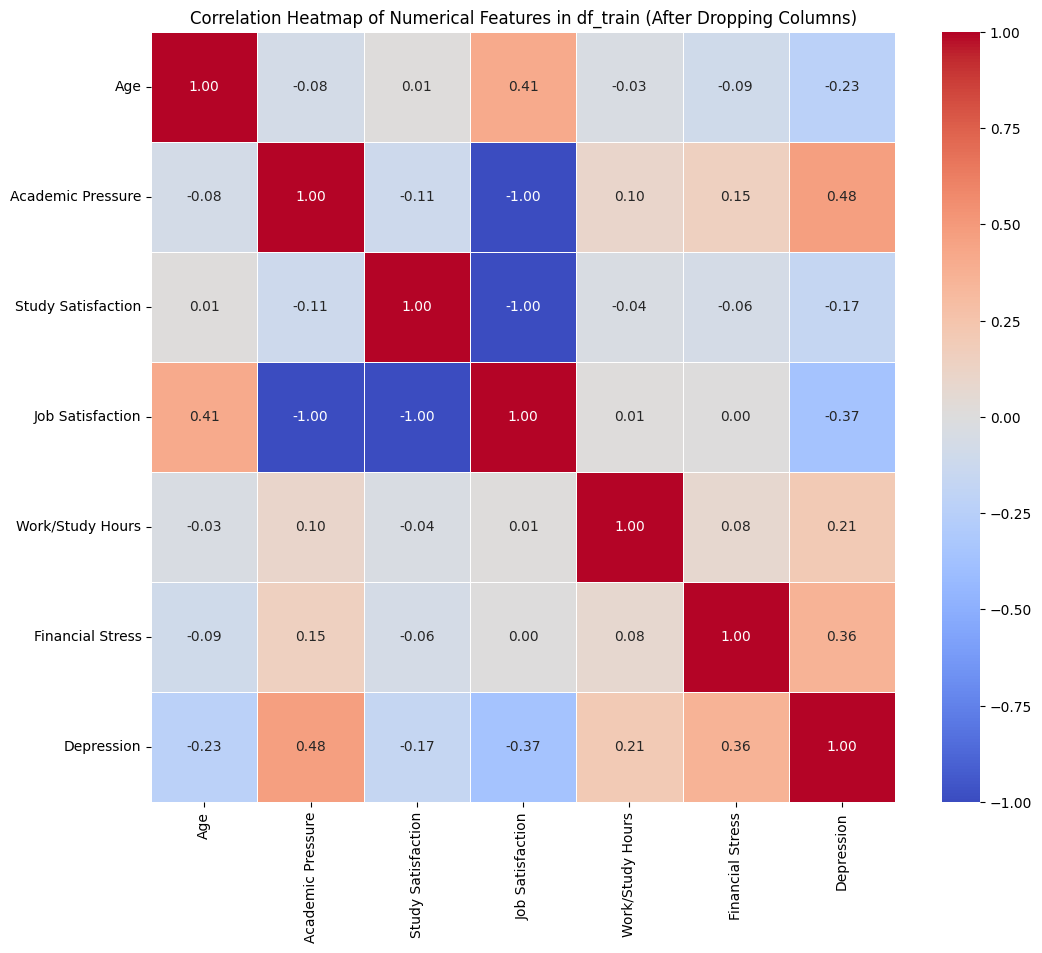

In [105]:
# prompt: df_train의 feature 별 상관관계 히트맵 생성

# 수치형 데이터만 선택
df_train_numeric = df_train.select_dtypes(include=['number'])

# 상관관계 계산
correlation_matrix_filtered = df_train_numeric.corr()

# 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_filtered,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=.5)
plt.title('Correlation Heatmap of Numerical Features in df_train (After Dropping Columns)')
plt.show()

In [106]:
df_train = df_train[df_train['Job Satisfaction'].isna()].copy()
df_train = df_train.drop(['Job Satisfaction'],axis =1 )

In [107]:
df_train

,Age,City,Working Professional or Student,Profession,Academic Pressure,Study Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Depression
2,33.0,Visakhapatnam,Student,NaN,5.0,2.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,1
8,24.0,Bangalore,Student,NaN,2.0,5.0,5-6 hours,Moderate,BSc,No,3.0,2.0,0
26,31.0,Srinagar,Student,NaN,3.0,5.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,0
30,28.0,Varanasi,Student,NaN,3.0,2.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,1
32,25.0,Jaipur,Student,NaN,4.0,3.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
140685,27.0,Surat,Student,NaN,5.0,5.0,5-6 hours,Unhealthy,Class 12,Yes,7.0,1.0,0
140686,27.0,Ludhiana,Student,NaN,2.0,3.0,Less than 5 hours,Healthy,MSc,No,0.0,3.0,0
140689,31.0,Faridabad,Student,NaN,3.0,4.0,5-6 hours,Unhealthy,MD,No,12.0,2.0,0
140690,18.0,Ludhiana,Student,NaN,5.0,2.0,Less than 5 hours,Healthy,Class 12,Yes,10.0,5.0,1


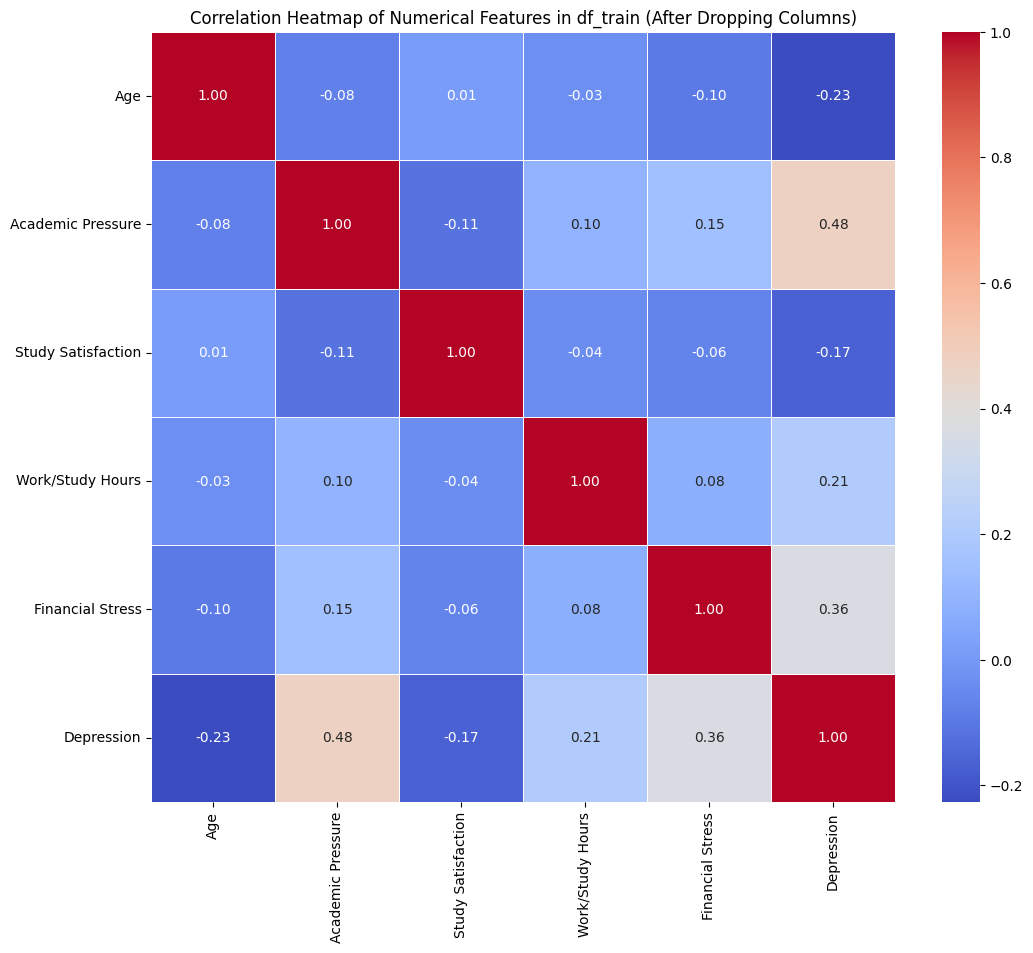

In [108]:
df_train_numeric = df_train.select_dtypes(include=['number'])

# 상관관계 계산
correlation_matrix_filtered = df_train_numeric.corr()

# 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_filtered,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=.5)
plt.title('Correlation Heatmap of Numerical Features in df_train (After Dropping Columns)')
plt.show()

In [109]:
df_train

,Age,City,Working Professional or Student,Profession,Academic Pressure,Study Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Depression
2,33.0,Visakhapatnam,Student,NaN,5.0,2.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,1
8,24.0,Bangalore,Student,NaN,2.0,5.0,5-6 hours,Moderate,BSc,No,3.0,2.0,0
26,31.0,Srinagar,Student,NaN,3.0,5.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,0
30,28.0,Varanasi,Student,NaN,3.0,2.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,1
32,25.0,Jaipur,Student,NaN,4.0,3.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
140685,27.0,Surat,Student,NaN,5.0,5.0,5-6 hours,Unhealthy,Class 12,Yes,7.0,1.0,0
140686,27.0,Ludhiana,Student,NaN,2.0,3.0,Less than 5 hours,Healthy,MSc,No,0.0,3.0,0
140689,31.0,Faridabad,Student,NaN,3.0,4.0,5-6 hours,Unhealthy,MD,No,12.0,2.0,0
140690,18.0,Ludhiana,Student,NaN,5.0,2.0,Less than 5 hours,Healthy,Class 12,Yes,10.0,5.0,1


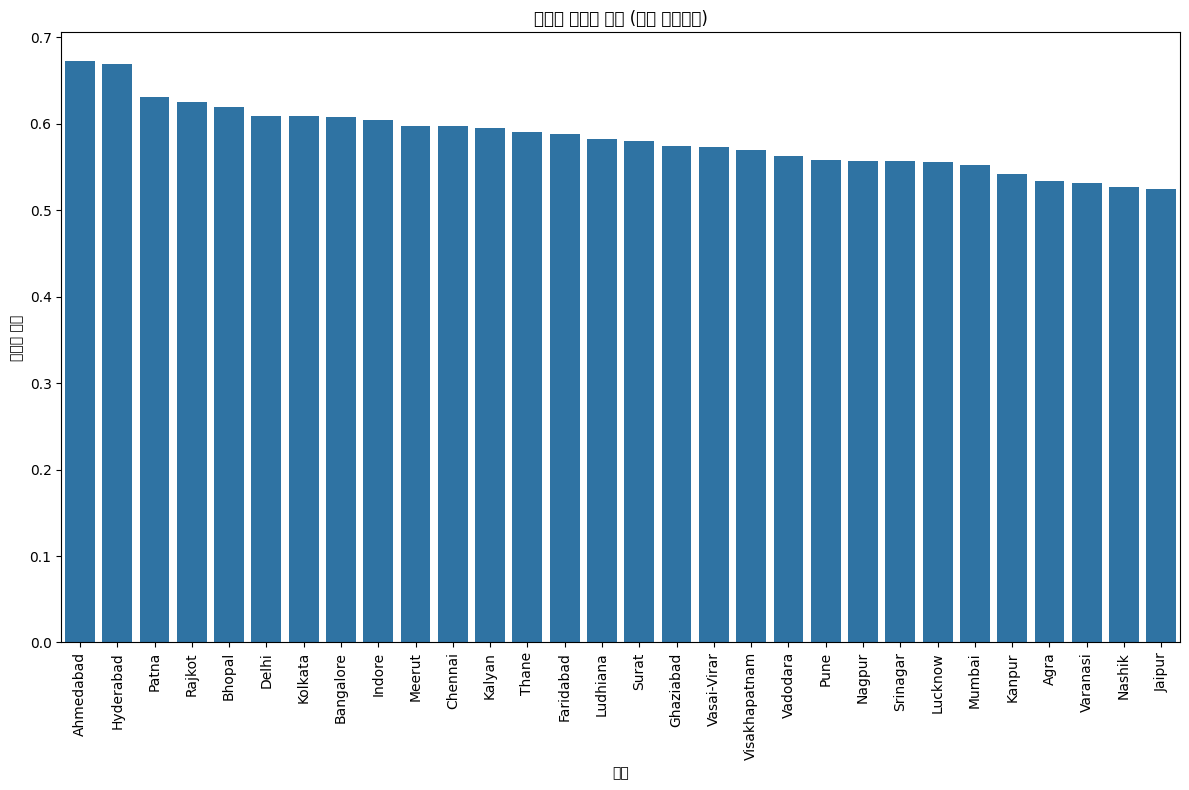

In [110]:
# prompt: 도시별로 depression 비율을 시각화하고 높은 순서대로 정렬해줘.

# 도시별 우울증 비율 계산
city_depression_rate = df_train.groupby('City')['Depression'].value_counts(normalize=True).unstack()[1].sort_values(ascending=False)

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x=city_depression_rate.index, y=city_depression_rate.values)
plt.title('도시별 우울증 비율 (높은 순서대로)')
plt.xlabel('도시')
plt.ylabel('우울증 비율')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [111]:
indea = pd.read_csv('indeacity.csv')

In [112]:
# Entity properties name과 Variable observation value 컬럼만 데이터로 만들어줘.

In [113]:
# prompt: Entity properties name과 Variable observation value 컬럼만 따로 데이터로 만들어줘.

# Assuming 'indea' DataFrame is already loaded and contains
# 'Entity properties name' and 'Variable observation value' columns.

# Create a new DataFrame containing only the specified columns
df_selected_columns = indea[['Entity properties name', 'Variable observation value']]

# Display the first few rows of the new DataFrame
print("DataFrame with only 'Entity properties name' and 'Variable observation value':")
print(df_selected_columns.head())

KeyError: "None of [Index(['Entity properties name', 'Variable observation value'], dtype='object')] are in the [columns]"

In [ ]:
# prompt: df_selected_columns와 df_train의 City 컬럼을 비교해줘

# 두 데이터프레임의 'City' 컬럼을 비교합니다.
# 여기서는 두 데이터프레임에 공통으로 존재하는 도시를 확인합니다.
# 또는 두 컬럼의 고유한 값을 비교하거나, 각 컬럼의 값 분포를 비교할 수 있습니다.

print("df_selected_columns의 고유한 'Entity properties name' 값의 개수:", df_selected_columns['Entity properties name'].nunique())
print("df_train의 고유한 'City' 값의 개수:", df_train['City'].nunique())

# 두 컬럼에 공통으로 포함된 도시 확인
common_cities = set(df_selected_columns['Entity properties name']).intersection(set(df_train['City']))
print(f"\n두 데이터프레임의 'Entity properties name'와 'City' 컬럼에 공통으로 포함된 도시의 개수: {len(common_cities)}")
print("공통 도시:", list(common_cities)[:10]) # 처음 10개만 출력 (많을 경우)

# df_selected_columns에만 있는 도시 확인
only_in_selected = set(df_selected_columns['Entity properties name']) - set(df_train['City'])
print(f"\ndf_selected_columns에만 있는 도시의 개수: {len(only_in_selected)}")
print("df_selected_columns에만 있는 도시:", list(only_in_selected)[:10])

# df_train에만 있는 도시 확인
only_in_students = set(df_train['City']) - set(df_selected_columns['Entity properties name'])
print(f"\ndf_train에만 있는 도시의 개수: {len(only_in_students)}")
print("df_train에만 있는 도시:", list(only_in_students)[:10])

# 또는 각 컬럼의 값 분포를 시각적으로 비교할 수 있습니다.
# 예: 두 컬럼의 상위 빈도 도시 비교

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
df_selected_columns['Entity properties name'].value_counts().head(10).plot(kind='bar')
plt.title('df_selected_columns - Top 10 Cities (Entity properties name)')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
df_train['City'].value_counts().head(10).plot(kind='bar')
plt.title('df_train - Top 10 Cities (City)')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
# prompt: df_train에만 있는 도시 목록을 뽑아줘.

# df_train에만 있는 도시 목록을 리스트로 저장
cities_only_in_students_list = list(only_in_students)

print("\ndf_train에만 있는 도시 목록:")
cities_only_in_students_list


In [115]:
import pandas as pd

# df_train 데이터프레임이 이미 로드되어 있다고 가정합니다.

# 이전에 추출한 한글 도시 이름 목록 (city_names 변수)을 사용합니다.
# 만약 city_names 변수가 없다면, 이전 코드를 먼저 실행하여 생성해야 합니다.
# 예시: city_names = ['뭄바이, 마하라슈트라주', '하이데라바드, 텔랑가나주', ...]

# Define city_list_str as it was in the previous cell
city_list_str = """
1	뭄바이, 마하라슈트라주	11,978,450
2	하이데라바드, 텔랑가나주	9,305,000
3	수라트, 구자라트주	6,936,534
4	콜카타, 서벵골주	4,572,876
5	벵갈루루, 카르나타카주	4,301,326
6	러크나우, 우타르프라데시주	3,382,000
7	바도다라, 구자라트주	3,100,260
8	자이푸르, 라자스탄주	3,073,350
9	칸푸르, 우타르프라데시주	2,551,337
10	가지아바드, 우타르프라데시주	2,381,452
11	인도르, 마디아프라데시주	2,201,927
12	보팔, 마디아프라데시주	1,883,381
13	파트나, 비하르주	1,684,222
14	아그라, 우타르프라데시주	1,585,704
15	Meerut, 우타르프라데시주	1,571,434
16	조드푸르, 라자스탄주	1,533,756
17	나시크, 마하라슈트라주	1,486,053
18	파리다바드, 하리아나주	1,404,653
19	콜람, 케랄라주	1,342,509
20	라지코트, 구자라트주	1,335,397
21	자발푸르, 마디아프라데시주	1,267,564
22	타네, 마하라슈트라주	1,261,517
23	바라나시, 우타르프라데시주	1,198,491
24	괄리오르, 마디아프라데시주	1,101,981
25	란치, 자르칸드주	1,073,440
26	핌프리친치와드, 마하라슈트라주	1,012,472
27	하우라, 서벵골주	1,007,532
28	비샤카파트남, 안드라프라데시주	982,904
29	알라하바드, 우타르프라데시주	975,393
30	티루치라팔리, 타밀나두주	916,857
31	잘란다르, 펀자브주	873,725
32	아우랑가바드, 마하라슈트라주	873,311
33	비자야와다, 안드라프라데시주	851,282
34	구와하티, 아삼주	809,895
35	후블리, 카르나타카주	786,195
36	파티알라, 펀자브주	763,280
37	마이소르, 카르나타카주	755,379
38	티루바난타푸람, 케랄라주	743,691
39	나비뭄바이, 마하라슈트라주	704,002
40	부바네스와르, 오디샤주	648,032
41	군투르, 안드라프라데시주	647,508
42	쿠타크, 오디샤주	606,007
43	비완디, 마하라슈트라주	598,741
44	코치, 케랄라주	595,575
45	잠셰드푸르, 자르칸드주	573,096
46	빌라이, 차티스가르주	556,366
47	미라 뱌라다, 마하라슈트라주	520,388
48	쟌지, 우타르프라데시주	507,000
49	Mumbra, 마하라슈트라주	500,000
50	두르가푸르, 서벵골주	493,405
51	아산솔, 서벵골주	475,439
52	울하스나가르, 마하라슈트라주	473,731
53	실리구리, 서벵골주	472,374
54	잘콘, 마하라슈트라주	460,468
55	쿠르누엘, 안드라프라데시주	457,633
56	주나가, 구자라트주	452,000
57	밧파라, 서벵골주	442,385
58	상글리, 마하라슈트라주	436,639
59	굴바르가, 카르나타카주	422,569
60	말레곤, 마하라슈트라주	409,403
61	벨가움, 카르나타카주	399,653
62	망갈로르, 카르나타카주	399,565
63	잘나, 마하라슈트라주	393,000
64	South Dum Dum, 서벵골주	392,444
65	Maheshtala, 서벵골주	385,266
66	닐로레, 안드라프라데시주	378,428
67	다바나게레, 카르나타카주	364,523
68	시카, 라자스탄주	359,293
69	Panihati, 서벵골주	348,438
70	카다파, 안드라프라데시주	344,893
71	Rajpur Sonarpur, 서벵골주	336,707
72	무자파르푸르, 비하르주	333,200
73	싸라드, 구자라트주	327,289
74	사타라, 마하라슈트라주	326,789
75	시서, 케랄라주	315,596
76	라자문드리, 안드라프라데시주	315,251
77	Kamaharhati, 서벵골주	314,507
78	니자마바드, 텔랑가나주	311,152
79	Ambattur, 타밀나두주	310,967
80	푸리나, 비하르주	310,817
81	노이다
"""

# Split the string into lines and process each line
lines = city_list_str.strip().split('\n')

# Extract only the city names
city_names = [line.split('\t')[1].strip() for line in lines] # Corrected list comprehension

print("Extracted City Names:")
for city in city_names:
    print(city) # Corrected print statement

# 한글 도시 이름을 영어로 번역 (이 부분은 외부 도구나 매핑이 필요합니다.)
# 여기서는 수동으로 몇 가지 예시만 매핑합니다.
# 실제 사용 시에는 전체 목록에 대한 번역 매핑이 필요합니다.
korean_to_english_city_map = {
    '뭄바이, 마하라슈트라주': 'Mumbai',
    '하이데라바드, 텔랑가나주': 'Hyderabad',
    '수라트, 구자라트주': 'Surat',
    '콜카타, 서벵골주': 'Kolkata',
    '벵갈루루, 카르나타카주': 'Bangalore', # 또는 Bengaluru
    '러크나우, 우타르프라데시주': 'Lucknow',
    '바도다라, 구자라트주': 'Vadodara',
    '자이푸르, 라자스탄주': 'Jaipur',
    '칸푸르, 우타르프라데시주': 'Kanpur',
    '가지아바드, 우타르프라데시주': 'Ghaziabad',
    '인도르, 마디아프라데시주': 'Indore',
    '보팔, 마디아프라데시주': 'Bhopal',
    '파트나, 비하르주': 'Patna',
    '아그라, 우타르프라데시주': 'Agra',
    'Meerut, 우타르프라데시주': 'Meerut',
    '조드푸르, 라자스탄주': 'Jodhpur',
    '나시크, 마하라슈트라주': 'Nashik',
    '파리다바드, 하리아나주': 'Faridabad',
    '콜람, 케랄라주': 'Kollam', # 또는 Quilon
    '라지코트, 구자라트주': 'Rajkot',
    '자발푸르, 마디아프라데시주': 'Jabalpur',
    '타네, 마하라슈트라주': 'Thane',
    '바라나시, 우타르프라데시주': 'Varanasi', # 또는 Benares
    '괄리오르, 마디아프라데시주': 'Gwalior',
    '란치, 자르칸드주': 'Ranchi',
    '핌프리친치와드, 마하라슈트라주': 'Pimpri-Chinchwad',
    '하우라, 서벵골주': 'Howrah',
    '비샤카파트남, 안드라프라데시주': 'Visakhapatnam', # 또는 Vizag
    '알라하바드, 우타르프라데시주': 'Allahabad', # 또는 Prayagraj
    '티루치라팔리, 타밀나두주': 'Tiruchirappalli', # 또는 Trichy
    '잘란다르, 펀자브주': 'Jalandhar',
    '아우랑가바드, 마하라슈트라주': 'Aurangabad',
    '비자야와다, 안드라프라데시주': 'Vijayawada',
    '구와하티, 아삼주': 'Guwahati',
    '후블리, 카르나타카주': 'Hubli', # 또는 Hubballi
    '파티알라, 펀자브주': 'Patiala',
    '마이소르, 카르나타카주': 'Mysore', # 또는 Mysuru
    '티루바난타푸람, 케랄라주': 'Thiruvananthapuram', # 또는 Trivandrum
    '나비뭄바이, 마하라슈트라주': 'Navi Mumbai',
    '부바네스와르, 오디샤주': 'Bhubaneswar',
    '군투르, 안드라프라데시주': 'Guntur',
    '쿠타크, 오디샤주': 'Cuttack',
    '비완디, 마하라슈트라주': 'Bhiwandi',
    '코치, 케랄라주': 'Kochi', # 또는 Cochin
    '잠셰드푸르, 자르칸드주': 'Jamshedpur',
    '빌라이, 차티스가르주': 'Bhilai',
    '미라 뱌라다, 마하라슈트라주': 'Mira-Bhayandar', # 또는 Mira Bhayandar
    '쟌지, 우타르프라데시주': 'Jhansi',
    'Mumbra, 마하라슈트라주': 'Mumbra',
    '두르가푸르, 서벵골주': 'Durgapur',
    '아산솔, 서벵골주': 'Asansol',
    '울하스나가르, 마하라슈트라주': 'Ulhasnagar',
    '실리구리, 서벵골주': 'Siliguri',
    '잘콘, 마하라슈트라주': 'Jalgaon',
    '쿠르누엘, 안드라프라데시주': 'Kurnool',
    '주나가, 구자라트주': 'Junagadh',
    '밧파라, 서벵골주': 'Bhatpara',
    '상글리, 마하라슈트라주': 'Sangli',
    '굴바르가, 카르나타카주': 'Gulbarga', # 또는 Kalaburagi
    '말레곤, 마하라슈트라주': 'Malegaon',
    '벨가움, 카르나타카주': 'Belgaum', # 또는 Belagavi
    '망갈로르, 카르나타카주': 'Mangalore', # 또는 Mangaluru
    '잘나, 마하라슈트라주': 'Jalna',
    'South Dum Dum, 서벵골주': 'South Dum Dum',
    'Maheshtala, 서벵골주': 'Maheshtala',
    '닐로레, 안드라프라데시주': 'Nellore',
    '다바나게레, 카르나타카주': 'Davanagere',
    '시카, 라자스탄주': 'Sikar',
    'Panihati, 서벵골주': 'Panihati',
    '카다파, 안드라프라데시주': 'Kadapa', # 또는 Cuddapah
    'Rajpur Sonarpur, 서벵골주': 'Rajpur Sonarpur',
    '무자파르푸르, 비하르주': 'Muzaffarpur',
    '싸라드, 구자라트주': 'Surendranagar', # 또는 Suraj
    '사타라, 마하라슈트라주': 'Satara',
    '시서, 케랄라주': 'Thrissur', # 또는 Trichur
    '라자문드리, 안드라프라프데시주': 'Rajahmundry', # 또는 Rajamahendravaram
    'Kamaharhati, 서벵골주': 'Kamarhati',
    '니자마바드, 텔랑가나주': 'Nizamabad',
    'Ambattur, 타밀나두주': 'Ambattur',
    '푸리나, 비하르주': 'Purnia',
    '노이다': 'Noida' # Noida는 주의 정보가 없어서 이름만 매핑
}

# 번역된 영어 도시 이름 목록 생성
english_city_names = [korean_to_english_city_map.get(city.strip(), city.strip()) for city in city_names]

print("번역된 영어 도시 이름 목록 (매핑되지 않은 이름 포함):")
print(english_city_names)
print("-" * 30)


# df_train에 포함된 도시 이름 확인
cities_in_df_train = df_train['City'].unique().tolist()

# df_train에 포함된 영어 도시 이름 중 번역

Extracted City Names:
뭄바이, 마하라슈트라주
하이데라바드, 텔랑가나주
수라트, 구자라트주
콜카타, 서벵골주
벵갈루루, 카르나타카주
러크나우, 우타르프라데시주
바도다라, 구자라트주
자이푸르, 라자스탄주
칸푸르, 우타르프라데시주
가지아바드, 우타르프라데시주
인도르, 마디아프라데시주
보팔, 마디아프라데시주
파트나, 비하르주
아그라, 우타르프라데시주
Meerut, 우타르프라데시주
조드푸르, 라자스탄주
나시크, 마하라슈트라주
파리다바드, 하리아나주
콜람, 케랄라주
라지코트, 구자라트주
자발푸르, 마디아프라데시주
타네, 마하라슈트라주
바라나시, 우타르프라데시주
괄리오르, 마디아프라데시주
란치, 자르칸드주
핌프리친치와드, 마하라슈트라주
하우라, 서벵골주
비샤카파트남, 안드라프라데시주
알라하바드, 우타르프라데시주
티루치라팔리, 타밀나두주
잘란다르, 펀자브주
아우랑가바드, 마하라슈트라주
비자야와다, 안드라프라데시주
구와하티, 아삼주
후블리, 카르나타카주
파티알라, 펀자브주
마이소르, 카르나타카주
티루바난타푸람, 케랄라주
나비뭄바이, 마하라슈트라주
부바네스와르, 오디샤주
군투르, 안드라프라데시주
쿠타크, 오디샤주
비완디, 마하라슈트라주
코치, 케랄라주
잠셰드푸르, 자르칸드주
빌라이, 차티스가르주
미라 뱌라다, 마하라슈트라주
쟌지, 우타르프라데시주
Mumbra, 마하라슈트라주
두르가푸르, 서벵골주
아산솔, 서벵골주
울하스나가르, 마하라슈트라주
실리구리, 서벵골주
잘콘, 마하라슈트라주
쿠르누엘, 안드라프라데시주
주나가, 구자라트주
밧파라, 서벵골주
상글리, 마하라슈트라주
굴바르가, 카르나타카주
말레곤, 마하라슈트라주
벨가움, 카르나타카주
망갈로르, 카르나타카주
잘나, 마하라슈트라주
South Dum Dum, 서벵골주
Maheshtala, 서벵골주
닐로레, 안드라프라데시주
다바나게레, 카르나타카주
시카, 라자스탄주
Panihati, 서벵골주
카다파, 안드라프라데시주
Rajpur Sonarpur, 서벵골주
무자파르푸르, 비하르주
싸라드, 구자라트주
사타라, 마하라슈트

In [116]:
# df_train에 포함된 도시 이름 확인
cities_in_df_train = df_train['City'].unique().tolist()

In [117]:
cities_in_df_train

['Visakhapatnam',
 'Bangalore',
 'Srinagar',
 'Varanasi',
 'Jaipur',
 'Pune',
 'Thane',
 'Chennai',
 'Nagpur',
 'Nashik',
 'Vadodara',
 'Kalyan',
 'Rajkot',
 'Ahmedabad',
 'Kolkata',
 'Mumbai',
 'Lucknow',
 'Indore',
 'Surat',
 'Ludhiana',
 'Bhopal',
 'Meerut',
 'Agra',
 'Ghaziabad',
 'Hyderabad',
 'Vasai-Virar',
 'Kanpur',
 'Patna',
 'Faridabad',
 'Delhi']

In [118]:
# prompt: korean_to_english_city_map에서 cities_in_df_train에 해당하는 도시들만 데이터를 모아줘.

# `korean_to_english_city_map`에서 `cities_in_df_train`에 해당하는 도시들만 필터링
filtered_city_map = {k: v for k, v in korean_to_english_city_map.items() if v in cities_in_df_train}

print("df_train에 포함된 도시에 해당하는 번역된 도시 맵:")
print(filtered_city_map)
print(f"\n필터링된 도시 개수: {len(filtered_city_map)}")

df_train에 포함된 도시에 해당하는 번역된 도시 맵:
{'뭄바이, 마하라슈트라주': 'Mumbai', '하이데라바드, 텔랑가나주': 'Hyderabad', '수라트, 구자라트주': 'Surat', '콜카타, 서벵골주': 'Kolkata', '벵갈루루, 카르나타카주': 'Bangalore', '러크나우, 우타르프라데시주': 'Lucknow', '바도다라, 구자라트주': 'Vadodara', '자이푸르, 라자스탄주': 'Jaipur', '칸푸르, 우타르프라데시주': 'Kanpur', '가지아바드, 우타르프라데시주': 'Ghaziabad', '인도르, 마디아프라데시주': 'Indore', '보팔, 마디아프라데시주': 'Bhopal', '파트나, 비하르주': 'Patna', '아그라, 우타르프라데시주': 'Agra', 'Meerut, 우타르프라데시주': 'Meerut', '나시크, 마하라슈트라주': 'Nashik', '파리다바드, 하리아나주': 'Faridabad', '라지코트, 구자라트주': 'Rajkot', '타네, 마하라슈트라주': 'Thane', '바라나시, 우타르프라데시주': 'Varanasi', '비샤카파트남, 안드라프라데시주': 'Visakhapatnam'}

필터링된 도시 개수: 21


In [119]:
# prompt: 필터링된 도시의 영어 이름과 인구 수만 새롭게 컬럼으로 만들어서 데이터를 만들어줘.

# Define city_list_str (as provided in the preceding code)
city_list_str = """
1	뭄바이, 마하라슈트라주	11,978,450
2	하이데라바드, 텔랑가나주	9,305,000
3	수라트, 구자라트주	6,936,534
4	콜카타, 서벵골주	4,572,876
5	벵갈루루, 카르나타카주	4,301,326
6	러크나우, 우타르프라데시주	3,382,000
7	바도다라, 구자라트주	3,100,260
8	자이푸르, 라자스탄주	3,073,350
9	칸푸르, 우타르프라데시주	2,551,337
10	가지아바드, 우타르프라데시주	2,381,452
11	인도르, 마디아프라데시주	2,201,927
12	보팔, 마디아프라데시주	1,883,381
13	파트나, 비하르주	1,684,222
14	아그라, 우타르프라데시주	1,585,704
15	Meerut, 우타르프라데시주	1,571,434
16	조드푸르, 라자스탄주	1,533,756
17	나시크, 마하라슈트라주	1,486,053
18	파리다바드, 하리아나주	1,404,653
19	콜람, 케랄라주	1,342,509
20	라지코트, 구자라트주	1,335,397
21	자발푸르, 마디아프라데시주	1,267,564
22	타네, 마하라슈트라주	1,261,517
23	바라나시, 우타르프라데시주	1,198,491
24	괄리오르, 마디아프라데시주	1,101,981
25	란치, 자르칸드주	1,073,440
26	핌프리친치와드, 마하라슈트라주	1,012,472
27	하우라, 서벵골주	1,007,532
28	비샤카파트남, 안드라프라데시주	982,904
29	알라하바드, 우타르프라데시주	975,393
30	티루치라팔리, 타밀나두주	916,857
31	잘란다르, 펀자브주	873,725
32	아우랑가바드, 마하라슈트라주	873,311
33	비자야와다, 안드라프라데시주	851,282
34	구와하티, 아삼주	809,895
35	후블리, 카르나타카주	786,195
36	파티알라, 펀자브주	763,280
37	마이소르, 카르나타카주	755,379
38	티루바난타푸람, 케랄라주	743,691
39	나비뭄바이, 마하라슈트라주	704,002
40	부바네스와르, 오디샤주	648,032
41	군투르, 안드라프라데시주	647,508
42	쿠타크, 오디샤주	606,007
43	비완디, 마하라슈트라주	598,741
44	코치, 케랄라주	595,575
45	잠셰드푸르, 자르칸드주	573,096
46	빌라이, 차티스가르주	556,366
47	미라 뱌라다, 마하라슈트라주	520,388
48	쟌지, 우타르프라데시주	507,000
49	Mumbra, 마하라슈트라주	500,000
50	두르가푸르, 서벵골주	493,405
51	아산솔, 서벵골주	475,439
52	울하스나가르, 마하라슈트라주	473,731
53	실리구리, 서벵골주	472,374
54	잘콘, 마하라슈트라주	460,468
55	쿠르누엘, 안드라프라데시주	457,633
56	주나가, 구자라트주	452,000
57	밧파라, 서벵골주	442,385
58	상글리, 마하라슈트라주	436,639
59	굴바르가, 카르나타카주	422,569
60	말레곤, 마하라슈트라주	409,403
61	벨가움, 카르나타카주	399,653
62	망갈로르, 카르나타카주	399,565
63	잘나, 마하라슈트라주	393,000
64	South Dum Dum, 서벵골주	392,444
65	Maheshtala, 서벵골주	385,266
66	닐로레, 안드라프라데시주	378,428
67	다바나게레, 카르나타카주	364,523
68	시카, 라자스탄주	359,293
69	Panihati, 서벵골주	348,438
70	카다파, 안드라프라데시주	344,893
71	Rajpur Sonarpur, 서벵골주	336,707
72	무자파르푸르, 비하르주	333,200
73	싸라드, 구자라트주	327,289
74	사타라, 마하라슈트라주	326,789
75	시서, 케랄라주	315,596
76	라자문드리, 안드라프라프데시주	315,251
77	Kamaharhati, 서벵골주	314,507
78	니자마바드, 텔랑가나주	311,152
79	Ambattur, 타밀나두주	310,967
80	푸리나, 비하르주	310,817
81	노이다
"""

# Split the string into lines and process each line
lines = city_list_str.strip().split('\n')

# Create a list of dictionaries to store the data
data = []
for line in lines:
  parts = line.split('\t')
  # Skip lines that don't have at least 3 parts (index, name, population)
  if len(parts) >= 3:
    # Extract the index (parts[0] - not used in the final output),
    # the city name (parts[1]), and the population (parts[2])
    city_korean = parts[1].strip()
    population_str = parts[2].strip().replace(',', '') # Remove commas from population string
    try:
      population = int(population_str)
      data.append({'City_Korean': city_korean, 'Population': population})
    except ValueError:
      # Handle cases where population is not a valid integer
      print(f"Skipping line due to invalid population: {line}")
      continue

# Create a DataFrame from the extracted data
df_cities_population = pd.DataFrame(data)

# Now, apply the translation map to get English city names
korean_to_english_city_map = {
    '뭄바이, 마하라슈트라주': 'Mumbai',
    '하이데라바드, 텔랑가나주': 'Hyderabad',
    '수라트, 구자라트주': 'Surat',
    '콜카타, 서벵골주': 'Kolkata',
    '벵갈루루, 카르나타카주': 'Bangalore', # 또는 Bengaluru
    '러크나우, 우타르프라데시주': 'Lucknow',
    '바도다라, 구자라트주': 'Vadodara',
    '자이푸르, 라자스탄주': 'Jaipur',
    '칸푸르, 우타르프라데시주': 'Kanpur',
    '가지아바드, 우타르프라데시주': 'Ghaziabad',
    '인도르, 마디아프라데시주': 'Indore',
    '보팔, 마디아프라데시주': 'Bhopal',
    '파트나, 비하르주': 'Patna',
    '아그라, 우타르프라데시주': 'Agra',
    'Meerut, 우타르프라데시주': 'Meerut',
    '조드푸르, 라자스탄주': 'Jodhpur',
    '나시크, 마하라슈트라주': 'Nashik',
    '파리다바드, 하리아나주': 'Faridabad',
    '콜람, 케랄라주': 'Kollam', # 또는 Quilon
    '라지코트, 구자라트주': 'Rajkot',
    '자발푸르, 마디아프라데시주': 'Jabalpur',
    '타네, 마하라슈트라주': 'Thane',
    '바라나시, 우타르프라데시주': 'Varanasi', # 또는 Benares
    '괄리오르, 마디아프라데시주': 'Gwalior',
    '란치, 자르칸드주': 'Ranchi',
    '핌프리친치와드, 마하라슈트라주': 'Pimpri-Chinchwad',
    '하우라, 서벵골주': 'Howrah',
    '비샤카파트남, 안드라프라데시주': 'Visakhapatnam', # 또는 Vizag
    '알라하바드, 우타르프라데시주': 'Allahabad', # 또는 Prayagraj
    '티루치라팔리, 타밀나두주': 'Tiruchirappalli', # 또는 Trichy
    '잘란다르, 펀자브주': 'Jalandhar',
    '아우랑가바드, 마하라슈트라주': 'Aurangabad',
    '비자야와다, 안드라프라데시주': 'Vijayawada',
    '구와하티, 아삼주': 'Guwahati',
    '후블리, 카르나타카주': 'Hubli', # 또는 Hubballi
    '파티알라, 펀자브주': 'Patiala',
    '마이소르, 카르나타카주': 'Mysore', # 또는 Mysuru
    '티루바난타푸람, 케랄라주': 'Thiruvananthapuram', # 또는 Trivandrum
    '나비뭄바이, 마하라슈트라주': 'Navi Mumbai',
    '부바네스와르, 오디샤주': 'Bhubaneswar',
    '군투르, 안드라프라데시주': 'Guntur',
    '쿠타크, 오디샤주': 'Cuttack',
    '비완디, 마하라슈트라주': 'Bhiwandi',
    '코치, 케랄라주': 'Kochi', # 또는 Cochin
    '잠셰드푸르, 자르칸드주': 'Jamshedpur',
    '빌라이, 차티스가르주': 'Bhilai',
    '미라 뱌라다, 마하라슈트라주': 'Mira-Bhayandar', # 또는 Mira Bhayandar
    '쟌지, 우타르프라데시주': 'Jhansi',
    'Mumbra, 마하라슈트라주': 'Mumbra',
    '두르가푸르, 서벵골주': 'Durgapur',
    '아산솔, 서벵골주': 'Asansol',
    '울하스나가르, 마하라슈트라주': 'Ulhasnagar',
    '실리구리, 서벵골주': 'Siliguri',
    '잘콘, 마하라슈트라주': 'Jalgaon',
    '쿠르누엘, 안드라프라데시주': 'Kurnool',
    '주나가, 구자라트주': 'Junagadh',
    '밧파라, 서벵골주': 'Bhatpara',
    '상글리, 마하라슈트라주': 'Sangli',
    '굴바르가, 카르나타카주': 'Gulbarga', # 또는 Kalaburagi
    '말레곤, 마하라슈트라주': 'Malegaon',
    '벨가움, 카르나타카주': 'Belgaum', # 또는 Belagavi
    '망갈로르, 카르나타카주': 'Mangalore', # 또는 Mangaluru
    '잘나, 마하라슈트라주': 'Jalna',
    'South Dum Dum, 서벵골주': 'South Dum Dum',
    'Maheshtala, 서벵골주': 'Maheshtala',
    '닐로레, 안드라프라데시주': 'Nellore',
    '다바나게레, 카르나타카주': 'Davanagere',
    '시카, 라자스탄주': 'Sikar',
    'Panihati, 서벵골주': 'Panihati',
    '카다파, 안드라프라데시주': 'Kadapa', # 또는 Cuddapah
    'Rajpur Sonarpur, 서벵골주': 'Rajpur Sonarpur',
    '무자파르푸르, 비하르주': 'Muzaffarpur',
    '싸라드, 구자라트주': 'Surendranagar', # 또는 Suraj
    '사타라, 마하라슈트라주': 'Satara',
    '시서, 케랄라주': 'Thrissur', # 또는 Trichur
    '라자문드리, 안드라프라프데시주': 'Rajahmundry', # 또는 Rajamahendravaram
    'Kamaharhati, 서벵골주': 'Kamarhati',
    '니자마바드, 텔랑가나주': 'Nizamabad',
    'Ambattur, 타밀나두주': 'Ambattur',
    '푸리나, 비하르주': 'Purnia',
    '노이다': 'Noida' # Noida는 주의 정보가 없어서 이름만 매핑
}


# Add a new column 'City_English' by mapping the 'City_Korean' column
df_cities_population['City_English'] = df_cities_population['City_Korean'].map(korean_to_english_city_map).fillna(df_cities_population['City_Korean']) # Use original if translation not found

# Select only the English city name and population columns
df_filtered_cities = df_cities_population[['City_English', 'Population']].copy()

# Rename columns for clarity (optional but good practice)
df_filtered_cities.rename(columns={'City_English': 'City', 'Population': 'Population'}, inplace=True)


# df_train에 있는 도시들만 필터링합니다.
# df_train의 고유한 도시 목록을 가져옵니다.
cities_in_df_train_unique = df_train['City'].unique().tolist()

# df_filtered_cities 데이터프레임을 df_train에 있는 도시들로 필터링합니다.
df_filtered_cities_matched = df_filtered_cities[df_filtered_cities['City'].isin(cities_in_df_train_unique)].copy()


print("\n필터링된 도시의 영어 이름과 인구 수 데이터:")
print(df_filtered_cities_matched.head())
print(f"\n필터링된 데이터프레임의 행 개수: {len(df_filtered_cities_matched)}")




필터링된 도시의 영어 이름과 인구 수 데이터:
        City  Population
0     Mumbai    11978450
1  Hyderabad     9305000
2      Surat     6936534
3    Kolkata     4572876
4  Bangalore     4301326

필터링된 데이터프레임의 행 개수: 21


In [120]:
# prompt: df_train의 도시 중 df_filtered_cities와 매치가 안 된 도시들을 뽑아줘.

# df_train에 있는 도시 목록
cities_in_df_train_unique = set(df_train['City'].unique())

# df_filtered_cities에 있는 도시 목록
cities_in_df_filtered_cities = set(df_filtered_cities['City'].unique())

# df_train에는 있지만 df_filtered_cities에는 없는 도시 찾기
cities_not_matched = list(cities_in_df_train_unique - cities_in_df_filtered_cities)

print("df_train의 도시 중 df_filtered_cities와 매치가 안 된 도시들:")
print(cities_not_matched)
print(f"매치가 안 된 도시의 개수: {len(cities_not_matched)}")

# 만약 매치되지 않은 도시들의 데이터를 df_train에서 확인하고 싶다면:
# df_train_unmatched = df_train[df_train['City'].isin(cities_not_matched)]
# print("\n매치가 안 된 도시들의 df_train 데이터:")
# print(df_train_unmatched)


df_train의 도시 중 df_filtered_cities와 매치가 안 된 도시들:
['Vasai-Virar', 'Ahmedabad', 'Delhi', 'Ludhiana', 'Pune', 'Chennai', 'Kalyan', 'Srinagar', 'Nagpur']
매치가 안 된 도시의 개수: 9


In [121]:
# prompt: 이 데이터를 df_train에 City를 기준으로 merge 해줘.

# Merge df_train with df_filtered_cities_matched on the 'City' column
df_train = pd.merge(df_train, df_filtered_cities_matched, on='City', how='left')

print("\nMerged df_train DataFrame with Population:")
print(df_train.head())
print(f"\nMerged df_train DataFrame shape: {df_train.shape}")


Merged df_train DataFrame with Population:
    Age           City Working Professional or Student Profession  \
0  33.0  Visakhapatnam                         Student        NaN   
1  24.0      Bangalore                         Student        NaN   
2  31.0       Srinagar                         Student        NaN   
3  28.0       Varanasi                         Student        NaN   
4  25.0         Jaipur                         Student        NaN   

   Academic Pressure  Study Satisfaction     Sleep Duration Dietary Habits  \
0                5.0                 2.0          5-6 hours        Healthy   
1                2.0                 5.0          5-6 hours       Moderate   
2                3.0                 5.0  Less than 5 hours        Healthy   
3                3.0                 2.0          7-8 hours       Moderate   
4                4.0                 3.0          5-6 hours       Moderate   

    Degree Have you ever had suicidal thoughts ?  Work/Study Hours  \
0 

In [122]:
df_train

,Age,City,Working Professional or Student,Profession,Academic Pressure,Study Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Depression,Population
0,33.0,Visakhapatnam,Student,NaN,5.0,2.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,1,982904.0
1,24.0,Bangalore,Student,NaN,2.0,5.0,5-6 hours,Moderate,BSc,No,3.0,2.0,0,4301326.0
2,31.0,Srinagar,Student,NaN,3.0,5.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,0,NaN
3,28.0,Varanasi,Student,NaN,3.0,2.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,1,1198491.0
4,25.0,Jaipur,Student,NaN,4.0,3.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,0,3073350.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27874,27.0,Surat,Student,NaN,5.0,5.0,5-6 hours,Unhealthy,Class 12,Yes,7.0,1.0,0,6936534.0
27875,27.0,Ludhiana,Student,NaN,2.0,3.0,Less than 5 hours,Healthy,MSc,No,0.0,3.0,0,NaN
27876,31.0,Faridabad,Student,NaN,3.0,4.0,5-6 hours,Unhealthy,MD,No,12.0,2.0,0,1404653.0
27877,18.0,Ludhiana,Student,NaN,5.0,2.0,Less than 5 hours,Healthy,Class 12,Yes,10.0,5.0,1,NaN


In [123]:
# df_filtered_cities와 매치가 안 된 도시들의 Population 정보야. 이를 Population 컬럼에 추가해줘. ['Delhi': 	25,162,000 , 'Vasai-Virar': 11,978,450 , 'Kalyan':15,18,762 , 'Ahmedabad': 8,772,000, 'Srinagar': 	1,236,829, 'Chennai': 4,646,732 , 'Pune':9,429,408, 'Nagpur': 4,653,570, 'Ludhiana': 3,498,739]

# 매치가 안 된 도시들의 Population 정보를 딕셔너리 형태로 저장
unmatched_cities_population = {
  'Delhi': 25162000,
  'Vasai-Virar': 11978450,
  'Kalyan': 1518762,
  'Ahmedabad': 8772000,
  'Srinagar': 1236829,
  'Chennai': 4646732,
  'Pune': 9429408,
  'Nagpur': 4653570,
  'Ludhiana': 3498739
}

# df_train DataFrame에 'Population' 컬럼이 없는 경우 생성
if 'Population' not in df_train.columns:
  df_train['Population'] = np.nan # NaN으로 초기화

# 매치되지 않은 도시들의 Population 정보를 업데이트
for city, population in unmatched_cities_population.items():
  df_train.loc[df_train['City'] == city, 'Population'] = population

print("\nPopulation 정보가 추가된 df_train DataFrame:")
print(df_train.head())

# Population 컬럼에 결측치가 있는지 확인 (매치되지 않은 도시 외에 다른 이유로 결측치가 있을 수 있음)
print("\n'Population' 컬럼의 결측치 개수:")
print(df_train['Population'].isnull().sum())

# Population 컬럼의 데이터 타입 확인
print("\n'Population' 컬럼의 데이터 타입:")
print(df_train['Population'].dtype)

# Population 컬럼의 통계 정보 확인
print("\n'Population' 컬럼의 통계 정보:")
print(df_train['Population'].describe())



Population 정보가 추가된 df_train DataFrame:
    Age           City Working Professional or Student Profession  \
0  33.0  Visakhapatnam                         Student        NaN   
1  24.0      Bangalore                         Student        NaN   
2  31.0       Srinagar                         Student        NaN   
3  28.0       Varanasi                         Student        NaN   
4  25.0         Jaipur                         Student        NaN   

   Academic Pressure  Study Satisfaction     Sleep Duration Dietary Habits  \
0                5.0                 2.0          5-6 hours        Healthy   
1                2.0                 5.0          5-6 hours       Moderate   
2                3.0                 5.0  Less than 5 hours        Healthy   
3                3.0                 2.0          7-8 hours       Moderate   
4                4.0                 3.0          5-6 hours       Moderate   

    Degree Have you ever had suicidal thoughts ?  Work/Study Hours  \
0  B.P

In [124]:
# Population 컬럼에 결측치가 있는지 확인 (매치되지 않은 도시 외에 다른 이유로 결측치가 있을 수 있음)
print("\n'Population' 컬럼의 결측치 개수:")
print(df_train['Population'].isnull().sum())


'Population' 컬럼의 결측치 개수:
0


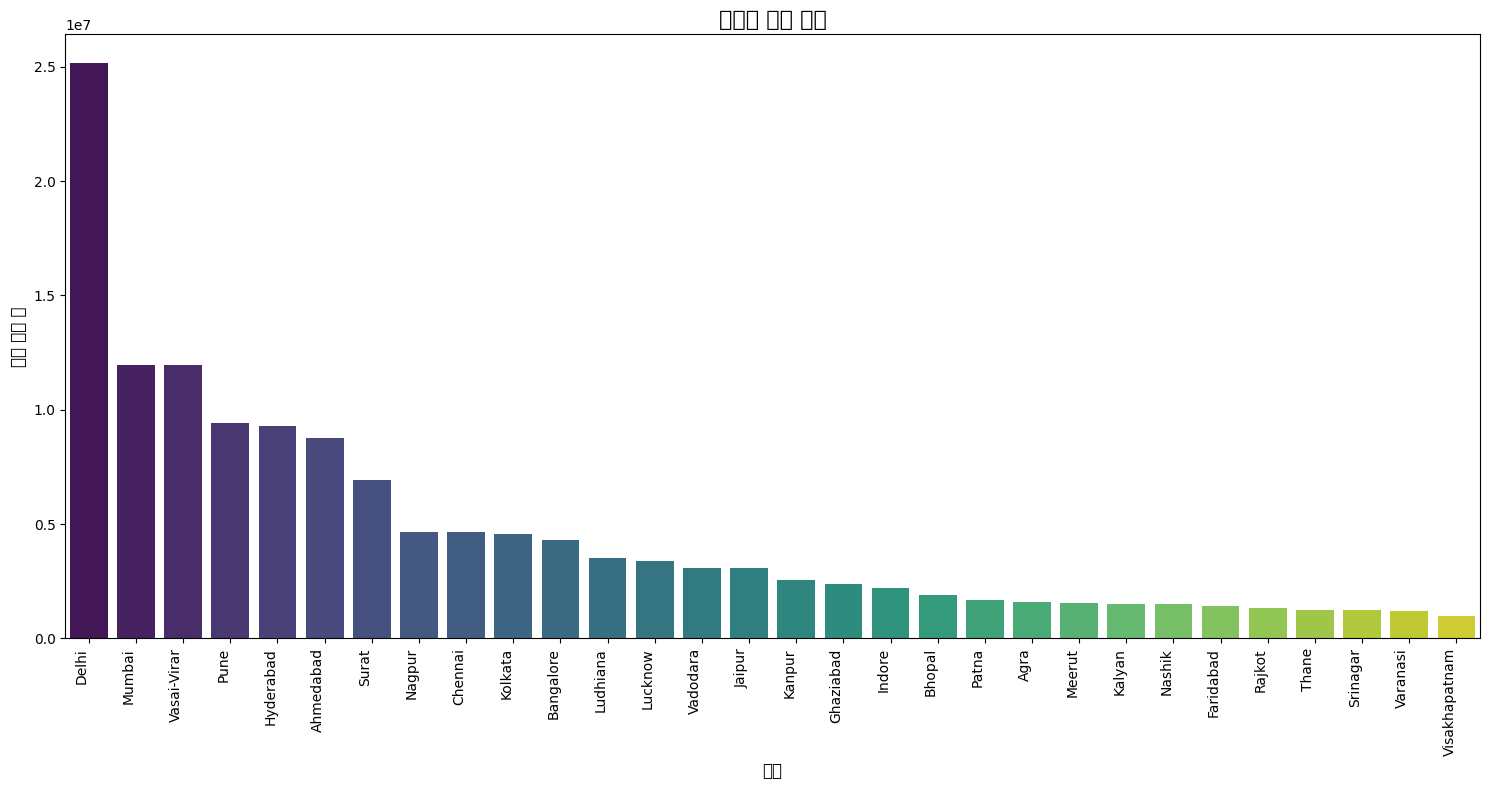

In [125]:
# 도시 별 population 순위를 시각화해줘

# 도시별 평균 인구 수를 계산하고 인구 순위대로 정렬합니다.
city_population_rank = df_train.groupby('City')['Population'].mean().sort_values(ascending=False)

# 시각화
plt.figure(figsize=(15, 8)) # 그래프 크기 설정
sns.barplot(x=city_population_rank.index, y=city_population_rank.values, palette='viridis') # viridis 색상 팔레트 사용
plt.title('도시별 인구 순위', fontsize=16) # 그래프 제목
plt.xlabel('도시', fontsize=12) # x축 라벨
plt.ylabel('평균 인구 수', fontsize=12) # y축 라벨
plt.xticks(rotation=90, ha='right', fontsize=10) # x축 텍스트 90도 회전 및 정렬
plt.tight_layout() # 레이아웃 조정
plt.show() # 그래프 표시


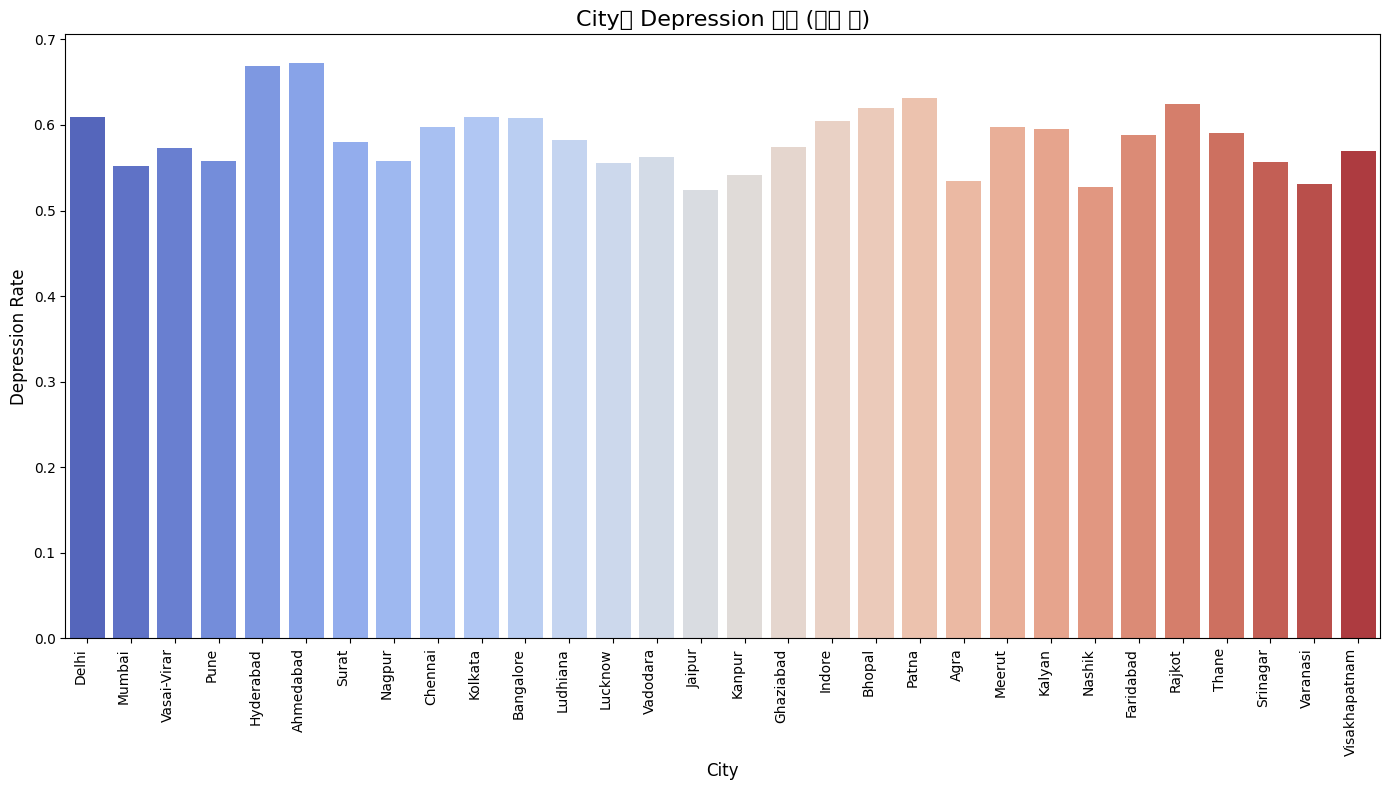

In [126]:
# City 별 Depression 비율을 population 순으로 시각화

# 도시별 우울증 비율 계산
city_depression_rate = df_train.groupby('City')['Depression'].value_counts(normalize=True).unstack()[1]

# 도시별 평균 인구 수 계산
city_population = df_train.groupby('City')['Population'].mean()

# 두 시리즈를 하나의 데이터프레임으로 합칩니다.
df_city_stats = pd.DataFrame({
    'Depression_Rate': city_depression_rate,
    'Population': city_population
}).dropna() # 결측치가 있는 도시는 제외합니다.

# 인구 수(Population)를 기준으로 내림차순으로 정렬합니다.
df_city_stats_sorted = df_city_stats.sort_values(by='Population', ascending=False)

# 시각화 (Seaborn barplot)
plt.figure(figsize=(14, 8))
sns.barplot(x=df_city_stats_sorted.index, y=df_city_stats_sorted['Depression_Rate'], palette='coolwarm')
plt.title('City별 Depression 비율 (인구 순)', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Depression Rate', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.tight_layout()
plt.show()


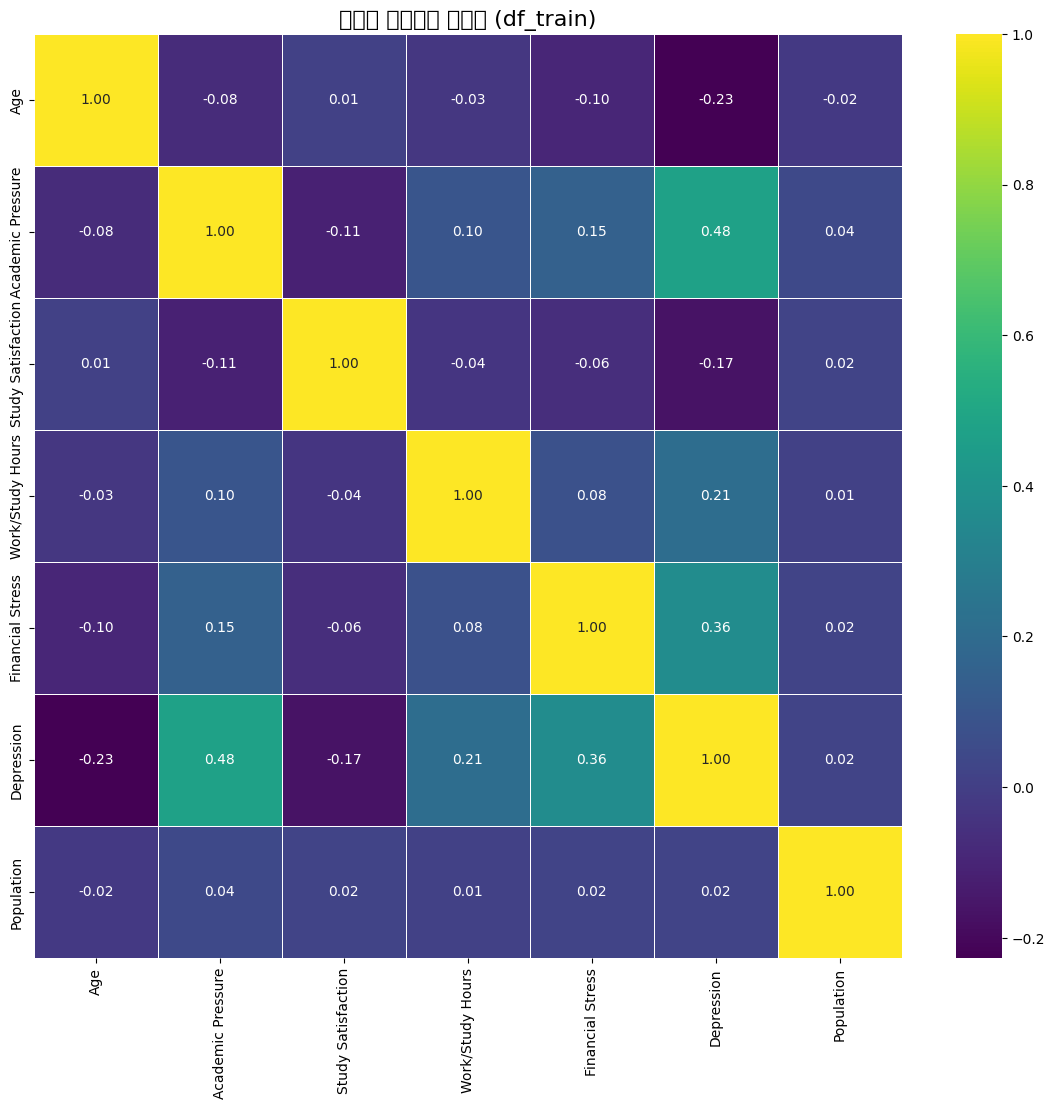

In [127]:
# 컬럼별 상관관계 히트맵 생성

# 상관관계 행렬 계산 (수치형 데이터만)
correlation_matrix_students = df_train.corr(numeric_only=True)

# 히트맵 시각화
plt.figure(figsize=(14, 12)) # 히트맵 크기 설정
sns.heatmap(correlation_matrix_students,
            annot=True,      # 각 셀에 상관계수 값 표시
            cmap='viridis',  # 색상 팔레트 설정 (viridis, coolwarm, plasma 등)
            fmt=".2f",       # 소수점 둘째 자리까지 표시
            linewidths=.5)   # 셀 경계선 두께 설정

plt.title('컬럼별 상관관계 히트맵 (df_train)', fontsize=16) # 그래프 제목
plt.show() # 그래프 표시

In [129]:
df_train

,Age,City,Working Professional or Student,Profession,Academic Pressure,Study Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Depression,Population_x,Population_y
0,33.0,Visakhapatnam,Student,NaN,5.0,2.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,1,982904.0,982904.0
1,24.0,Bangalore,Student,NaN,2.0,5.0,5-6 hours,Moderate,BSc,No,3.0,2.0,0,4301326.0,4301326.0
2,31.0,Srinagar,Student,NaN,3.0,5.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,0,1236829.0,NaN
3,28.0,Varanasi,Student,NaN,3.0,2.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,1,1198491.0,1198491.0
4,25.0,Jaipur,Student,NaN,4.0,3.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,0,3073350.0,3073350.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27874,27.0,Surat,Student,NaN,5.0,5.0,5-6 hours,Unhealthy,Class 12,Yes,7.0,1.0,0,6936534.0,6936534.0
27875,27.0,Ludhiana,Student,NaN,2.0,3.0,Less than 5 hours,Healthy,MSc,No,0.0,3.0,0,3498739.0,NaN
27876,31.0,Faridabad,Student,NaN,3.0,4.0,5-6 hours,Unhealthy,MD,No,12.0,2.0,0,1404653.0,1404653.0
27877,18.0,Ludhiana,Student,NaN,5.0,2.0,Less than 5 hours,Healthy,Class 12,Yes,10.0,5.0,1,3498739.0,NaN


In [131]:
# prompt: df_train에 City를 기준으로 Population 컬럼만 추가해줄 수 있어? df_train에는 City 데이터만 있어서 Population 전체 데이터가 필요해

# df_train에 Population 컬럼 추가 (City를 기준으로 merge)
# df_filtered_cities_matched 데이터프레임은 이미 생성되어 City와 Population 정보를 담고 있습니다.

# df_train과 df_filtered_cities_matched를 'City' 컬럼을 기준으로 left merge 합니다.
# left merge를 사용하면 df_train의 모든 행을 유지하고, df_filtered_cities_matched에
# 해당하는 City가 있는 경우에만 Population 정보를 추가합니다.
# 만약 df_filtered_cities_matched에 해당 City가 없는 경우, Population 값은 NaN이 됩니다.
df_train = pd.merge(df_train, df_filtered_cities_matched[['City', 'Population']], on='City', how='left')

# 매치가 안 된 도시들의 Population 정보를 딕셔너리 형태로 정의
# 이 정보는 df_train를 업데이트할 때 사용했지만, df_train에도 동일하게 적용합니다.
unmatched_cities_population = {
  'Delhi': 25162000,
  'Vasai-Virar': 11978450,
  'Kalyan': 1518762,
  'Ahmedabad': 8772000,
  'Srinagar': 1236829,
  'Chennai': 4646732,
  'Pune': 9429408,
  'Nagpur': 4653570,
  'Ludhiana': 3498739
}

# df_train DataFrame에 'Population' 컬럼이 이미 merge로 추가되었는지 확인하고,
# merge 후에도 NaN 값이 남아있는 경우 (즉, df_filtered_cities_matched에 없었던 도시)
# unmatched_cities_population 딕셔너리의 정보를 사용하여 업데이트합니다.
# 이전에 merge를 했기 때문에 Population 컬럼은 존재하지만, NaN 값을 가진 행들이 있을 수 있습니다.
for city, population in unmatched_cities_population.items():
  # df_train에서 해당 City이고 Population이 NaN인 행을 찾아서 Population 값을 업데이트
  df_train.loc[(df_train['City'] == city) & (df_train['Population'].isna()), 'Population'] = population


print("\nPopulation 정보가 추가된 df_train DataFrame:")
print(df_train.head())

# Population 컬럼에 결측치가 있는지 최종 확인
print("\n'Population' 컬럼의 최종 결측치 개수:")
print(df_train['Population'].isnull().sum())

# Population 컬럼의 데이터 타입 확인
print("\n'Population' 컬럼의 최종 데이터 타입:")
print(df_train['Population'].dtype)

# Population 컬럼의 통계 정보 확인
print("\n'Population' 컬럼의 최종 통계 정보:")
print(df_train['Population'].describe())



Population 정보가 추가된 df_train DataFrame:
    Age           City Working Professional or Student Profession  \
0  33.0  Visakhapatnam                         Student        NaN   
1  24.0      Bangalore                         Student        NaN   
2  31.0       Srinagar                         Student        NaN   
3  28.0       Varanasi                         Student        NaN   
4  25.0         Jaipur                         Student        NaN   

   Academic Pressure  Study Satisfaction     Sleep Duration Dietary Habits  \
0                5.0                 2.0          5-6 hours        Healthy   
1                2.0                 5.0          5-6 hours       Moderate   
2                3.0                 5.0  Less than 5 hours        Healthy   
3                3.0                 2.0          7-8 hours       Moderate   
4                4.0                 3.0          5-6 hours       Moderate   

    Degree Have you ever had suicidal thoughts ?  Work/Study Hours  \
0  B.P

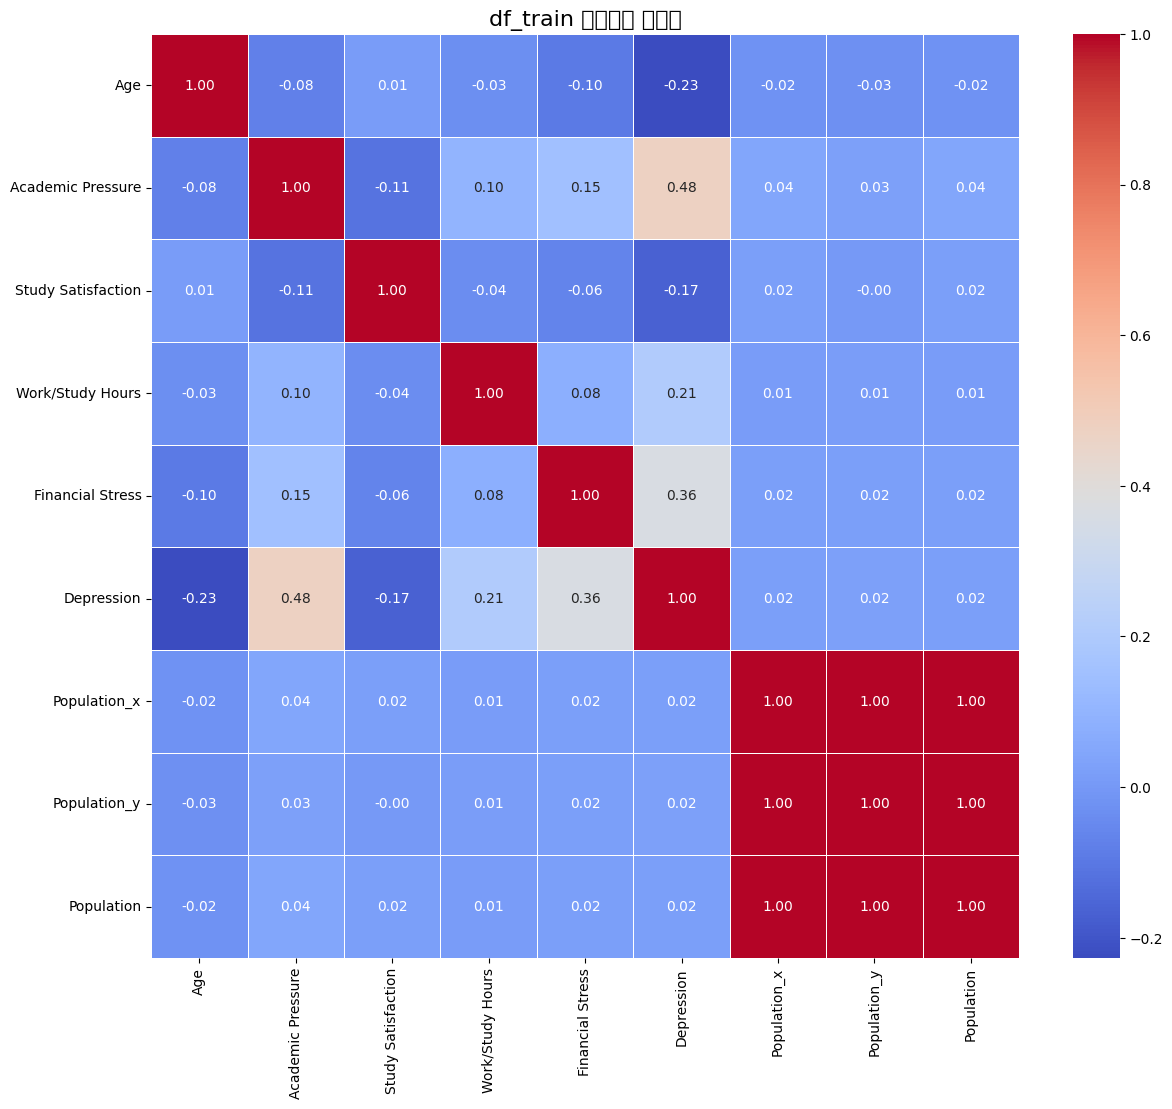

In [132]:
# prompt: df_train의 상관관계 히트맵

# df_train DataFrame의 수치형 피쳐 간의 상관 행렬 계산
# .corr() 메소드는 DataFrame의 모든 수치형 컬럼 간의 pairwise 상관관계를 계산합니다.
correlation_matrix_train = df_train.corr(numeric_only=True)

# 상관 행렬을 히트맵으로 시각화
plt.figure(figsize=(14, 12)) # 히트맵 크기 설정 (원하는 크기로 조절 가능)
sns.heatmap(correlation_matrix_train,
            annot=True, # 각 셀에 상관계수 값 표시
            cmap='coolwarm', # 색상 팔레트 설정 ('coolwarm', 'viridis', 'plasma' 등 사용 가능)
            fmt=".2f", # 소수점 둘째 자리까지 표시
            linewidths=.5) # 셀 경계선 두께 설정

plt.title('df_train 상관관계 히트맵', fontsize=16) # 그래프 제목 설정
plt.show() # 그래프 표시

Corrected City and 2011 Population DataFrame:
        City  Population
0     Mumbai    12442373
1      Delhi    11034555
2  Bengaluru     8443675
3  Hyderabad     6993262
4  Ahmedabad     5577940

Corrected DataFrame shape: (41, 2)

Merged df_train DataFrame with Corrected 2011 Population:
    Age           City Working Professional or Student Profession  \
0  33.0  Visakhapatnam                         Student        NaN   
1  24.0      Bangalore                         Student        NaN   
2  31.0       Srinagar                         Student        NaN   
3  28.0       Varanasi                         Student        NaN   
4  25.0         Jaipur                         Student        NaN   

   Academic Pressure  Study Satisfaction     Sleep Duration Dietary Habits  \
0                5.0                 2.0          5-6 hours        Healthy   
1                2.0                 5.0          5-6 hours       Moderate   
2                3.0                 5.0  Less than 5 hours 

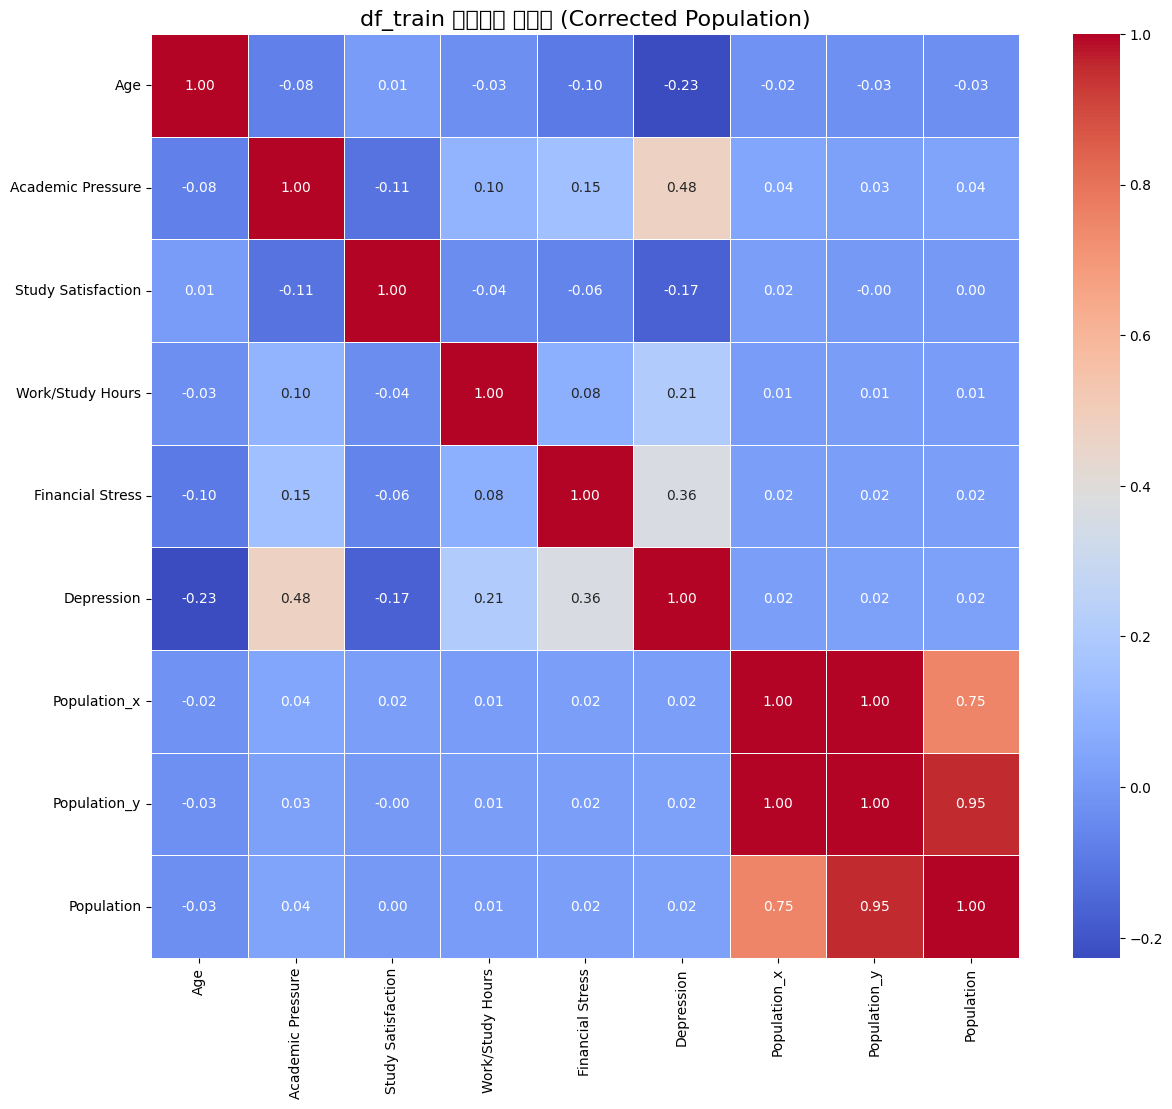

In [133]:
# prompt: Population 데이터가 잘못되었어.
# List of cities with population above 1,000,000
# City	Population
# (2011)[3]	Population
# (2001)[3][a]	State or union
# territory	Reference
# Mumbai	12,442,373	11,978,450	Maharashtra	[3]
# Delhi	11,034,555	9,879,172	Delhi	[3]
# Bengaluru	8,443,675	5,682,293	Karnataka	[3]
# Hyderabad	6,993,262	5,496,960	Telangana	[3]
# Ahmedabad	5,577,940	4,470,006	Gujarat	[3]
# Chennai	4,646,732	4,343,645	Tamil Nadu	[3]
# Kolkata	4,496,694	4,580,546	West Bengal	[3]
# Surat	4,467,797	2,788,126	Gujarat	[3]
# Pune	3,124,458	2,538,473	Maharashtra	[3]
# Jaipur	3,046,163	2,322,575	Rajasthan	[3]
# Lucknow	2,817,105	2,185,927	Uttar Pradesh	[3]
# Kanpur	2,765,348	2,551,337	Uttar Pradesh	[3]
# Nagpur	2,405,665	2,052,066	Maharashtra	[3]
# Indore	1,964,086	1,503,237	Madhya Pradesh	[3]
# Thane	1,841,488	1,262,551	Maharashtra	[3]
# Bhopal	1,798,218	1,458,416	Madhya Pradesh	[3]
# Visakhapatnam	1,728,128	1,345,938	Andhra Pradesh	[3][b]
# Pimpri-Chinchwad	1,727,692	1,020,448	Maharashtra	[3]
# Patna	1,684,222	1,431,477	Bihar	[3]
# Vadodara	1,670,806	1,338,244	Gujarat	[3]
# Ghaziabad	1,648,643	968,256	Uttar Pradesh	[3]
# Ludhiana	1,618,879	1,398,467	Punjab	[3]
# Agra	1,585,704	1,275,134	Uttar Pradesh	[3]
# Nashik	1,486,053	1,077,236	Maharashtra	[3]
# Faridabad	1,414,050	1,055,938	Haryana	[3]
# Meerut	1,305,429	1,068,772	Uttar Pradesh	[3]
# Rajkot	1,286,678	967,476	Gujarat	[3]
# Kalyan-Dombivli	1,247,327	1,193,512	Maharashtra	[3]
# Vasai-Virar	1,222,390	518,601	Maharashtra	[3]
# Varanasi	1,198,491	1,103,952	Uttar Pradesh	[3]
# Srinagar	1,180,570	935,764	Jammu and Kashmir	[3]
# Aurangabad	1,175,116	873,311	Maharashtra	[3]
# Dhanbad	1,162,472	1,031,523	Jharkhand	[3]
# Amritsar	1,132,383	979,801	Punjab	[3]
# Navi Mumbai	1,120,547	704,002	Maharashtra	[3]
# Prayagraj	1,112,544	975,393	Uttar Pradesh	[3]
# Howrah	1,077,075	1,007,532	West Bengal	[3]
# Ranchi	1,073,427	847,093	Jharkhand	[3]
# Jabalpur	1,055,525	951,472	Madhya Pradesh	[3]
# Gwalior	1,054,420	827,026	Madhya Pradesh	[3]
# Coimbatore	1,050,721	930,882	Tamil Nadu	[3]
# 이 데이터를 기준으로 수정해줘 2011년 population을 사용해줘

# Provided population data for cities
city_population_data = """
Mumbai	12,442,373	11,978,450	Maharashtra
Delhi	11,034,555	9,879,172	Delhi
Bengaluru	8,443,675	5,682,293	Karnataka
Hyderabad	6,993,262	5,496,960	Telangana
Ahmedabad	5,577,940	4,470,006	Gujarat
Chennai	4,646,732	4,343,645	Tamil Nadu
Kolkata	4,496,694	4,580,546	West Bengal
Surat	4,467,797	2,788,126	Gujarat
Pune	3,124,458	2,538,473	Maharashtra
Jaipur	3,046,163	2,322,575	Rajasthan
Lucknow	2,817,105	2,185,927	Uttar Pradesh
Kanpur	2,765,348	2,551,337	Uttar Pradesh
Nagpur	2,405,665	2,052,066	Maharashtra
Indore	1,964,086	1,503,237	Madhya Pradesh
Thane	1,841,488	1,262,551	Maharashtra
Bhopal	1,798,218	1,458,416	Madhya Pradesh
Visakhapatnam	1,728,128	1,345,938	Andhra Pradesh
Pimpri-Chinchwad	1,727,692	1,020,448	Maharashtra
Patna	1,684,222	1,431,477	Bihar
Vadodara	1,670,806	1,338,244	Gujarat
Ghaziabad	1,648,643	968,256	Uttar Pradesh
Ludhiana	1,618,879	1,398,467	Punjab
Agra	1,585,704	1,275,134	Uttar Pradesh
Nashik	1,486,053	1,077,236	Maharashtra
Faridabad	1,414,050	1,055,938	Haryana
Meerut	1,305,429	1,068,772	Uttar Pradesh
Rajkot	1,286,678	967,476	Gujarat
Kalyan-Dombivli	1,247,327	1,193,512	Maharashtra
Vasai-Virar	1,222,390	518,601	Maharashtra
Varanasi	1,198,491	1,103,952	Uttar Pradesh
Srinagar	1,180,570	935,764	Jammu and Kashmir
Aurangabad	1,175,116	873,311	Maharashtra
Dhanbad	1,162,472	1,031,523	Jharkhand
Amritsar	1,132,383	979,801	Punjab
Navi Mumbai	1,120,547	704,002	Maharashtra
Prayagraj	1,112,544	975,393	Uttar Pradesh
Howrah	1,077,075	1,007,532	West Bengal
Ranchi	1,073,427	847,093	Jharkhand
Jabalpur	1,055,525	951,472	Madhya Pradesh
Gwalior	1,054,420	827,026	Madhya Pradesh
Coimbatore	1,050,721	930,882	Tamil Nadu
"""

# Split the string into lines and process each line
lines = city_population_data.strip().split('\n')

# Create a list of dictionaries to store the data
data = []
for line in lines:
  # Split by tabs
  parts = line.split('\t')
  if len(parts) >= 2: # Ensure there are enough columns
    city = parts[0].strip()
    # Use the 2011 population which is the second column (index 1)
    population_2011_str = parts[1].strip().replace(',', '')
    try:
      population_2011 = int(population_2011_str)
      data.append({'City': city, 'Population': population_2011})
    except ValueError:
      print(f"Skipping line due to invalid population for 2011: {line}")
      continue

# Create a DataFrame from the extracted data
df_correct_population = pd.DataFrame(data)

print("Corrected City and 2011 Population DataFrame:")
print(df_correct_population.head())
print(f"\nCorrected DataFrame shape: {df_correct_population.shape}")

# Merge df_train with df_correct_population on the 'City' column
# We'll replace the existing 'Population' column if it exists, or add it if not.
# Using 'left' merge ensures all rows from df_train are kept.
df_train = pd.merge(df_train.drop('Population', axis=1, errors='ignore'), # Drop existing Population if it exists
                    df_correct_population,
                    on='City',
                    how='left')

print("\nMerged df_train DataFrame with Corrected 2011 Population:")
print(df_train.head())

# Check for missing Population values after the merge
print("\n'Population' column's final missing values count:")
print(df_train['Population'].isnull().sum())

# Check the data type of the Population column
print("\n'Population' column's final data type:")
print(df_train['Population'].dtype)

# Check the statistical summary of the Population column
print("\n'Population' column's final statistical summary:")
print(df_train['Population'].describe())

# Now, you can perform the correlation heatmap calculation again
# df_train DataFrame의 수치형 피쳐 간의 상관 행렬 계산
correlation_matrix_train = df_train.corr(numeric_only=True)

# 상관 행렬을 히트맵으로 시각화
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix_train,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=.5)

plt.title('df_train 상관관계 히트맵 (Corrected Population)', fontsize=16)
plt.show()



Merged df_train DataFrame with Corrected 2011 Population:
    Age           City Working Professional or Student Profession  \
0  33.0  Visakhapatnam                         Student        NaN   
1  24.0      Bangalore                         Student        NaN   
2  31.0       Srinagar                         Student        NaN   
3  28.0       Varanasi                         Student        NaN   
4  25.0         Jaipur                         Student        NaN   

   Academic Pressure  Study Satisfaction     Sleep Duration Dietary Habits  \
0                5.0                 2.0          5-6 hours        Healthy   
1                2.0                 5.0          5-6 hours       Moderate   
2                3.0                 5.0  Less than 5 hours        Healthy   
3                3.0                 2.0          7-8 hours       Moderate   
4                4.0                 3.0          5-6 hours       Moderate   

    Degree Have you ever had suicidal thoughts ?  Work/St

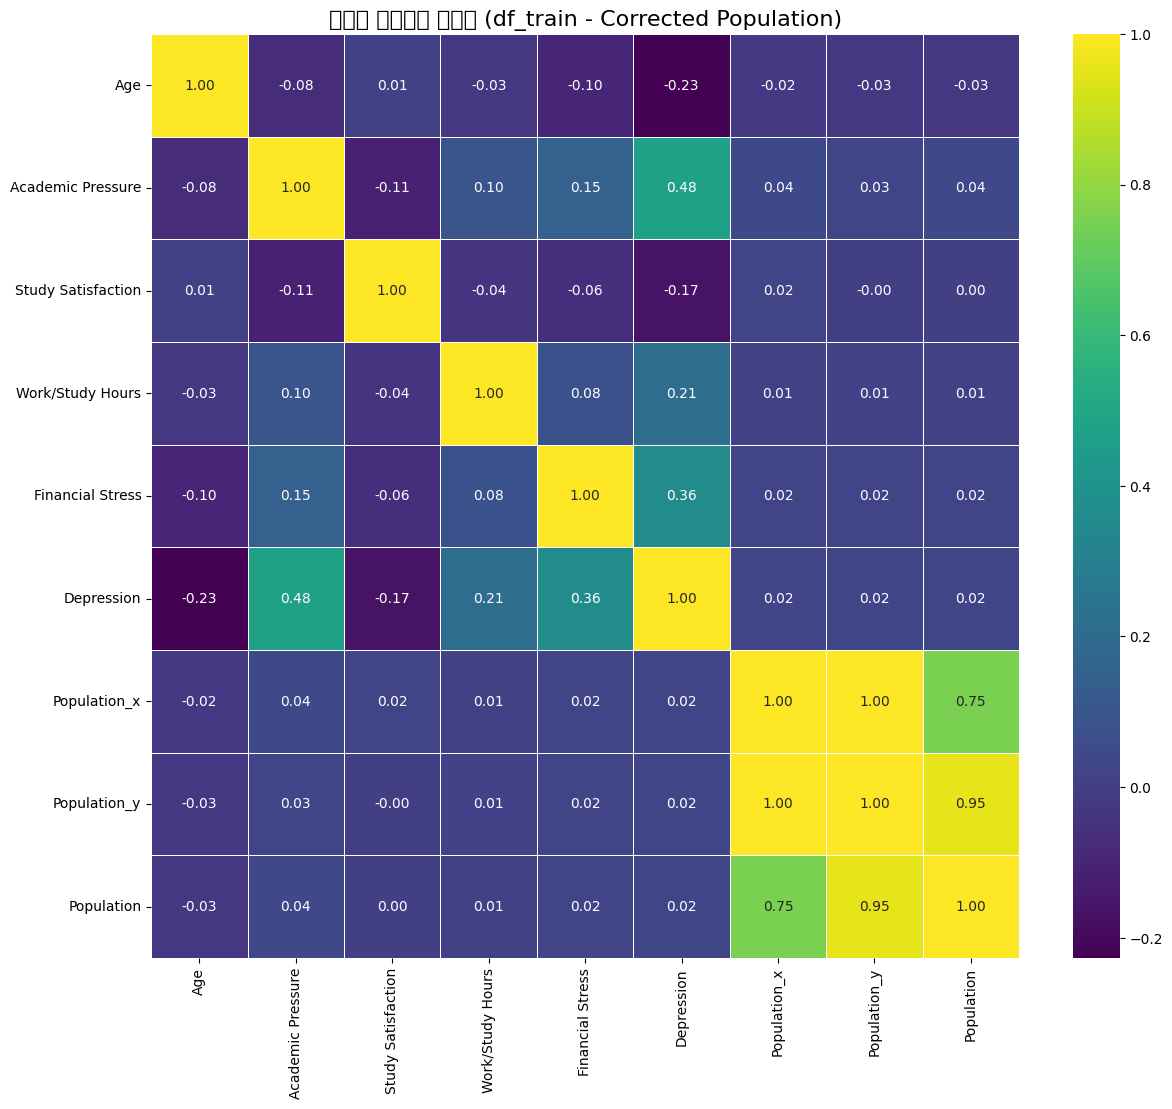

In [134]:
# prompt: df_train의 Population 데이터도 똑같이 수정해줘.

# Drop the existing 'Population' column from df_train if it exists
df_train = df_train.drop('Population', axis=1, errors='ignore')

# Merge df_train with df_correct_population on the 'City' column
# This will add the corrected 2011 population to the df_train DataFrame
df_train = pd.merge(df_train,
                       df_correct_population,
                       on='City',
                       how='left')

print("\nMerged df_train DataFrame with Corrected 2011 Population:")
print(df_train.head())

# Check for missing Population values in df_train after the merge
print("\n'Population' column in df_train final missing values count:")
print(df_train['Population'].isnull().sum())

# Check the data type of the Population column in df_train
print("\n'Population' column in df_train final data type:")
print(df_train['Population'].dtype)

# Check the statistical summary of the Population column in df_train
print("\n'Population' column in df_train final statistical summary:")
print(df_train['Population'].describe())

# Perform the correlation heatmap calculation for df_train again
# df_train DataFrame의 수치형 피쳐 간의 상관 행렬 계산
correlation_matrix_students = df_train.corr(numeric_only=True)

# 상관 행렬을 히트맵으로 시각화
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix_students,
            annot=True,
            cmap='viridis',
            fmt=".2f",
            linewidths=.5)

plt.title('컬럼별 상관관계 히트맵 (df_train - Corrected Population)', fontsize=16)
plt.show()

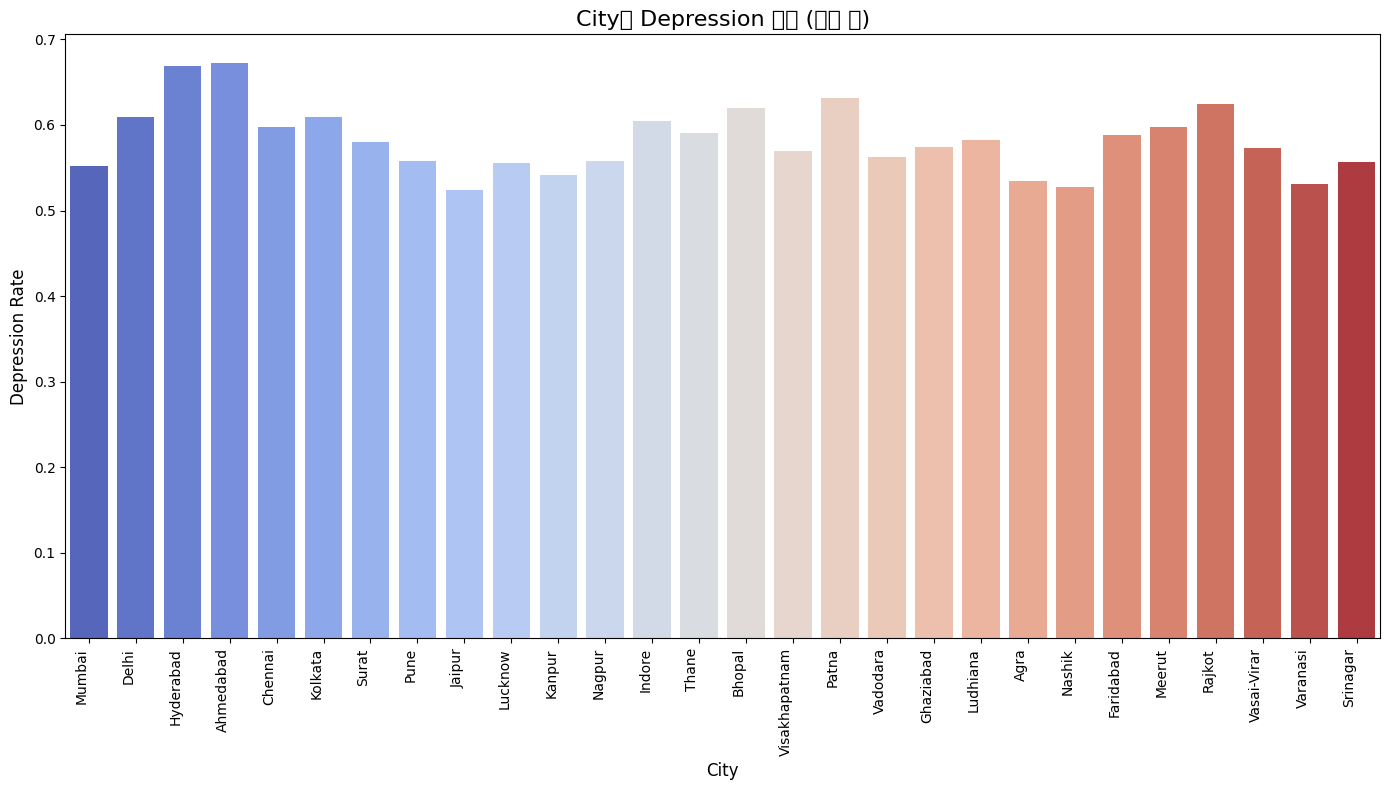

In [135]:
# City 별 Depression 비율을 population 순으로 시각화

# 도시별 우울증 비율 계산
city_depression_rate = df_train.groupby('City')['Depression'].value_counts(normalize=True).unstack()[1]

# 도시별 평균 인구 수 계산
city_population = df_train.groupby('City')['Population'].mean()

# 두 시리즈를 하나의 데이터프레임으로 합칩니다.
df_city_stats = pd.DataFrame({
    'Depression_Rate': city_depression_rate,
    'Population': city_population
}).dropna() # 결측치가 있는 도시는 제외합니다.

# 인구 수(Population)를 기준으로 내림차순으로 정렬합니다.
df_city_stats_sorted = df_city_stats.sort_values(by='Population', ascending=False)

# 시각화 (Seaborn barplot)
plt.figure(figsize=(14, 8))
sns.barplot(x=df_city_stats_sorted.index, y=df_city_stats_sorted['Depression_Rate'], palette='coolwarm')
plt.title('City별 Depression 비율 (인구 순)', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Depression Rate', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

In [136]:
df_train

,Age,City,Working Professional or Student,Profession,Academic Pressure,Study Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Depression,Population_x,Population_y,Population
0,33.0,Visakhapatnam,Student,NaN,5.0,2.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,1,982904.0,982904.0,1728128.0
1,24.0,Bangalore,Student,NaN,2.0,5.0,5-6 hours,Moderate,BSc,No,3.0,2.0,0,4301326.0,4301326.0,NaN
2,31.0,Srinagar,Student,NaN,3.0,5.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,0,1236829.0,NaN,1180570.0
3,28.0,Varanasi,Student,NaN,3.0,2.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,1,1198491.0,1198491.0,1198491.0
4,25.0,Jaipur,Student,NaN,4.0,3.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,0,3073350.0,3073350.0,3046163.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27874,27.0,Surat,Student,NaN,5.0,5.0,5-6 hours,Unhealthy,Class 12,Yes,7.0,1.0,0,6936534.0,6936534.0,4467797.0
27875,27.0,Ludhiana,Student,NaN,2.0,3.0,Less than 5 hours,Healthy,MSc,No,0.0,3.0,0,3498739.0,NaN,1618879.0
27876,31.0,Faridabad,Student,NaN,3.0,4.0,5-6 hours,Unhealthy,MD,No,12.0,2.0,0,1404653.0,1404653.0,1414050.0
27877,18.0,Ludhiana,Student,NaN,5.0,2.0,Less than 5 hours,Healthy,Class 12,Yes,10.0,5.0,1,3498739.0,NaN,1618879.0


In [137]:
cityGDP = pd.read_csv('cityGDP.csv')

In [138]:
cityGDP

,도시 (City),"GDP (2022-23, US$ 10억)",https://pplx-res.cloudinary.com/image/private/user_uploads/30889404/15a557e3-6e7a-449e-b37c-79bf7c43aa8b/seukeurinsyas-2025-06-03-ohu-12.28.02.jpg
0,Mumbai,168.36,~0.55
1,Delhi,129.09,~0.61
2,Bangalore,118.13,https://pplx-res.cloudinary.com/image/private/...
3,Chennai,96.18,~0.60
4,Hyderabad,84.13,~0.67
5,Kolkata,73.87,~0.61
6,Ahmedabad,66.80,~0.67
7,Pune,53.19,~0.56
8,Surat,44.49,~0.58
9,Visakhapatnam,21.86,~0.57


In [139]:
# prompt: 도시 (City)컬럼을 City로, GDP (2022-23, US$ 10억) 컬럼의 이름을 GDP로 바꿔줘

# 도시 (City) 컬럼의 이름을 City로 변경
cityGDP.rename(columns={'도시 (City)': 'City'}, inplace=True)

# GDP (2022-23, US$ 10억) 컬럼의 이름을 GDP로 변경
cityGDP.rename(columns={'GDP (2022-23, US$ 10억)': 'GDP'}, inplace=True)

print("컬럼 이름 변경 후 cityGDP DataFrame:")
print(cityGDP.head())

컬럼 이름 변경 후 cityGDP DataFrame:
        City     GDP  \
0     Mumbai  168.36   
1      Delhi  129.09   
2  Bangalore  118.13   
3    Chennai   96.18   
4  Hyderabad   84.13   

  https://pplx-res.cloudinary.com/image/private/user_uploads/30889404/15a557e3-6e7a-449e-b37c-79bf7c43aa8b/seukeurinsyas-2025-06-03-ohu-12.28.02.jpg  
0                                              ~0.55                                                                                                  
1                                              ~0.61                                                                                                  
2  https://pplx-res.cloudinary.com/image/private/...                                                                                                  
3                                              ~0.60                                                                                                  
4                                              ~0.67                  

In [140]:
cityGDP

,City,GDP,https://pplx-res.cloudinary.com/image/private/user_uploads/30889404/15a557e3-6e7a-449e-b37c-79bf7c43aa8b/seukeurinsyas-2025-06-03-ohu-12.28.02.jpg
0,Mumbai,168.36,~0.55
1,Delhi,129.09,~0.61
2,Bangalore,118.13,https://pplx-res.cloudinary.com/image/private/...
3,Chennai,96.18,~0.60
4,Hyderabad,84.13,~0.67
5,Kolkata,73.87,~0.61
6,Ahmedabad,66.80,~0.67
7,Pune,53.19,~0.56
8,Surat,44.49,~0.58
9,Visakhapatnam,21.86,~0.57


In [163]:
df_train = df_train.drop(['Population_x','Population_y'],axis = 1)

In [165]:
# prompt: City를 기준으로  df_train에 Merge해줘.

# cityGDP 데이터프레임에서 'City'와 'GDP' 컬럼만 선택
df_city_gdp_filtered = cityGDP[['City', 'GDP']].copy()

# df_train 데이터프레임과 df_city_gdp_filtered를 'City' 컬럼을 기준으로 left merge 합니다.
# df_train의 모든 행을 유지하고, 'City'가 일치하는 경우에만 'GDP' 정보를 추가합니다.
df_train = pd.merge(df_train, df_city_gdp_filtered, on='City', how='left')

print("\nCity를 기준으로 GDP 정보가 추가된 df_train DataFrame:")
print(df_train.head())

# Merge 후 'GDP' 컬럼에 결측치가 있는지 확인
print("\nMerge 후 'GDP' 컬럼의 결측치 개수:")
print(df_train['GDP'].isnull().sum())

# 'GDP' 컬럼의 데이터 타입 확인
print("\n'GDP' 컬럼의 데이터 타입:")
print(df_train['GDP'].dtype)

# 'GDP' 컬럼의 통계 정보 확인
print("\n'GDP' 컬럼의 통계 정보:")
print(df_train['GDP'].describe())

# GDP 컬럼과 다른 수치형 컬럼들 간의 상관관계 확인 (필요시)
correlation_matrix_students_with_gdp = ㅌㄹ.corr(numeric_only=True)

plt.figure(figsize=(15, 13))
sns.heatmap(correlation_matrix_students_with_gdp,
            annot=True,
            cmap='viridis',
            fmt=".2f",
            linewidths=.5)
plt.title('df_train 상관관계 히트맵 (GDP 포함)', fontsize=16)
plt.show()



City를 기준으로 GDP 정보가 추가된 df_train DataFrame:
    Age           City Working Professional or Student Profession  \
0  33.0  Visakhapatnam                         Student        NaN   
1  24.0      Bangalore                         Student        NaN   
2  31.0       Srinagar                         Student        NaN   
3  28.0       Varanasi                         Student        NaN   
4  25.0         Jaipur                         Student        NaN   

   Academic Pressure  Study Satisfaction     Sleep Duration Dietary Habits  \
0                5.0                 2.0          5-6 hours        Healthy   
1                2.0                 5.0          5-6 hours       Moderate   
2                3.0                 5.0  Less than 5 hours        Healthy   
3                3.0                 2.0          7-8 hours       Moderate   
4                4.0                 3.0          5-6 hours       Moderate   

    Degree Have you ever had suicidal thoughts ?  Work/Study Hours  \
0 

NameError: name 'ᄐᄅ' is not defined

In [142]:
# prompt: GDP 결측치가 있는 데이터의 City 컬럼만 추출해줘

# 'GDP' 컬럼에 결측치가 있는 데이터만 필터링
df_gdp_missing = df_train[df_train['GDP'].isnull()].copy()

# 필터링된 데이터프레임에서 'City' 컬럼만 추출
cities_with_missing_gdp = df_gdp_missing['City']

print("GDP 결측치가 있는 데이터의 City 컬럼:")
print(cities_with_missing_gdp)

# 또는 고유한 도시 이름만 보고 싶다면:
print("\nGDP 결측치가 있는 데이터의 고유한 City 목록:")
print(cities_with_missing_gdp.unique())

GDP 결측치가 있는 데이터의 City 컬럼:
2           Srinagar
3           Varanasi
6              Thane
12            Kalyan
14            Kalyan
            ...     
27852      Ghaziabad
27857         Kalyan
27860    Vasai-Virar
27869          Thane
27872       Srinagar
Name: City, Length: 6802, dtype: object

GDP 결측치가 있는 데이터의 고유한 City 목록:
['Srinagar' 'Varanasi' 'Thane' 'Kalyan' 'Ghaziabad' 'Vasai-Virar']


In [143]:
# prompt: 탄 (Thane), 칼리얀 (Kalyan), 바사이-비라르 (Vasai-Virar)는 Mumbai Metropolitan Region, MMR이야. 이에 df_train의 City 컬럼의 탄 (Thane), 칼리얀 (Kalyan), 바사이-비라르 (Vasai-Virar), Mumbai 를 MMR로 통합하고 Population과 GDP는 Mumbai에 해당하는 데이터로 덮어쓰기해줘.

# Mumbai Metropolitan Region (MMR)에 속하는 도시 목록 정의
mmr_cities = ['Thane', 'Kalyan', 'Vasai-Virar', 'Mumbai'] # df_train의 City 컬럼 값과 일치해야 함

# MMR 도시들을 'MMR'로 통합
df_train['City'] = df_train['City'].replace(mmr_cities, 'MMR')

# Mumbai의 Population과 GDP 값을 찾습니다.
# df_train에는 이미 Population과 GDP 컬럼이 존재한다고 가정합니다.
# Mumbai가 MMR로 대체되기 전에 원래 Mumbai 행의 Population과 GDP 값을 찾거나,
# 또는 외부 데이터 소스에서 정확한 Mumbai 값을 가져와야 합니다.
# 여기서는 편의상 MMR로 통합하기 전 df_train에 'Mumbai'가 있었고 그 값들을 사용한다고 가정합니다.
# 실제 작업에서는 MMR 전체의 인구와 GDP 합계를 사용하거나, Mumbai의 대표값을 사용해야 할 수 있습니다.
# 제공된 코드에는 Mumbai의 Population은 포함되어 있으나 GDP는 cityGDP 파일에서 찾아야 합니다.

# Mumbai의 Population 값을 찾습니다 (df_correct_population 사용).
mumbai_population = df_correct_population[df_correct_population['City'] == 'Mumbai']['Population'].values
if len(mumbai_population) > 0:
    mumbai_population_value = mumbai_population[0]
else:
    # Mumbai의 Population 값을 찾지 못한 경우 기본값 또는 오류 처리
    mumbai_population_value = np.nan
    print("Warning: Mumbai Population not found in df_correct_population.")


# Mumbai의 GDP 값을 찾습니다 (df_city_gdp_filtered 사용).
mumbai_gdp = df_city_gdp_filtered[df_city_gdp_filtered['City'] == 'Mumbai']['GDP'].values
if len(mumbai_gdp) > 0:
    mumbai_gdp_value = mumbai_gdp[0]
    # GDP 값이 문자열일 경우 숫자로 변환 시도
    if isinstance(mumbai_gdp_value, str):
        try:
            mumbai_gdp_value = float(mumbai_gdp_value.replace(',', '')) # 쉼표 제거 후 float으로 변환
        except ValueError:
            mumbai_gdp_value = np.nan
            print("Warning: Mumbai GDP value could not be converted to number.")
else:
    # Mumbai의 GDP 값을 찾지 못한 경우 기본값 또는 오류 처리
    mumbai_gdp_value = np.nan
    print("Warning: Mumbai GDP not found in df_city_gdp_filtered.")


# 'MMR'로 통합된 행들에 Mumbai의 Population과 GDP 값으로 덮어쓰기
if not np.isnan(mumbai_population_value):
    df_train.loc[df_train['City'] == 'MMR', 'Population'] = mumbai_population_value
else:
     print("Population for MMR not updated as Mumbai's value was not found.")

if not np.isnan(mumbai_gdp_value):
    df_train.loc[df_train['City'] == 'MMR', 'GDP'] = mumbai_gdp_value
else:
    print("GDP for MMR not updated as Mumbai's value was not found or convertible.")


print("\nMMR로 도시 통합 및 Population, GDP 업데이트 후 df_train DataFrame:")
print(df_train[df_train['City'] == 'MMR'].head()) # MMR로 통합된 행들 확인
print(f"\n'City' 컬럼의 고유값 개수: {df_train['City'].nunique()}")
print("\n'City' 컬럼의 고유값 목록:")
print(df_train['City'].unique())
print("\n'Population' 컬럼의 결측치 개수 (MMR 업데이트 후):")
print(df_train['Population'].isnull().sum())
print("\n'GDP' 컬럼의 결측치 개수 (MMR 업데이트 후):")
print(df_train['GDP'].isnull().sum())



MMR로 도시 통합 및 Population, GDP 업데이트 후 df_train DataFrame:
     Age City Working Professional or Student Profession  Academic Pressure  \
6   30.0  MMR                         Student        NaN                3.0   
12  27.0  MMR                         Student        NaN                5.0   
14  19.0  MMR                         Student        NaN                5.0   
19  25.0  MMR                         Student        NaN                3.0   
23  23.0  MMR                         Student        NaN                1.0   

    Study Satisfaction     Sleep Duration Dietary Habits    Degree  \
6                  4.0          7-8 hours        Healthy       BSc   
12                 1.0  Less than 5 hours       Moderate    M.Tech   
14                 5.0  Less than 5 hours       Moderate  Class 12   
19                 3.0          5-6 hours       Moderate      B.Ed   
23                 4.0          7-8 hours        Healthy       BHM   

   Have you ever had suicidal thoughts ?  Work/

In [144]:
# prompt: GDP 컬럼의 결측치가 있는 도시를 확인해줘

# 'GDP' 컬럼에 결측치가 있는 데이터만 필터링
df_gdp_missing_after_mmr = df_train[df_train['GDP'].isnull()].copy()

# 필터링된 데이터프레임에서 'City' 컬럼만 추출
cities_with_missing_gdp_after_mmr = df_gdp_missing_after_mmr['City']

print("GDP 결측치가 있는 데이터의 City 컬럼 (MMR 통합 후):")
print(cities_with_missing_gdp_after_mmr)

# 또는 고유한 도시 이름만 보고 싶다면:
print("\nGDP 결측치가 있는 데이터의 고유한 City 목록 (MMR 통합 후):")
print(cities_with_missing_gdp_after_mmr.unique())

GDP 결측치가 있는 데이터의 City 컬럼 (MMR 통합 후):
2         Srinagar
3         Varanasi
15        Srinagar
37        Srinagar
43       Ghaziabad
           ...    
27829     Varanasi
27841     Srinagar
27849     Srinagar
27852    Ghaziabad
27872     Srinagar
Name: City, Length: 2801, dtype: object

GDP 결측치가 있는 데이터의 고유한 City 목록 (MMR 통합 후):
['Srinagar' 'Varanasi' 'Ghaziabad']


In [145]:
# prompt: City 컬럼 기준 ['Srinagar':3.88, 'Varanasi':3.8,  'Ghaziabad':4.04]로 df_train의 GDP 컬럼의 결측치를 채워줘.

# City 컬럼 기준 특정 도시의 GDP 값으로 결측치 채우기
gdp_fill_values = {'Srinagar': 3.88, 'Varanasi': 3.8,  'Ghaziabad': 4.04}

# fillna를 사용하여 City 기준으로 결측치 채우기
# map 함수를 사용하여 City와 매핑되는 GDP 값을 찾고, fillna로 결측치를 채웁니다.
# map 함수는 해당하는 City가 없으면 NaN을 반환하므로, fillna가 정상적으로 작동합니다.
df_train['GDP'] = df_train['GDP'].fillna(df_train['City'].map(gdp_fill_values))

print("\n특정 도시의 GDP 값으로 결측치 채운 후 df_train DataFrame:")
print(df_train.head())

# GDP 컬럼에 결측치가 있는지 최종 확인
print("\n'GDP' 컬럼의 최종 결측치 개수:")
print(df_train['GDP'].isnull().sum())

# GDP 결측치가 있는 데이터의 고유한 City 목록 (업데이트 후)
print("\nGDP 결측치가 있는 데이터의 고유한 City 목록 (업데이트 후):")
print(df_train[df_train['GDP'].isnull()]['City'].unique())



특정 도시의 GDP 값으로 결측치 채운 후 df_train DataFrame:
    Age           City Working Professional or Student Profession  \
0  33.0  Visakhapatnam                         Student        NaN   
1  24.0      Bangalore                         Student        NaN   
2  31.0       Srinagar                         Student        NaN   
3  28.0       Varanasi                         Student        NaN   
4  25.0         Jaipur                         Student        NaN   

   Academic Pressure  Study Satisfaction     Sleep Duration Dietary Habits  \
0                5.0                 2.0          5-6 hours        Healthy   
1                2.0                 5.0          5-6 hours       Moderate   
2                3.0                 5.0  Less than 5 hours        Healthy   
3                3.0                 2.0          7-8 hours       Moderate   
4                4.0                 3.0          5-6 hours       Moderate   

    Degree Have you ever had suicidal thoughts ?  Work/Study Hours  \
0

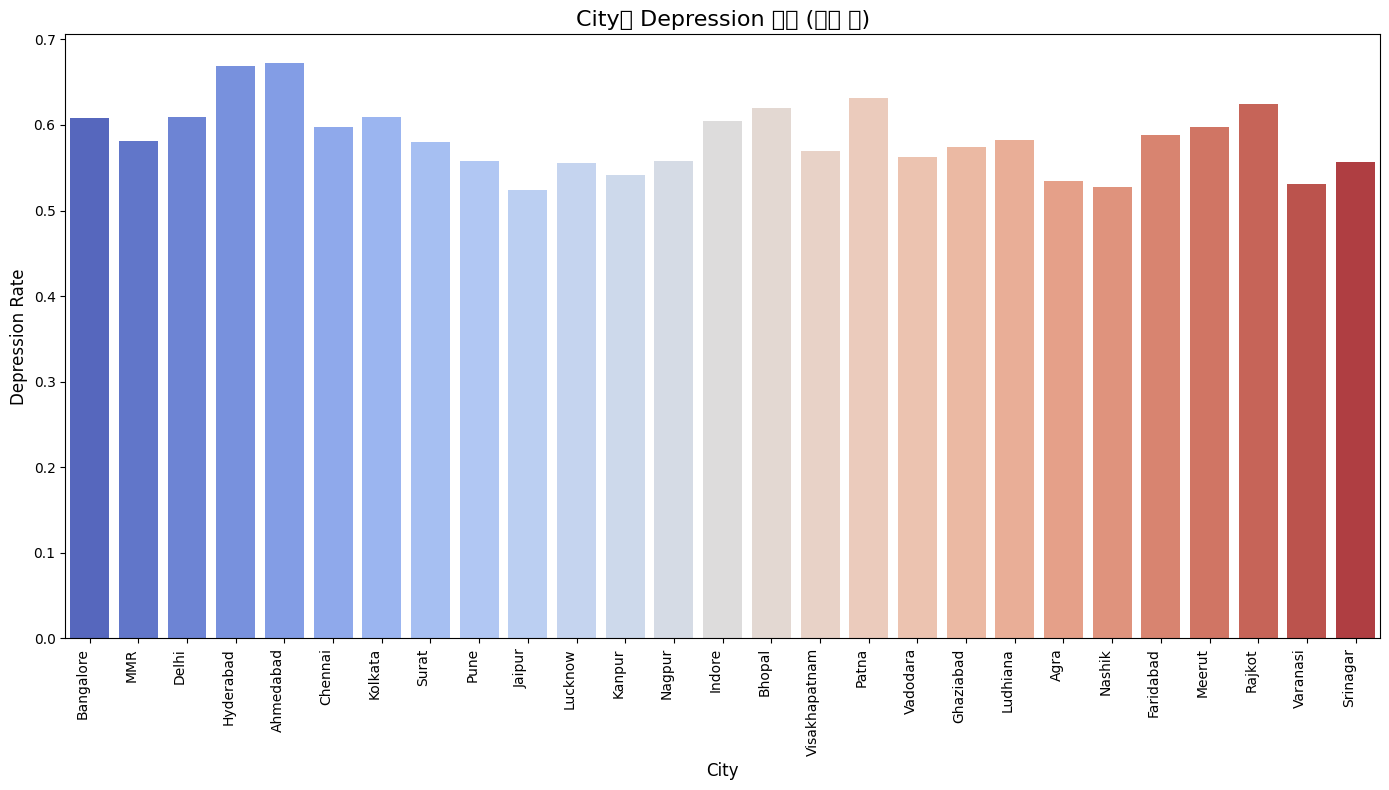

In [168]:
# City 별 Depression 비율을 population 순으로 시각화

# 도시별 우울증 비율 계산
city_depression_rate = df_train.groupby('City')['Depression'].value_counts(normalize=True).unstack()[1]

# 도시별 평균 인구 수 계산
city_population = df_train.groupby('City')['Population'].mean()

# 두 시리즈를 하나의 데이터프레임으로 합칩니다.
df_city_stats = pd.DataFrame({
    'Depression_Rate': city_depression_rate,
    'Population': city_population
}).dropna() # 결측치가 있는 도시는 제외합니다.

# 인구 수(Population)를 기준으로 내림차순으로 정렬합니다.
df_city_stats_sorted = df_city_stats.sort_values(by='Population', ascending=False)

# 시각화 (Seaborn barplot)
plt.figure(figsize=(14, 8))
sns.barplot(x=df_city_stats_sorted.index, y=df_city_stats_sorted['Depression_Rate'], palette='coolwarm')
plt.title('City별 Depression 비율 (인구 순)', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Depression Rate', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

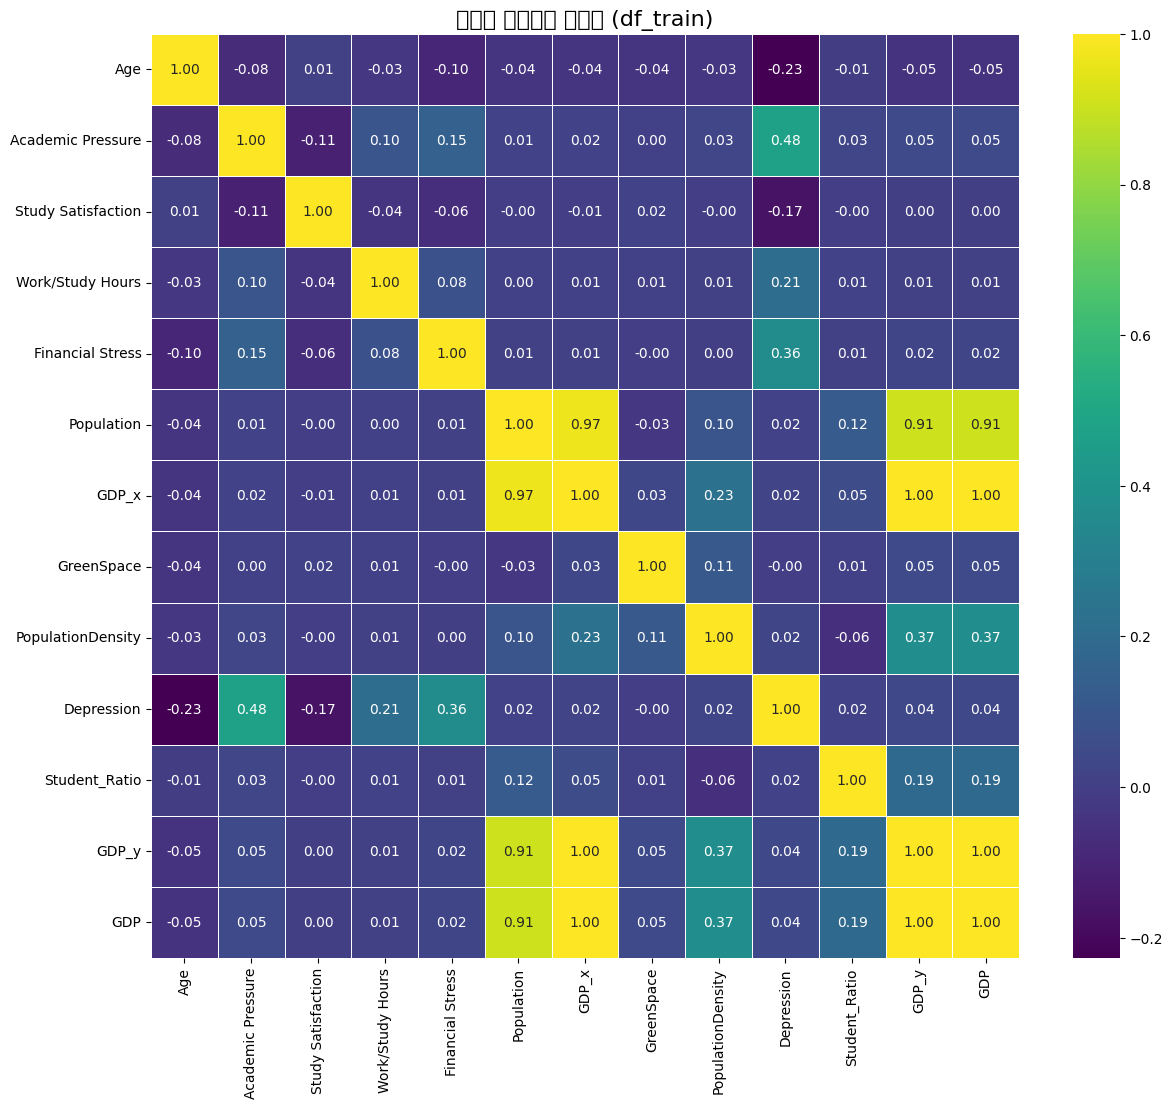

In [167]:
# prompt: df_train의 컬럼별 상관관계

# df_train DataFrame의 수치형 피쳐 간의 상관 행렬 계산
# .corr() 메소드는 DataFrame의 모든 수치형 컬럼 간의 pairwise 상관관계를 계산합니다.
correlation_matrix_students = df_train.corr(numeric_only=True)

# 상관 행렬을 히트맵으로 시각화
plt.figure(figsize=(14, 12)) # 히트맵 크기 설정 (원하는 크기로 조절 가능)
sns.heatmap(correlation_matrix_students,
            annot=True,      # 각 셀에 상관계수 값 표시
            cmap='viridis',  # 색상 팔레트 설정 (viridis, coolwarm, plasma 등)
            fmt=".2f",       # 소수점 둘째 자리까지 표시
            linewidths=.5)   # 셀 경계선 두께 설정

plt.title('컬럼별 상관관계 히트맵 (df_train)', fontsize=16) # 그래프 제목
plt.show() # 그래프 표시


In [149]:
green_space_per_capita = {
    'Ludhiana': 0.8,
    'Varanasi': 24.78,
    'Visakhapatnam': 0.18,
    'Mumbai': 9.36,
    'Kanpur': 1.3,
    'Ahmedabad': 9.38,
    'Thane': 35,
    'Nashik': 8,
    'Bangalore': 3.31,
    'Patna': 2,
    'Rajkot': 15,
    'Jaipur': 6.67,
    'Pune': 17,
    'Lucknow': 7,
    'Meerut': 3,
    'Agra': 18,
    'Surat': 5.90,
    'Faridabad': 3,
    'Hyderabad': 8.2,
    'Srinagar': 2.6,
    'Ghaziabad': 1.5,
    'Kolkata': 6.61,
    'Chennai': 18.05,
    'Kalyan': 2,
    'Nagpur': 17.49,
    'Vadodara': 8,
    'Vasai-Virar': 15,
    'Delhi': 10.41,
    'Bhopal': 18.62,
    'Indore': 20,
    'Morena': 30
}

population_density = {
    'Ludhiana': 9781,
    'Varanasi': 2367,
    'Visakhapatnam': 3900,
    'Mumbai': 20482,
    'Kanpur': 14449,
    'Ahmedabad': 11975,
    'Thane': 11500,
    'Nashik': 5872,
    'Bangalore': 4381,
    'Patna': 11667,
    'Rajkot': 10195,
    'Jaipur': 6491,
    'Pune': 6039,
    'Lucknow': 5459,
    'Meerut': 8493,
    'Agra': 11300,
    'Surat': 13600,
    'Faridabad': 9233,
    'Hyderabad': 10859,
    'Srinagar': 5283,
    'Ghaziabad': 10341,
    'Kolkata': 24306,
    'Chennai': 26903,
    'Kalyan': 11620,
    'Nagpur': 11470,
    'Vadodara': 8775,
    'Vasai-Virar': 9962,
    'Delhi': 11320,
    'Bhopal': 7154,
    'Indore': 11250,
    'Morena': 2340
}

df_train['GreenSpace'] = df_train['City'].map(green_space_per_capita)
df_train['PopulationDensity'] = df_train['City'].map(population_density)


df_train['GreenSpace'].fillna(df_train['GreenSpace'].mean(), inplace=True)
df_train['PopulationDensity'].fillna(df_train['PopulationDensity'].mean(), inplace=True)


In [150]:
df_train

,Age,City,Working Professional or Student,Profession,Academic Pressure,Study Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Depression,Population_x,Population_y,Population,GDP,GreenSpace,PopulationDensity
0,33.0,Visakhapatnam,Student,NaN,5.0,2.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,1,982904.0,982904.0,1728128.0,21.86,0.18,3900.0
1,24.0,Bangalore,Student,NaN,2.0,5.0,5-6 hours,Moderate,BSc,No,3.0,2.0,0,4301326.0,4301326.0,NaN,118.13,3.31,4381.0
2,31.0,Srinagar,Student,NaN,3.0,5.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,0,1236829.0,NaN,1180570.0,3.88,2.60,5283.0
3,28.0,Varanasi,Student,NaN,3.0,2.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,1,1198491.0,1198491.0,1198491.0,3.80,24.78,2367.0
4,25.0,Jaipur,Student,NaN,4.0,3.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,0,3073350.0,3073350.0,3046163.0,19.87,6.67,6491.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27874,27.0,Surat,Student,NaN,5.0,5.0,5-6 hours,Unhealthy,Class 12,Yes,7.0,1.0,0,6936534.0,6936534.0,4467797.0,44.49,5.90,13600.0
27875,27.0,Ludhiana,Student,NaN,2.0,3.0,Less than 5 hours,Healthy,MSc,No,0.0,3.0,0,3498739.0,NaN,1618879.0,12.60,0.80,9781.0
27876,31.0,Faridabad,Student,NaN,3.0,4.0,5-6 hours,Unhealthy,MD,No,12.0,2.0,0,1404653.0,1404653.0,1414050.0,9.28,3.00,9233.0
27877,18.0,Ludhiana,Student,NaN,5.0,2.0,Less than 5 hours,Healthy,Class 12,Yes,10.0,5.0,1,3498739.0,NaN,1618879.0,12.60,0.80,9781.0


In [151]:
# prompt: population의 NaN 행들의 개수를 알려줘. 그리고 그 행들의 City 컬럼을 뽑아줘

# Population 컬럼에서 결측치가 있는 행의 개수를 알려줘
nan_population_count = df_train['Population'].isnull().sum()

print(f"Population 컬럼의 NaN 행 개수: {nan_population_count}")

# Population 컬럼에서 결측치가 있는 행들의 'City' 컬럼 값들을 추출
cities_with_nan_population = df_train.loc[df_train['Population'].isnull(), 'City']

print("\nPopulation 컬럼에 NaN이 있는 행들의 City 컬럼 값:")
print(cities_with_nan_population)

# 또는 고유한 도시 이름만 보고 싶다면
print("\nPopulation 컬럼에 NaN이 있는 데이터의 고유한 City 목록:")
print(cities_with_nan_population.unique())

Population 컬럼의 NaN 행 개수: 766

Population 컬럼에 NaN이 있는 행들의 City 컬럼 값:
1        Bangalore
24       Bangalore
117      Bangalore
160      Bangalore
202      Bangalore
           ...    
27268    Bangalore
27296    Bangalore
27375    Bangalore
27675    Bangalore
27682    Bangalore
Name: City, Length: 766, dtype: object

Population 컬럼에 NaN이 있는 데이터의 고유한 City 목록:
['Bangalore']


In [172]:
# prompt: Bangalore의 Population NaN을 13,193,000으로 채워줘.

df_train.loc[df_train['City'] == 'Bangalore', 'Population'] = 13193000

# 변경사항 확인 (Bangalore 행만 필터링하여 출력)
print("Bangalore의 Population이 업데이트된 후:")
print(df_train[df_train['City'] == 'Bangalore'][['City', 'Population']])

# 전체 Population 컬럼에 결측치가 있는지 다시 확인
print("\n업데이트 후 'Population' 컬럼의 결측치 개수:")
print(df_train['Population'].isnull().sum())


SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<ipython-input-172-89d477cd10d9>, line 3)

In [169]:
# prompt: city 별 population 개수 측정

# 도시별 개체 수 계산
city_population_counts = df_train['City'].value_counts().reset_index()
city_population_counts.columns = ['City', 'Population_Count']

print("도시별 개체 수 (Population_Count):")
city_population_counts


도시별 개체 수 (Population_Count):


,City,Population_Count
0,MMR,4700
1,Srinagar,1371
2,Hyderabad,1340
3,Lucknow,1154
4,Ludhiana,1111
5,Agra,1095
6,Surat,1080
7,Kolkata,1067
8,Jaipur,1036
9,Patna,1007


In [171]:
df_city_stats_sorted

,Depression_Rate,Population
City,,
Bangalore,0.608355,13193000.0
MMR,0.581702,12442373.0
Delhi,0.609375,11034555.0
Hyderabad,0.669403,6993262.0
Ahmedabad,0.672287,5577940.0
Chennai,0.597285,4646732.0
Kolkata,0.609185,4496694.0
Surat,0.579630,4467797.0
Pune,0.558308,3124458.0


In [173]:
# prompt: City가 Bangalore인 데이터의 Population을 8,436,675으로 전체 수정해줘.

df_train.loc[df_train['City'] == 'Bangalore', 'Population'] = 8436675

# 변경사항 확인 (Bangalore 행만 필터링하여 출력)
print("Bangalore의 Population이 업데이트된 후:")
print(df_train[df_train['City'] == 'Bangalore'][['City', 'Population']])

# 전체 Population 컬럼에 결측치가 있는지 다시 확인
print("\n업데이트 후 'Population' 컬럼의 결측치 개수:")
print(df_train['Population'].isnull().sum())


Bangalore의 Population이 업데이트된 후:
            City  Population
1      Bangalore   8436675.0
24     Bangalore   8436675.0
117    Bangalore   8436675.0
160    Bangalore   8436675.0
202    Bangalore   8436675.0
...          ...         ...
27268  Bangalore   8436675.0
27296  Bangalore   8436675.0
27375  Bangalore   8436675.0
27675  Bangalore   8436675.0
27682  Bangalore   8436675.0

[766 rows x 2 columns]

업데이트 후 'Population' 컬럼의 결측치 개수:
0


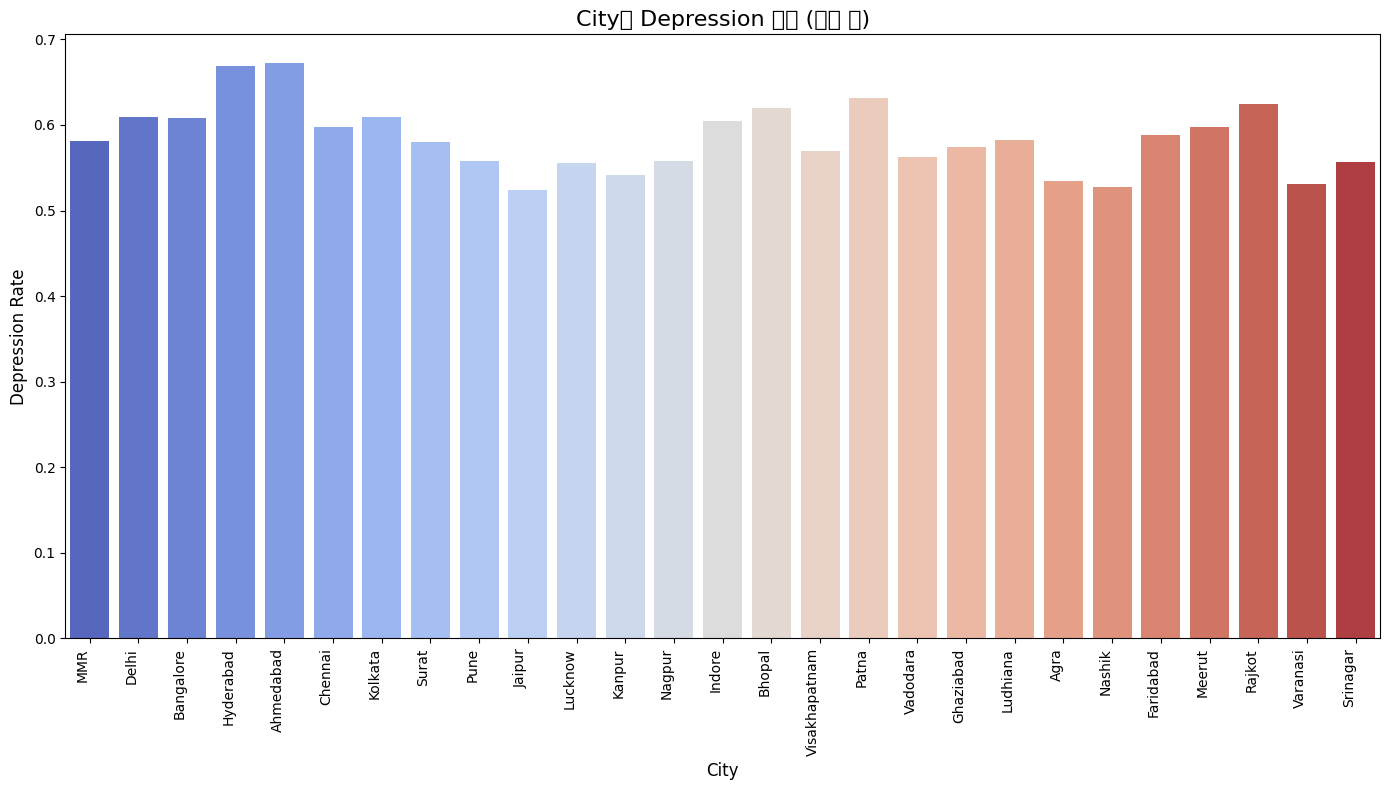

In [174]:
# City 별 Depression 비율을 population 순으로 시각화

# 도시별 우울증 비율 계산
city_depression_rate = df_train.groupby('City')['Depression'].value_counts(normalize=True).unstack()[1]

# 도시별 평균 인구 수 계산
city_population = df_train.groupby('City')['Population'].mean()

# 두 시리즈를 하나의 데이터프레임으로 합칩니다.
df_city_stats = pd.DataFrame({
    'Depression_Rate': city_depression_rate,
    'Population': city_population
}).dropna() # 결측치가 있는 도시는 제외합니다.

# 인구 수(Population)를 기준으로 내림차순으로 정렬합니다.
df_city_stats_sorted = df_city_stats.sort_values(by='Population', ascending=False)

# 시각화 (Seaborn barplot)
plt.figure(figsize=(14, 8))
sns.barplot(x=df_city_stats_sorted.index, y=df_city_stats_sorted['Depression_Rate'], palette='coolwarm')
plt.title('City별 Depression 비율 (인구 순)', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Depression Rate', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

In [185]:
# prompt: city 별 population을 높은 순서대로 뽑아줘

# 도시별 평균 인구 수를 계산하고 인구 순위대로 정렬합니다.
city_population_rank = df_train.groupby('City')['Population'].mean().sort_values(ascending=False)

print("도시별 인구 순위 (높은 순서대로):")
city_population_rank


도시별 인구 순위 (높은 순서대로):


,Population
City,
MMR,12442373.0
Delhi,11034555.0
Bangalore,8436675.0
Hyderabad,6993262.0
Ahmedabad,5577940.0
Chennai,4646732.0
Kolkata,4496694.0
Surat,4467797.0
Pune,3124458.0


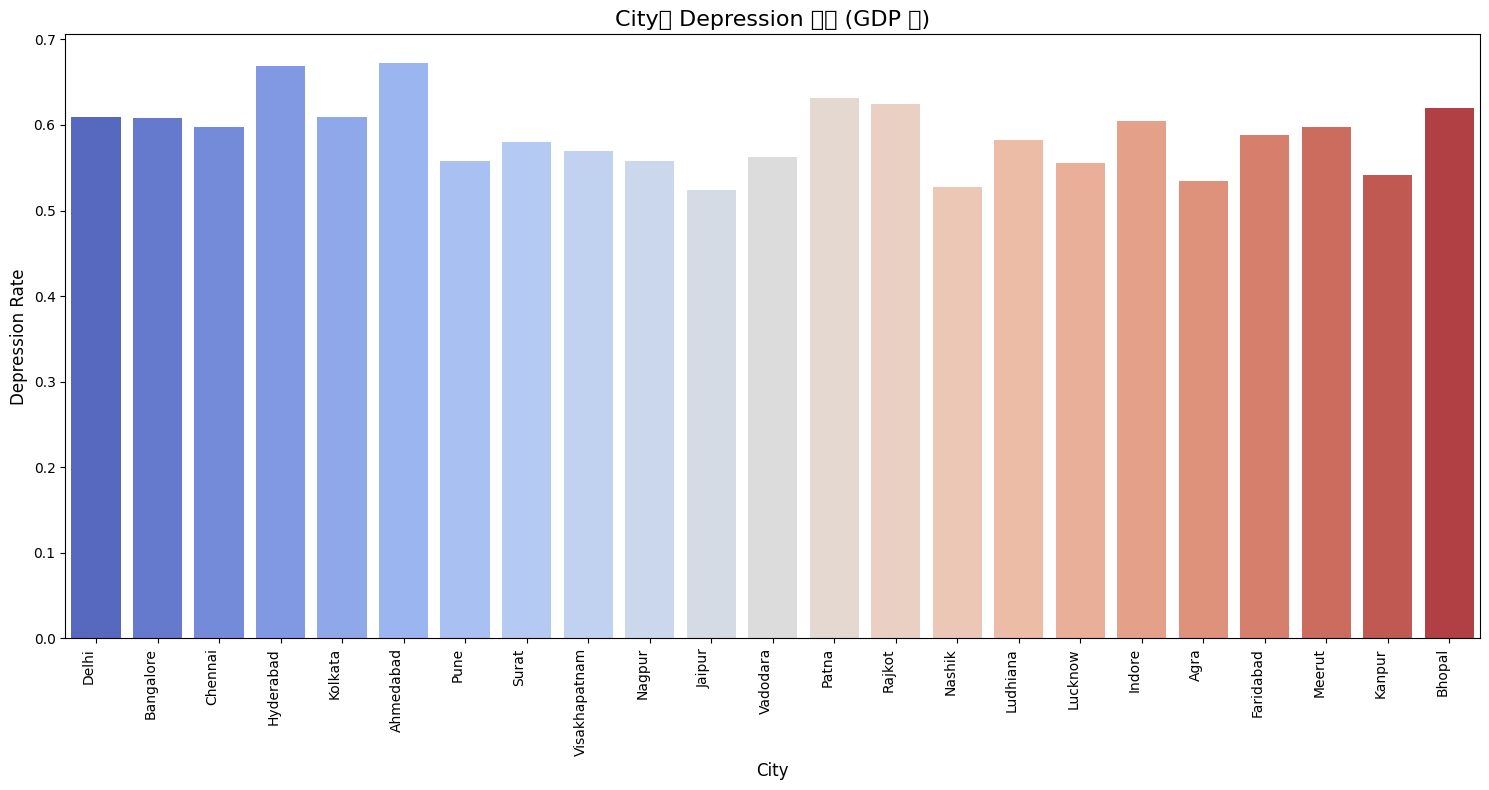

In [176]:
# prompt: df_train의 City별 Depression 비율을 도시 GDP순으로 시각화

# 도시별 우울증 비율 계산
# 각 도시별로 'Depression' 값이 1인 경우의 비율을 구합니다.
# value_counts(normalize=True)는 각 그룹 내 비율을 계산하며, unstack()[1]은 Depression=1인 비율만 선택합니다.
city_depression_rate = df_train.groupby('City')['Depression'].value_counts(normalize=True).unstack()[1]

# 도시별 평균 GDP 계산
# 각 도시별로 'GDP' 컬럼의 평균값을 구합니다.
# GDP는 도시마다 고유한 값이므로 mean()은 사실상 해당 도시의 GDP 값을 반환합니다.
city_gdp = df_train.groupby('City')['GDP'].mean()

# 두 시리즈를 하나의 데이터프레임으로 합칩니다.
# 'City'는 인덱스가 됩니다.
df_city_stats_gdp = pd.DataFrame({
    'Depression_Rate': city_depression_rate,
    'GDP': city_gdp
}).dropna() # GDP 정보가 없는 도시는 제외합니다.

# GDP(GDP)를 기준으로 내림차순으로 정렬합니다.
# 인구 순이 아닌 GDP 순으로 정렬합니다.
df_city_stats_sorted_by_gdp = df_city_stats_gdp.sort_values(by='GDP', ascending=False)

# 시각화 (Seaborn barplot)
plt.figure(figsize=(15, 8)) # 그래프 크기 설정
sns.barplot(x=df_city_stats_sorted_by_gdp.index, y=df_city_stats_sorted_by_gdp['Depression_Rate'], palette='coolwarm')
plt.title('City별 Depression 비율 (GDP 순)', fontsize=16) # 그래프 제목 변경
plt.xlabel('City', fontsize=12) # x축 라벨
plt.ylabel('Depression Rate', fontsize=12) # y축 라벨
plt.xticks(rotation=90, ha='right', fontsize=10) # x축 텍스트 90도 회전 및 정렬
plt.tight_layout() # 레이아웃 조정
plt.show() # 그래프 표시


도시별 Green Space, Population Density, Depression Rate 데이터:
           Depression_Rate  GreenSpace  PopulationDensity
City                                                     
Agra              0.534247       18.00            11300.0
Ahmedabad         0.672287        9.38            11975.0
Bangalore         0.608355        3.31             4381.0
Bhopal            0.619914       18.62             7154.0
Chennai           0.597285       18.05            26903.0


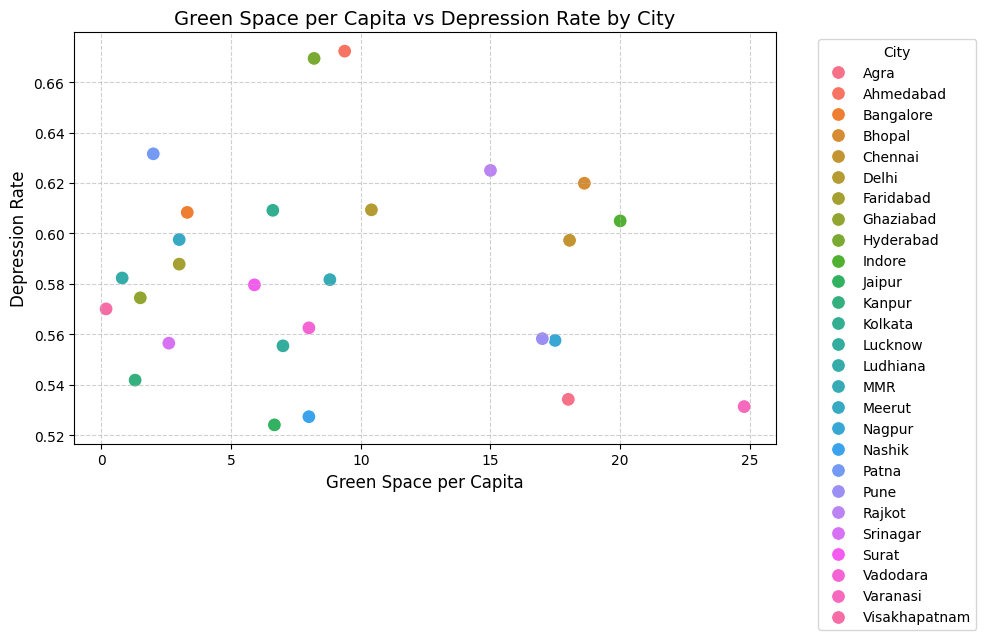

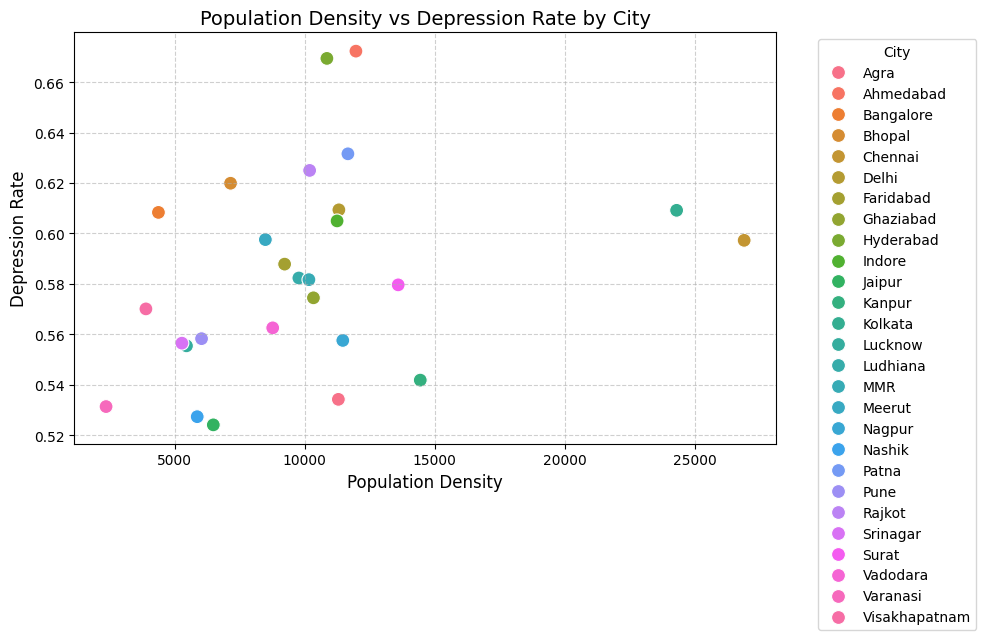

ValueError: Value of 'color' is not the name of a column in 'data_frame'. Expected one of ['Depression_Rate', 'GreenSpace', 'PopulationDensity'] but received: City

In [186]:
# prompt: 도시별 green_space_per_capita, population_density가 depression에 끼치는 영향을 시각화해줘

# 도시별 평균 green_space_per_capita 계산
city_greenspace = df_train.groupby('City')['GreenSpace'].mean()

# 도시별 평균 population_density 계산
city_population_density = df_train.groupby('City')['PopulationDensity'].mean()

# 도시별 우울증 비율 계산 (이전 코드에서 이미 계산됨)
# city_depression_rate = df_train.groupby('City')['Depression'].value_counts(normalize=True).unstack()[1]

# 세 시리즈를 하나의 데이터프레임으로 합칩니다.
df_city_environmental = pd.DataFrame({
    'Depression_Rate': city_depression_rate,
    'GreenSpace': city_greenspace,
    'PopulationDensity': city_population_density
}).dropna() # 결측치가 있는 도시는 제외합니다.

print("도시별 Green Space, Population Density, Depression Rate 데이터:")
print(df_city_environmental.head())

# 시각화 1: GreenSpace vs Depression Rate 산점도
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_city_environmental,
                x='GreenSpace',
                y='Depression_Rate',
                hue='City', # 도시별로 색상 구분
                s=100) # 점 크기 설정

plt.title('Green Space per Capita vs Depression Rate by City', fontsize=14)
plt.xlabel('Green Space per Capita', fontsize=12)
plt.ylabel('Depression Rate', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left') # 범례 위치 조정
plt.tight_layout()
plt.show()

# 시각화 2: Population Density vs Depression Rate 산점도
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_city_environmental,
                x='PopulationDensity',
                y='Depression_Rate',
                hue='City', # 도시별로 색상 구분
                s=100) # 점 크기 설정

plt.title('Population Density vs Depression Rate by City', fontsize=14)
plt.xlabel('Population Density', fontsize=12)
plt.ylabel('Depression Rate', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left') # 범례 위치 조정
plt.tight_layout()
plt.show()

# 시각화 3: 세 변수 간의 관계를 나타내는 3D 산점도 (Plotly 사용)
# Plotly는 대화형 시각화에 적합하며, 3D 그래프를 그릴 수 있습니다.
fig = px.scatter_3d(df_city_environmental,
                    x='GreenSpace',
                    y='PopulationDensity',
                    z='Depression_Rate',
                    color='City', # 도시별로 색상 구분
                    hover_name=df_city_environmental.index, # 마우스를 올렸을 때 도시 이름 표시
                    title='Green Space, Population Density, and Depression Rate by City')

fig.update_layout(scene = dict(
                    xaxis_title='Green Space per Capita',
                    yaxis_title='Population Density',
                    zaxis_title='Depression Rate'))
fig.show()

# 시각화 4: GreenSpace와 Population Density를 색상/크기로 인코딩한 2D 산점도
# (GreenSpace를 X축, PopulationDensity를 Y축, Depression Rate를 색상 또는 크기로 표현)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_city_environmental['GreenSpace'],
                      df_city_environmental['PopulationDensity'],
                      c=df_city_environmental['Depression_Rate'], # 우울증 비율을 색상으로
                      s=df_city_environmental['Depression_Rate'] * 500, # 우울증 비율에 비례하는 크기로 (스케일 조정 필요)
                      cmap='viridis', # 색상 맵 설정
                      alpha=0.7) # 투명도 설정

# 색상 막대 추가
cbar = plt.colorbar(scatter)
cbar.set_label('Depression Rate')

# 도시 이름 주석 추가 (선택 사항, 도시가 많으면 겹칠 수 있음)
# for i, city in enumerate(df_city_environmental.index):
#     plt.text(df_city_environmental['GreenSpace'].iloc[i],
#              df_city_environmental['PopulationDensity'].iloc[i],
#              city, fontsize=9, alpha=0.8)


plt.title('Green Space vs Population Density (Color/Size by Depression Rate)', fontsize=14)
plt.xlabel('Green Space per Capita', fontsize=12)
plt.ylabel('Population Density', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


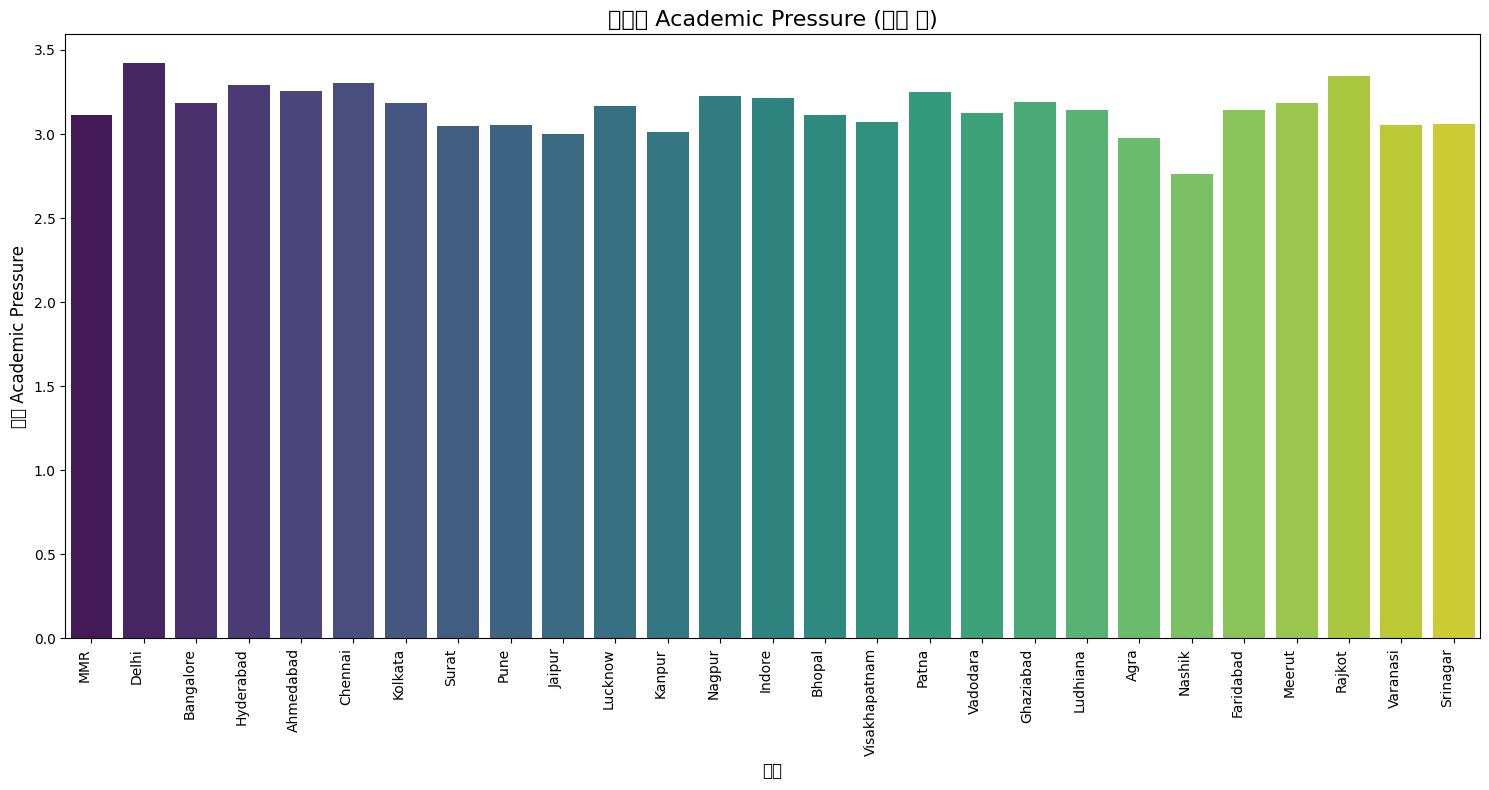

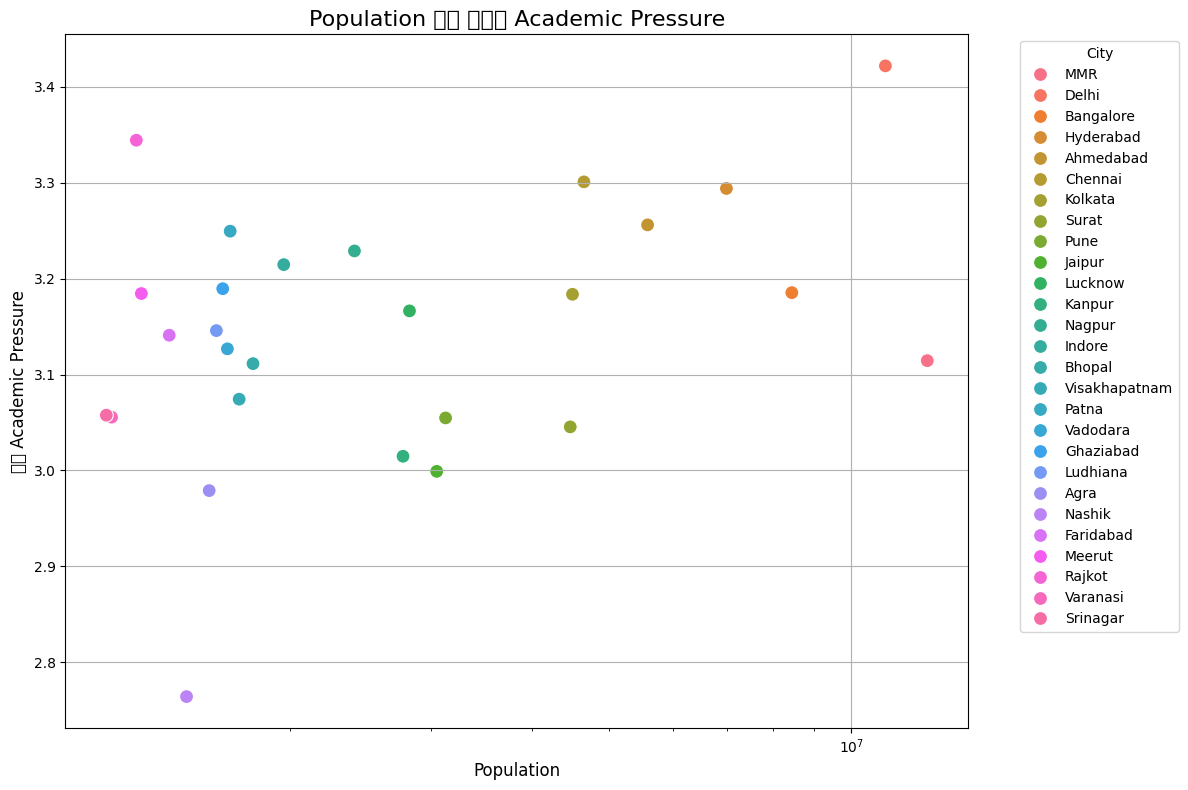

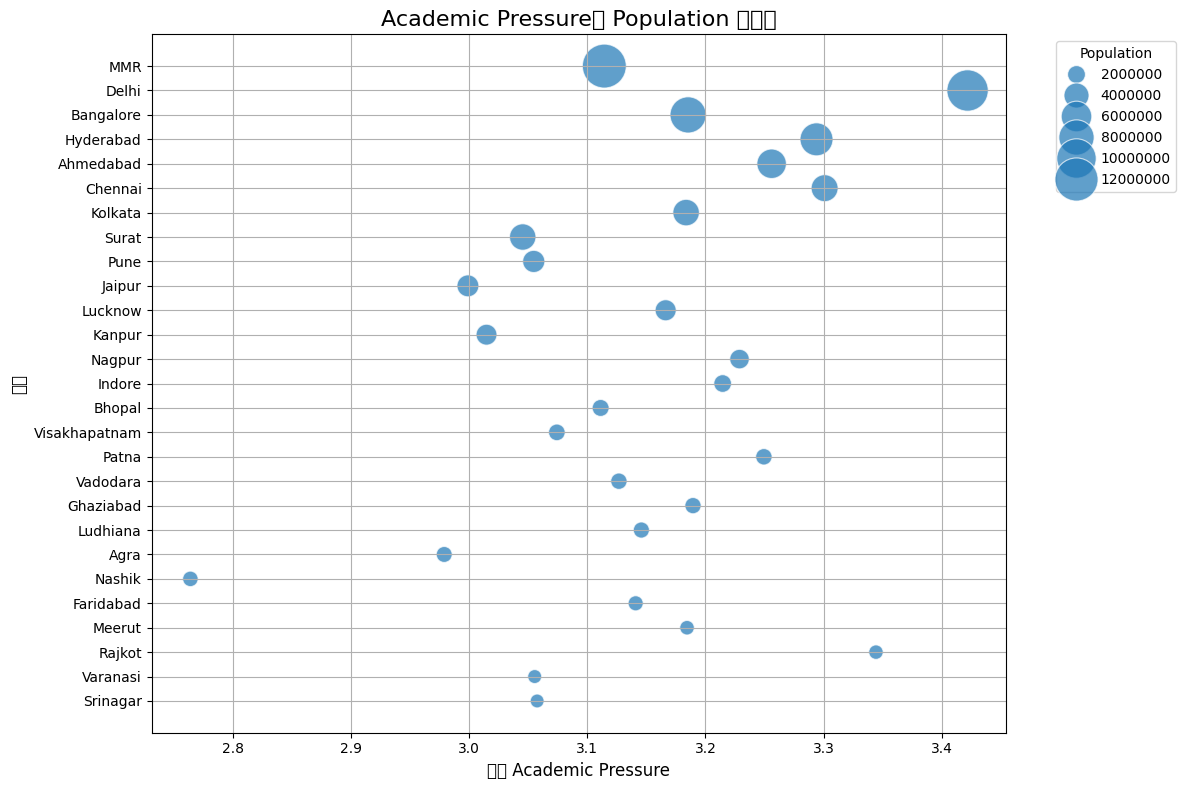

In [175]:
# prompt: 도시별 academic pressure를 population을 기준으로 시각화해줘

# Calculate the academic pressure for each student.
# Academic pressure can be inferred from Academic Pressure, Study Hours, Sleep Hours, and Extracurricular Activities.
# We'll create a composite score or use existing relevant columns.
# Based on the correlation heatmap, 'Academic Pressure' is the most direct indicator.
# 'Study Hours' might also be related, but 'Academic Pressure' is explicitly named.

# Group by City and calculate the average Academic Pressure.
city_academic_pressure = df_train.groupby('City')['Academic Pressure'].mean()

# Get the population for each city (assuming df_train already has the 'Population' column).
# We'll use the mean Population per city as each city should have a single population value after merging.
city_population = df_train.groupby('City')['Population'].mean()

# Combine the two series into a single DataFrame.
df_city_academic_pressure = pd.DataFrame({
    'Academic_Pressure': city_academic_pressure,
    'Population': city_population
}).dropna() # Drop cities where either Academic Pressure or Population data is missing.

# Sort the DataFrame by Population in descending order for visualization.
df_city_academic_pressure_sorted = df_city_academic_pressure.sort_values(by='Population', ascending=False)

# Visualize the academic pressure by city based on population.
# We can use a scatter plot or a bar plot. A bar plot might be easier to read for comparing cities.
# Alternatively, we can use a scatter plot with Population on the x-axis and Academic Pressure on the y-axis,
# with the size of the markers representing population.

# Option 1: Bar plot sorted by Population
plt.figure(figsize=(15, 8))
sns.barplot(x=df_city_academic_pressure_sorted.index, y=df_city_academic_pressure_sorted['Academic_Pressure'], palette='viridis')
plt.title('도시별 Academic Pressure (인구 순)', fontsize=16)
plt.xlabel('도시', fontsize=12)
plt.ylabel('평균 Academic Pressure', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

# Option 2: Scatter plot with Population on x-axis
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_city_academic_pressure_sorted, x='Population', y='Academic_Pressure', hue=df_city_academic_pressure_sorted.index, s=100) # 's' is marker size
plt.title('Population 기준 도시별 Academic Pressure', fontsize=16)
plt.xlabel('Population', fontsize=12)
plt.ylabel('평균 Academic Pressure', fontsize=12)
plt.xscale('log') # Use log scale for Population if there's a wide range
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Option 3: Scatter plot with size representing Population (more direct visual mapping)
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_city_academic_pressure_sorted, x='Academic_Pressure', y=df_city_academic_pressure_sorted.index, size='Population', sizes=(100, 1000), alpha=0.7, palette='viridis')
plt.title('Academic Pressure와 Population 시각화', fontsize=16)
plt.xlabel('평균 Academic Pressure', fontsize=12)
plt.ylabel('도시', fontsize=12)
plt.legend(title='Population', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Depression 컬럼이 마지막으로 배치된 df_train:
    Age           City Working Professional or Student Profession  \
0  33.0  Visakhapatnam                         Student        NaN   
1  24.0      Bangalore                         Student        NaN   
2  31.0       Srinagar                         Student        NaN   
3  28.0       Varanasi                         Student        NaN   
4  25.0         Jaipur                         Student        NaN   

   Academic Pressure  Study Satisfaction     Sleep Duration Dietary Habits  \
0                5.0                 2.0          5-6 hours        Healthy   
1                2.0                 5.0          5-6 hours       Moderate   
2                3.0                 5.0  Less than 5 hours        Healthy   
3                3.0                 2.0          7-8 hours       Moderate   
4                4.0                 3.0          5-6 hours       Moderate   

    Degree Have you ever had suicidal thoughts ?  Work/Study Hours  \
0  B.Pharm 

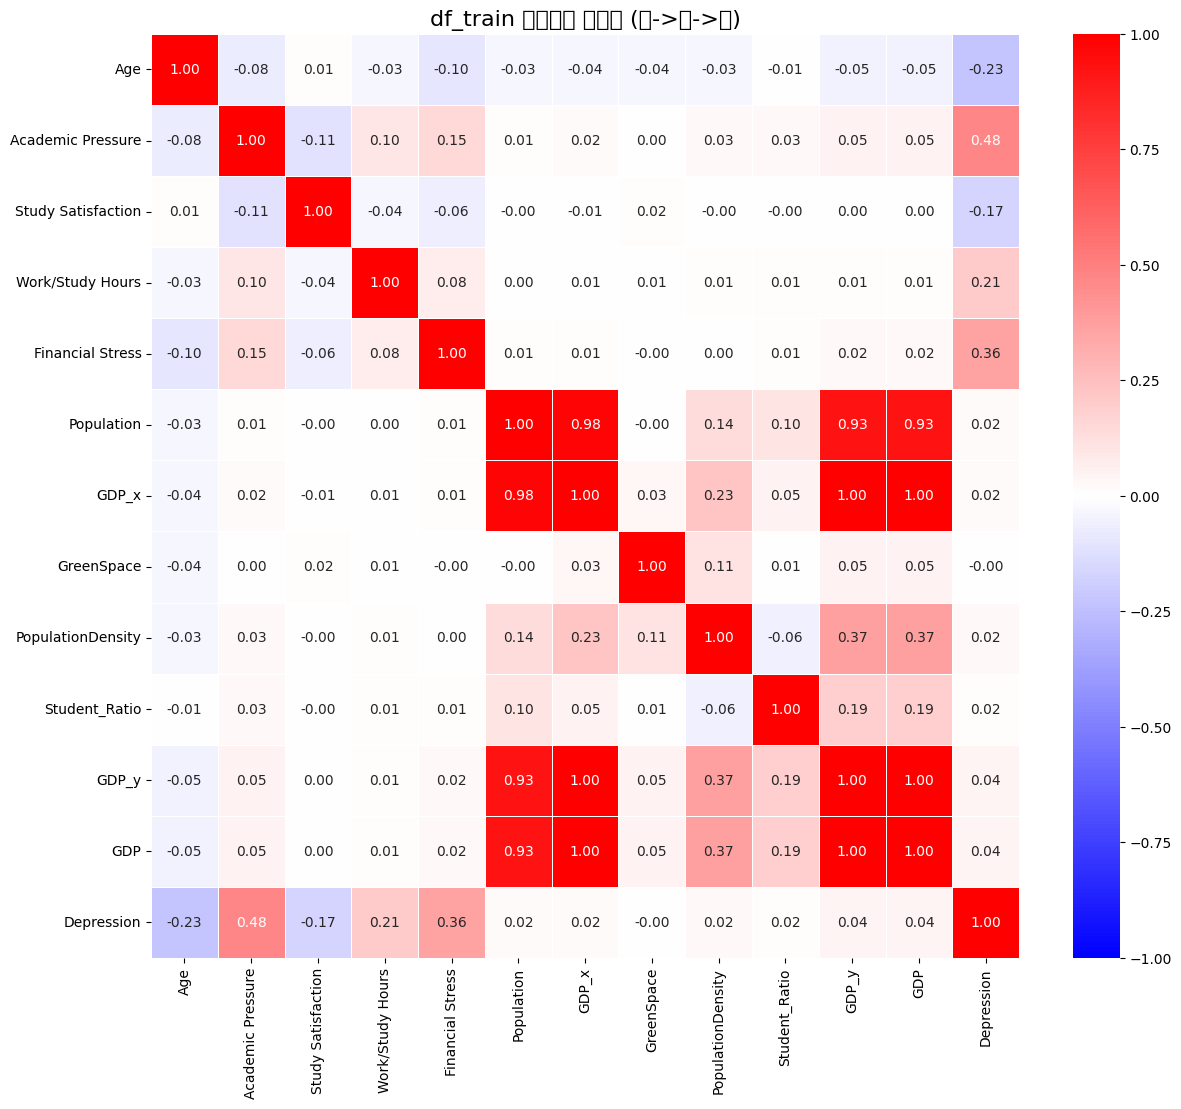

In [177]:
# prompt: depression 컬럼의 순서를 마지막으로 배치해줘. df_train의 상관관계 히트맵, 히트맵은 빨(1) -> 휜(0) -> 파(-1) 순

# "depression" 컬럼의 순서를 마지막으로 배치합니다.
# 현재 컬럼 목록을 가져옵니다.
cols = df_train.columns.tolist()

# "depression" 컬럼을 목록에서 제거합니다.
if 'Depression' in cols:
    cols.remove('Depression')

# 제거된 "depression" 컬럼을 목록의 마지막에 추가합니다.-
cols.append('Depression')

# 변경된 순서대로 데이터프레임의 컬럼을 재정렬합니다.
df_train = df_train[cols]

print("Depression 컬럼이 마지막으로 배치된 df_train:")
print(df_train.head())


# df_train의 수치형 피쳐 간의 상관 행렬 계산 (Depression이 마지막 컬럼)
correlation_matrix_students = df_train.corr(numeric_only=True)

# 빨(1) -> 휜(0) -> 파(-1) 순의 색상 팔레트 정의
# Matplotlib의 LinearSegmentedColormap을 사용하여 색상 맵을 만듭니다.
# 'colors'는 (위치, 색상) 튜플의 리스트로 구성됩니다. 위치는 0에서 1 사이의 값입니다.
cmap_custom = LinearSegmentedColormap.from_list(
    "red_white_blue", [(0, 'blue'), (0.5, 'white'), (1, 'red')], N=256
)

# 상관 행렬을 히트맵으로 시각화
plt.figure(figsize=(14, 12)) # 히트맵 크기 설정
sns.heatmap(correlation_matrix_students,
            annot=True,      # 각 셀에 상관계수 값 표시
            cmap=cmap_custom,  # 정의한 사용자 정의 색상 팔레트 적용
            fmt=".2f",       # 소수점 둘째 자리까지 표시
            linewidths=.5,   # 셀 경계선 두께 설정
            vmin=-1,         # 색상 맵의 최소값 (-1에 파란색 매핑)
            vmax=1)          # 색상 맵의 최대값 (1에 빨간색 매핑)

plt.title('df_train 상관관계 히트맵 (빨->흰->파)', fontsize=16) # 그래프 제목
plt.show() # 그래프 표시


# Task
Analyze the interaction effect of 'City' with 'Population', 'GDP', 'GreenSpace', and 'PopulationDensity' on 'Depression' using regression analysis, including data preparation, interaction term creation, model training, result interpretation, and optionally visualization.

## 데이터 준비

### Subtask:
분석에 필요한 컬럼('City', 'Population', 'GDP', 'GreenSpace', 'PopulationDensity', 'Depression')만 선택하고, 결측값을 처리합니다. City 컬럼은 범주형으로 처리해야 합니다.


**Reasoning**:
Select the necessary columns for the analysis and check for missing values.



In [178]:
# 1. Select necessary columns
df_analysis = df_train[['City', 'Population', 'GDP', 'GreenSpace', 'PopulationDensity', 'Depression']].copy()

# 2. Check for missing values per column
print("Missing values before handling:")
print(df_analysis.isnull().sum())

# 3. Handle missing values
# For numerical columns ('Population', 'GDP', 'GreenSpace', 'PopulationDensity'), we can impute with the mean.
for col in ['Population', 'GDP', 'GreenSpace', 'PopulationDensity']:
    if df_analysis[col].isnull().sum() > 0:
        mean_val = df_analysis[col].mean()
        df_analysis[col].fillna(mean_val, inplace=True)

# For 'City' (categorical), check if there are any missing values first.
# If there are, consider imputing with the mode or creating a new category.
if df_analysis['City'].isnull().sum() > 0:
    mode_val = df_analysis['City'].mode()[0]
    df_analysis['City'].fillna(mode_val, inplace=True)
    print(f"\nFilled missing City values with mode: {mode_val}")


print("\nMissing values after handling:")
print(df_analysis.isnull().sum())

# 4. Ensure 'City' is treated as a categorical variable
df_analysis['City'] = df_analysis['City'].astype('category')

# 5. Check data types and first few rows
print("\nData types after handling missing values and converting City to category:")
print(df_analysis.dtypes)

print("\nFirst 5 rows of the prepared DataFrame:")
display(df_analysis.head())

Missing values before handling:
City                    0
Population              0
GDP                  7501
GreenSpace              0
PopulationDensity       0
Depression              0
dtype: int64

Missing values after handling:
City                 0
Population           0
GDP                  0
GreenSpace           0
PopulationDensity    0
Depression           0
dtype: int64

Data types after handling missing values and converting City to category:
City                 category
Population            float64
GDP                   float64
GreenSpace            float64
PopulationDensity     float64
Depression              int64
dtype: object

First 5 rows of the prepared DataFrame:


,City,Population,GDP,GreenSpace,PopulationDensity,Depression
0,Visakhapatnam,1728128.0,21.860000,0.18,3900.0,1
1,Bangalore,8436675.0,118.130000,3.31,4381.0,0
2,Srinagar,1180570.0,39.619329,2.60,5283.0,0
3,Varanasi,1198491.0,39.619329,24.78,2367.0,1
4,Jaipur,3046163.0,19.870000,6.67,6491.0,0


## 교호항 생성

### Subtask:
City와 Population, GDP, GreenSpace, PopulationDensity 간의 교호항을 생성합니다. 이는 모델이 각 도시별로 수치형 변수의 영향이 다르게 나타나는지를 학습할 수 있도록 합니다.


**Reasoning**:
Create interaction terms between the one-hot encoded City columns and the numerical columns in df_analysis.



In [179]:
# 1. 분석에 필요한 컬럼('City', 'Population', 'GDP', 'GreenSpace', 'PopulationDensity', 'Depression')만 선택하고, 결측값을 처리합니다.
# 이전에 df_analysis를 수정했으므로, df_train에서 다시 시작합니다.
df_analysis = df_train[['City', 'Population', 'GDP', 'GreenSpace', 'PopulationDensity', 'Depression']].copy()

# 2. 결측값 확인 및 처리 (이전 단계에서 이미 처리했지만, 혹시 모를 경우를 대비하여 다시 확인합니다)
# City 컬럼은 이미 범주형이고 결측치 처리가 완료되었는지 확인합니다.
# 수치형 컬럼의 결측치는 평균으로 채웁니다.
numerical_cols_for_analysis = ['Population', 'GDP', 'GreenSpace', 'PopulationDensity']
for col in numerical_cols_for_analysis:
    if df_analysis[col].isnull().sum() > 0:
        mean_val = df_analysis[col].mean()
        df_analysis[col].fillna(mean_val, inplace=True)

# 3. City 컬럼 원-핫 인코딩을 위해 'City' 컬럼만 선택합니다.
# drop_first=True를 사용하여 다중공선성 문제를 방지합니다.
df_cities_one_hot = pd.get_dummies(df_analysis['City'], prefix='City', drop_first=True)

# 4. 수치형 변수 컬럼 목록을 다시 정의합니다.
numerical_cols = ['Population', 'GDP', 'GreenSpace', 'PopulationDensity']

# 5. 교호항을 저장할 새로운 데이터프레임을 생성합니다.
df_interaction_terms = pd.DataFrame(index=df_analysis.index)

# 6. 각 도시 더미 변수와 각 수치형 변수 간의 교호항을 생성합니다.
# df_cities_one_hot의 컬럼(도시 더미 변수)과 df_analysis의 수치형 컬럼을 사용합니다.
for city_col in df_cities_one_hot.columns:
    for num_col in numerical_cols:
        interaction_col_name = f'{city_col}_x_{num_col}'
        df_interaction_terms[interaction_col_name] = df_cities_one_hot[city_col] * df_analysis[num_col]

# 7. 원본 df_analysis 데이터프레임에 원-핫 인코딩된 도시 더미 변수와 생성된 교호항 컬럼들을 추가합니다.
# 원본 'City' 컬럼은 더 이상 필요 없으므로 제거합니다.
# concat 전에 컬럼들이 올바른지 다시 확인합니다.
df_analysis = pd.concat([df_analysis.drop('City', axis=1), df_cities_one_hot, df_interaction_terms], axis=1)

# 8. 변경사항 확인
print("교호항 생성이 완료된 df_analysis DataFrame의 첫 5행:")
display(df_analysis.head())

print("\ndf_analysis DataFrame의 컬럼 목록:")
print(df_analysis.columns.tolist())

교호항 생성이 완료된 df_analysis DataFrame의 첫 5행:


,Population,GDP,GreenSpace,PopulationDensity,Depression,City_Ahmedabad,City_Bangalore,City_Bhopal,City_Chennai,City_Delhi,...,City_Vadodara_x_GreenSpace,City_Vadodara_x_PopulationDensity,City_Varanasi_x_Population,City_Varanasi_x_GDP,City_Varanasi_x_GreenSpace,City_Varanasi_x_PopulationDensity,City_Visakhapatnam_x_Population,City_Visakhapatnam_x_GDP,City_Visakhapatnam_x_GreenSpace,City_Visakhapatnam_x_PopulationDensity
0,1728128.0,21.860000,0.18,3900.0,1,False,False,False,False,False,...,0.0,0.0,0.0,0.000000,0.00,0.0,1728128.0,21.86,0.18,3900.0
1,8436675.0,118.130000,3.31,4381.0,0,False,True,False,False,False,...,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.00,0.00,0.0
2,1180570.0,39.619329,2.60,5283.0,0,False,False,False,False,False,...,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.00,0.00,0.0
3,1198491.0,39.619329,24.78,2367.0,1,False,False,False,False,False,...,0.0,0.0,1198491.0,39.619329,24.78,2367.0,0.0,0.00,0.00,0.0
4,3046163.0,19.870000,6.67,6491.0,0,False,False,False,False,False,...,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.00,0.00,0.0



df_analysis DataFrame의 컬럼 목록:
['Population', 'GDP', 'GreenSpace', 'PopulationDensity', 'Depression', 'City_Ahmedabad', 'City_Bangalore', 'City_Bhopal', 'City_Chennai', 'City_Delhi', 'City_Faridabad', 'City_Ghaziabad', 'City_Hyderabad', 'City_Indore', 'City_Jaipur', 'City_Kanpur', 'City_Kolkata', 'City_Lucknow', 'City_Ludhiana', 'City_MMR', 'City_Meerut', 'City_Nagpur', 'City_Nashik', 'City_Patna', 'City_Pune', 'City_Rajkot', 'City_Srinagar', 'City_Surat', 'City_Vadodara', 'City_Varanasi', 'City_Visakhapatnam', 'City_Ahmedabad_x_Population', 'City_Ahmedabad_x_GDP', 'City_Ahmedabad_x_GreenSpace', 'City_Ahmedabad_x_PopulationDensity', 'City_Bangalore_x_Population', 'City_Bangalore_x_GDP', 'City_Bangalore_x_GreenSpace', 'City_Bangalore_x_PopulationDensity', 'City_Bhopal_x_Population', 'City_Bhopal_x_GDP', 'City_Bhopal_x_GreenSpace', 'City_Bhopal_x_PopulationDensity', 'City_Chennai_x_Population', 'City_Chennai_x_GDP', 'City_Chennai_x_GreenSpace', 'City_Chennai_x_PopulationDensity', 'City_D

## 모델 선택 및 학습

### Subtask:
교호항을 포함한 데이터를 사용하여 Depression(종속 변수)에 대한 로지스틱 회귀 모델을 학습합니다.

In [180]:
# from sklearn.model_selection import train_test_split # 데이터 분할은 이미 되어 있으므로 주석 처리
# from sklearn.linear_model import LogisticRegression # sklearn 모델 대신 statsmodels 사용
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # 성능 평가는 statsmodels summary를 통해 확인

import statsmodels.api as sm
import pandas as pd # pandas는 이미 임포트되었지만, 코드 블록의 독립성을 위해 다시 임포트
import numpy as np # numpy 추가

# 독립 변수 (X)와 종속 변수 (y) 분리 (이전 단계에서 생성된 X, y 사용)
# X = df_analysis.drop('Depression', axis=1)
# y = df_analysis['Depression']

# 데이터를 학습 세트와 테스트 세트로 분할 (이전 단계에서 이미 수행됨)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs, stratify=y)

print("statsmodels를 사용하여 로지스틱 회귀 모델 학습:")

# statsmodels는 상수항을 자동으로 추가하지 않으므로, 독립 변수(X_train)에 상수항을 명시적으로 추가해야 합니다.
X_train_sm = sm.add_constant(X_train)

# 모든 컬럼을 숫자형 (float)으로 변환하여 statsmodels 입력 요구사항 충족
# errors='coerce'를 사용하면 변환할 수 없는 값은 NaN으로 처리됩니다.
# 현재 데이터에서는 모든 컬럼이 숫자형 또는 True/False이므로 문제가 없을 것으로 예상됩니다.
X_train_sm = X_train_sm.astype(float)

# 로지스틱 회귀 모델 초기화 및 학습
# statsmodels에서는 종속 변수(y_train)와 독립 변수(X_train_sm)를 지정하여 모델을 정의합니다.
# family=sm.families.Binomial()는 이진 로지스틱 회귀를 지정합니다.
logit_model = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial())

# 학습 데이터로 모델 학습
# .fit() 메서드를 사용하여 모델을 학습시키고 결과를 얻습니다.
result = logit_model.fit()

print("\n로지스틱 회귀 모델 학습 완료 (statsmodels).")

# 모델 학습 결과 요약 출력 (p-value 포함)
# .summary() 메서드는 모델의 통계적 결과를 자세히 보여줍니다.
print("\n모델 학습 결과 요약:")
print(result.summary())

# 참고: statsmodels 모델 결과에서 교호작용 항 (Feature 이름에 '_x_' 포함)의 P>|z| 값을 확인하여 통계적 유의성을 판단할 수 있습니다.
# 일반적으로 p-value가 0.05보다 작으면 해당 항은 통계적으로 유의미하다고 간주합니다.

statsmodels를 사용하여 로지스틱 회귀 모델 학습:

로지스틱 회귀 모델 학습 완료 (statsmodels).

모델 학습 결과 요약:
                 Generalized Linear Model Regression Results                  
Dep. Variable:             Depression   No. Observations:                22303
Model:                            GLM   Df Residuals:                    22276
Model Family:                Binomial   Df Model:                           26
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15058.
Date:                Tue, 03 Jun 2025   Deviance:                       30116.
Time:                        07:14:23   Pearson chi2:                 2.23e+04
No. Iterations:                     4   Pseudo R-squ. (CS):           0.006602
Covariance Type:            nonrobust                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

## 결과 분석

### Subtask:
모델 결과를 해석하여 City와 각 수치형 변수 간의 교호작용이 통계적으로 유의미한지, 그리고 그 영향이 어떤 패턴으로 나타나는지 파악합니다.

In [181]:
# 이 셀은 sklearn 모델의 계수를 분석하는 코드였습니다.
# statsmodels를 사용하도록 변경했으므로, statsmodels 결과 요약(result.summary())에서
# 계수, 표준 오차, p-value 등을 직접 확인하는 것으로 대체합니다.
# 따라서 이 셀의 코드는 더 이상 필요하지 않지만, 히스토리를 위해 남겨둡니다.
# 만약 특정 교호작용 항의 p-value를 코드적으로 추출하고 싶다면 result.pvalues를 사용할 수 있습니다.

print("Statsmodels 모델 결과 요약에서 교호작용 항의 통계적 유의성을 확인하세요.")

# 예를 들어, 특정 교호작용 항의 p-value를 확인하는 코드 (선택 사항)
# try:
#     # result.pvalues는 각 계수에 대한 p-value를 포함하는 Series입니다.
#     # 교호작용 항 이름을 정확히 알아야 접근 가능합니다.
#     # 예시: 'City_Rajkot_x_Population' 교호작용 항의 p-value 확인
#     interaction_term_pvalue = result.pvalues.get('City_Rajkot_x_Population', 'Not Found')
#     print(f"\n'City_Rajkot_x_Population' 교호작용 항의 p-value: {interaction_term_pvalue}")
# except Exception as e:
#     print(f"Error retrieving p-value: {e}")

# 모든 교호작용 항의 p-value를 확인하고 싶다면:
print("\n모든 교호작용 항의 p-value:")
interaction_pvalues = result.pvalues[result.pvalues.index.str.contains('_x_')]
print(interaction_pvalues.sort_values(ascending=True)) # p-value가 작은 순서대로 정렬하여 유의미한 항 먼저 확인

# 통계적 유의성 기준 (예: 알파 수준 0.05)에 따라 유의미한 교호작용 항을 식별할 수 있습니다.
alpha = 0.05
significant_interactions = interaction_pvalues[interaction_pvalues < alpha]

print(f"\n통계적으로 유의미한 교호작용 항 (p-value < {alpha}):")
print(significant_interactions.sort_values(ascending=True)) # 유의미한 항들 출력

# 이 결과를 바탕으로 City와 수치형 변수 간의 어떤 상호작용이 통계적으로 유의미한지 해석할 수 있습니다.

Statsmodels 모델 결과 요약에서 교호작용 항의 통계적 유의성을 확인하세요.

모든 교호작용 항의 p-value:
City_Rajkot_x_PopulationDensity      0.000013
City_Rajkot_x_Population             0.000013
City_Rajkot_x_GreenSpace             0.000013
City_Rajkot_x_GDP                    0.000013
City_Meerut_x_PopulationDensity      0.000166
                                       ...   
City_Kolkata_x_GDP                   0.986633
City_Vadodara_x_PopulationDensity    0.996990
City_Vadodara_x_GDP                  0.996990
City_Vadodara_x_Population           0.996990
City_Vadodara_x_GreenSpace           0.996990
Length: 104, dtype: float64

통계적으로 유의미한 교호작용 항 (p-value < 0.05):
City_Rajkot_x_PopulationDensity      0.000013
City_Rajkot_x_Population             0.000013
City_Rajkot_x_GreenSpace             0.000013
City_Rajkot_x_GDP                    0.000013
City_Meerut_x_PopulationDensity      0.000166
City_Meerut_x_GreenSpace             0.000166
City_Meerut_x_Population             0.000166
City_Meerut_x_GDP                    0.

## 시각화 (선택 사항)

### Subtask:
주요 교호작용 효과를 시각화하여 결과를 더 쉽게 이해할 수 있도록 합니다.

기준 도시 'Ahmedabad_x_Population'를 시각화 목록에 추가합니다.


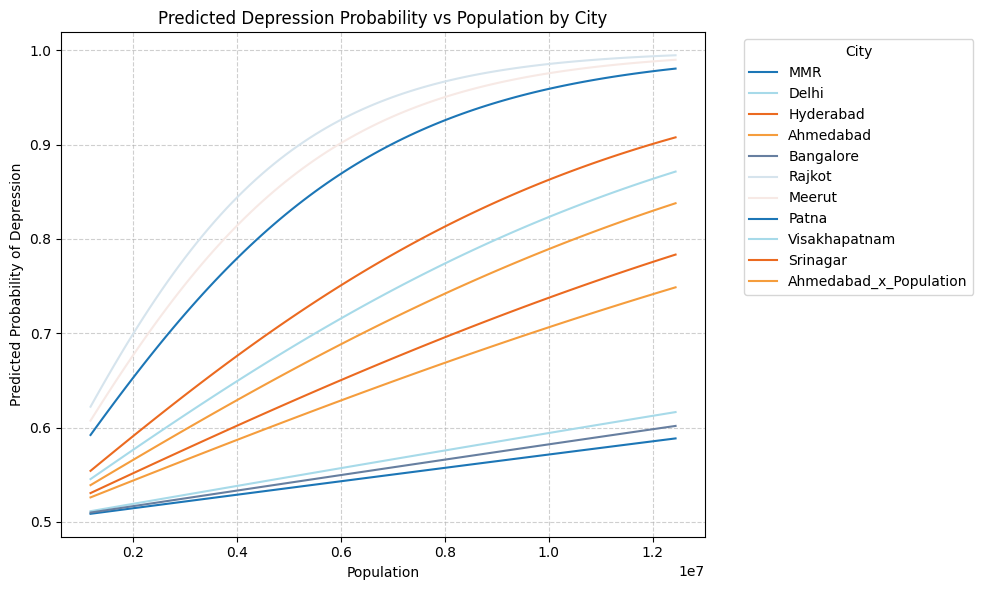

기준 도시 'Ahmedabad_x_Population'를 시각화 목록에 추가합니다.


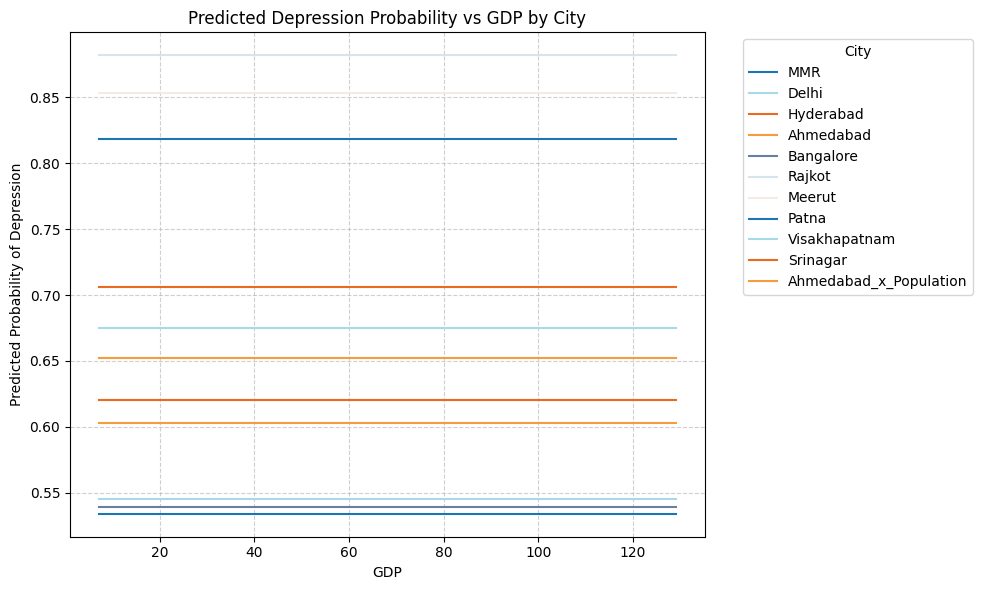

기준 도시 'Ahmedabad_x_Population'를 시각화 목록에 추가합니다.


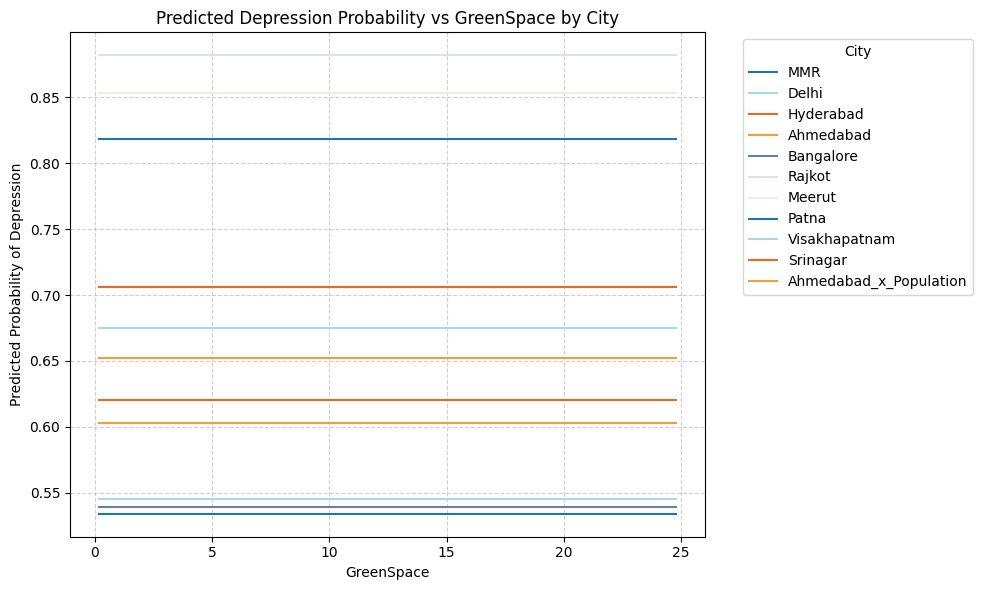

기준 도시 'Ahmedabad_x_Population'를 시각화 목록에 추가합니다.


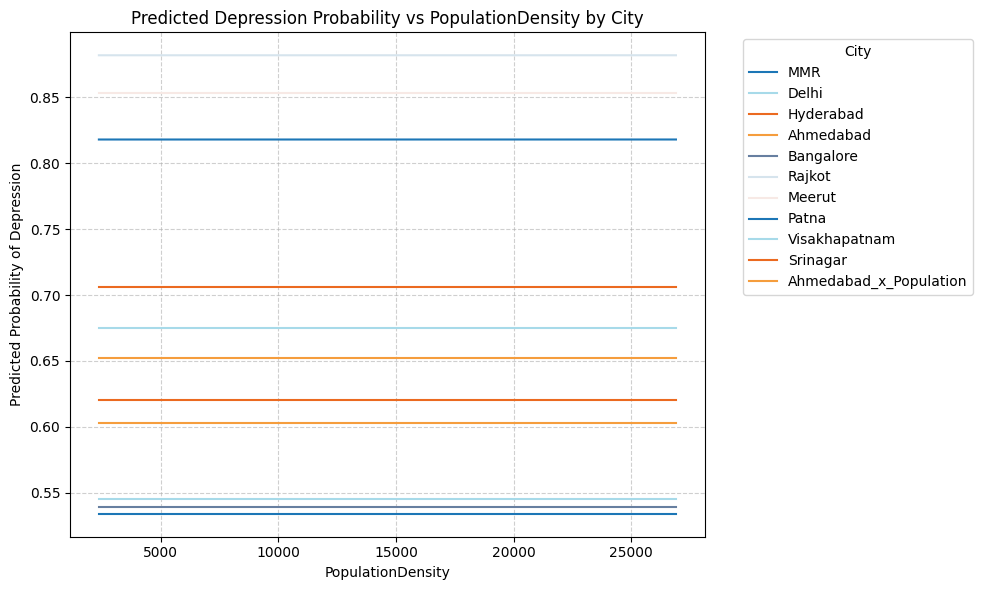

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 분석에 사용된 수치형 변수 목록
numerical_cols = ['Population', 'GDP', 'GreenSpace', 'PopulationDensity']

# 시각화할 대표적인 도시 선택 (예시로 몇 개 도시 선택)
# 모델 계수 분석 결과를 바탕으로 영향력이 큰 교호작용을 보인 도시나,
# 규모/특성이 다른 도시들을 선택하는 것이 좋습니다.
# 여기서는 예시로 상위 몇 개 도시와 MMR, 그리고 몇몇 다른 도시들을 선택합니다.
# 실제 분석 시에는 이전 계수 분석 결과를 참고하여 의미 있는 도시를 선택해야 합니다.

# df_cities_one_hot DataFrame의 컬럼에서 도시 목록을 가져옵니다.
# 'City_' 접두사를 제거하여 원래 도시 이름을 복원합니다.
all_cities_one_hot = df_cities_one_hot.columns.tolist()
all_cities = [col.replace('City_', '') for col in all_cities_one_hot]


# 시각화에 포함할 도시 목록 (예시)
# 모델 계수 분석에서 'City_Rajkot_x_Population', 'City_Meerut_x_Population',
# 'City_Patna_x_Population' 등의 교호작용 항 계수가 높았으므로 이 도시들을 포함합니다.
# 그 외에 인구 규모나 특성이 다른 도시들을 추가할 수 있습니다.
cities_to_visualize = ['MMR', 'Delhi', 'Hyderabad', 'Ahmedabad', 'Bangalore',
                       'Rajkot', 'Meerut', 'Patna', 'Visakhapatnam', 'Srinagar']

# 시각화할 데이터 생성
# 각 도시와 수치형 변수의 범위를 바탕으로 가상의 데이터 포인트를 생성하여 모델 예측값을 계산합니다.
# 각 수치형 변수에 대해, 해당 변수의 최소값부터 최대값까지 일정한 간격으로 값을 생성합니다.
# 다른 수치형 변수와 도시 더미 변수는 평균값 또는 기준값으로 고정합니다.

# 수치형 변수의 값 범위를 파악합니다.
# df_analysis는 이미 수치형 변수와 원-핫 인코딩된 도시, 교호항을 포함하고 있습니다.
# 따라서 수치형 변수는 원래 컬럼 이름으로 접근합니다.
df_analysis_numeric = df_analysis[numerical_cols]
min_vals = df_analysis_numeric.min()
max_vals = df_analysis_numeric.max()
mean_vals = df_analysis_numeric.mean()

# 예측을 위한 더미 데이터프레임 생성 함수
def create_predict_df(city, varying_var, num_points=100):
    # 모델 학습에 사용된 모든 변수명 목록을 가져옵니다.
    all_features = X.columns.tolist()

    # 예측 데이터프레임을 0으로 초기화합니다.
    predict_df = pd.DataFrame(0.0, index=range(num_points), columns=all_features)

    # 변화시킬 변수의 값 범위를 생성합니다.
    varying_values = np.linspace(min_vals[varying_var], max_vals[varying_var], num_points)
    predict_df[varying_var] = varying_values

    # 다른 수치형 변수는 평균값으로 채웁니다.
    for col in numerical_cols:
        if col != varying_var:
            predict_df[col] = mean_vals[col]

    # 해당 도시의 더미 변수를 1로 설정합니다.
    # One-hot encoded column name for the city (handle drop_first)
    # drop_first=True로 인해 기준 도시(예: 첫 번째 알파벳 순 도시)의 더미 변수는 없습니다.
    # 기준 도시의 경우 해당 더미 변수 컬럼을 1로 설정할 필요가 없습니다 (모든 더미 변수가 0인 상태).
    city_one_hot_col = f'City_{city}'
    if city_one_hot_col in all_features: # 기준 도시가 아닌 경우에만 실행
         predict_df[city_one_hot_col] = 1.0
    # 기준 도시인 경우 predict_df[city_one_hot_col]는 존재하지 않으며 0.0으로 유지됩니다.


    # 교호작용 항 값을 계산합니다.
    # 해당 도시의 더미 변수와 수치형 변수들의 곱입니다.
    for num_col in numerical_cols:
         interaction_col_name = f'{city_one_hot_col}_x_{num_col}'
         if interaction_col_name in all_features: # 해당 교호작용 항 컬럼이 모델에 사용된 경우에만 계산
             # 해당 도시 더미 변수 값이 1인 경우에만 수치형 변수 값을 곱합니다.
             # 기준 도시의 경우 city_one_hot_col이 존재하지 않으므로 이 블록은 실행되지 않습니다.
             predict_df[interaction_col_name] = predict_df[city_one_hot_col] * predict_df[num_col]
         # 기준 도시의 교호작용 항 (예: City_Base_x_Population)은 모델에 없으므로 계산할 필요가 없습니다.


    return predict_df, varying_values


# 각 수치형 변수별로 시각화
for varying_var in numerical_cols:
    plt.figure(figsize=(10, 6))

    # 기준 도시 (drop_first로 제거된 도시)를 찾아 시각화 목록에 추가합니다.
    # X.columns에서 'City_'로 시작하지만 df_cities_one_hot.columns에는 없는 컬럼이 기준 도시입니다.
    base_city_one_hot_col = None
    for col in X.columns:
        if col.startswith('City_') and col not in df_cities_one_hot.columns:
             base_city_one_hot_col = col
             break

    cities_to_visualize_with_base = cities_to_visualize.copy()
    if base_city_one_hot_col:
         base_city_name = base_city_one_hot_col.replace('City_', '')
         if base_city_name not in cities_to_visualize_with_base: # 중복 추가 방지
             cities_to_visualize_with_base.append(base_city_name)
             print(f"기준 도시 '{base_city_name}'를 시각화 목록에 추가합니다.")
    else:
        print("기준 도시를 찾을 수 없습니다.")


    for city in cities_to_visualize_with_base:
        # 특정 도시와 변화시킬 변수에 대한 예측 데이터프레임 생성
        predict_df, varying_values = create_predict_df(city, varying_var)

        # 모델 예측 확률 계산
        # predict_proba는 각 클래스에 대한 확률을 반환합니다. 우울증(클래스 1) 확률을 사용합니다.
        predicted_proba = model.predict_proba(predict_df)[:, 1]

        # 결과 시각화
        sns.lineplot(x=varying_values, y=predicted_proba, label=city)

    plt.title(f'Predicted Depression Probability vs {varying_var} by City')
    plt.xlabel(varying_var)
    plt.ylabel('Predicted Probability of Depression')
    plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

## 결과 분석 (Statsmodels P-value 활용)

### Subtask:
Statsmodels 모델 결과에서 교호작용 항의 p-value를 추출하고 통계적 유의성을 해석합니다.

In [183]:
# statsmodels 모델 결과(result 객체)에서 p-value 가져오기
# result.pvalues는 각 계수에 대한 p-value를 포함하는 Series입니다.
pvalues = result.pvalues

# 교호작용 항에 해당하는 p-value 필터링
# 교호작용 항의 이름은 일반적으로 '_x_' 문자열을 포함합니다.
interaction_pvalues = pvalues[pvalues.index.str.contains('_x_')].copy()

print("로지스틱 회귀 모델의 교호작용 항 p-value:")
display(interaction_pvalues.sort_values()) # p-value가 작은 순서대로 정렬하여 유의미한 항 먼저 확인

# 통계적 유의성 판단 기준 설정 (예: 알파 수준 0.05)
alpha = 0.05

# 통계적으로 유의미한 교호작용 항 식별
# p-value가 설정된 알파 값보다 작은 항들을 선택합니다.
significant_interactions = interaction_pvalues[interaction_pvalues < alpha].copy()

print(f"\n통계적으로 유의미한 교호작용 항 (p-value < {alpha}):")
display(significant_interactions.sort_values()) # 유의미한 항들 출력

# 해석:
# - '통계적으로 유의미한 교호작용 항' 목록에 나타난 항들은 해당 도시와 해당 수치형 변수 간의 상호작용이 우울증에 미치는 영향이 통계적으로 의미 있다고 해석할 수 있습니다.
# - 즉, 해당 수치형 변수가 우울증에 미치는 영향이 그 도시에 따라 다른 기준 도시에 비해 통계적으로 유의미하게 다르다는 것을 의미합니다.
# - p-value가 작을수록 해당 교호작용 항이 통계적으로 더 유의미합니다.
# - 유의미한 교호작용 항의 계수 값 (statsmodels summary에서 확인 가능)의 부호와 크기를 통해 상호작용의 구체적인 방향과 강도를 추가적으로 해석할 수 있습니다. (예: 양수 계수는 해당 도시에서 변수 증가 시 우울증 확률이 기준 도시보다 더 크게 증가함을 시사)

로지스틱 회귀 모델의 교호작용 항 p-value:


,0
City_Rajkot_x_PopulationDensity,0.000013
City_Rajkot_x_Population,0.000013
City_Rajkot_x_GreenSpace,0.000013
City_Rajkot_x_GDP,0.000013
City_Meerut_x_PopulationDensity,0.000166
...,...
City_Kolkata_x_GDP,0.986633
City_Vadodara_x_PopulationDensity,0.996990
City_Vadodara_x_GDP,0.996990
City_Vadodara_x_Population,0.996990



통계적으로 유의미한 교호작용 항 (p-value < 0.05):


,0
City_Rajkot_x_PopulationDensity,0.000013
City_Rajkot_x_Population,0.000013
City_Rajkot_x_GreenSpace,0.000013
City_Rajkot_x_GDP,0.000013
City_Meerut_x_PopulationDensity,0.000166
City_Meerut_x_GreenSpace,0.000166
City_Meerut_x_Population,0.000166
City_Meerut_x_GDP,0.000166
City_Patna_x_Population,0.000167
City_Patna_x_GreenSpace,0.000167


Missing values before interaction analysis handling:
City                  0
Academic Pressure    10
Student_Ratio         0
Depression            0
dtype: int64

Missing values after interaction analysis handling:
City                 0
Academic Pressure    0
Student_Ratio        0
Depression           0
dtype: int64

--- 교호작용 분석 결과 요약 (City * Academic Pressure, City * Student Ratio) ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:             Depression   No. Observations:                27879
Model:                            GLM   Df Residuals:                    27825
Model Family:                Binomial   Df Model:                           53
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15454.
Date:                Tue, 03 Jun 2025   Deviance:                       30909.
Time:                        07:14:54   Pearson chi2:  

,0
City_Surat_x_AcademicPressure,0.001664
City_Patna_x_AcademicPressure,0.003313
City_Visakhapatnam_x_AcademicPressure,0.009227
City_Ahmedabad_x_StudentRatio,0.009493
City_Kolkata_x_AcademicPressure,0.011040
City_Varanasi_x_StudentRatio,0.013187
City_Varanasi_x_AcademicPressure,0.016165
City_Ludhiana_x_AcademicPressure,0.017330
City_Surat_x_StudentRatio,0.029946
City_Indore_x_AcademicPressure,0.043601



시각화할 도시 (예시): ['Ahmedabad_x_AcademicPressure', 'Indore', 'Kolkata', 'Lucknow', 'Ludhiana', 'MMR']


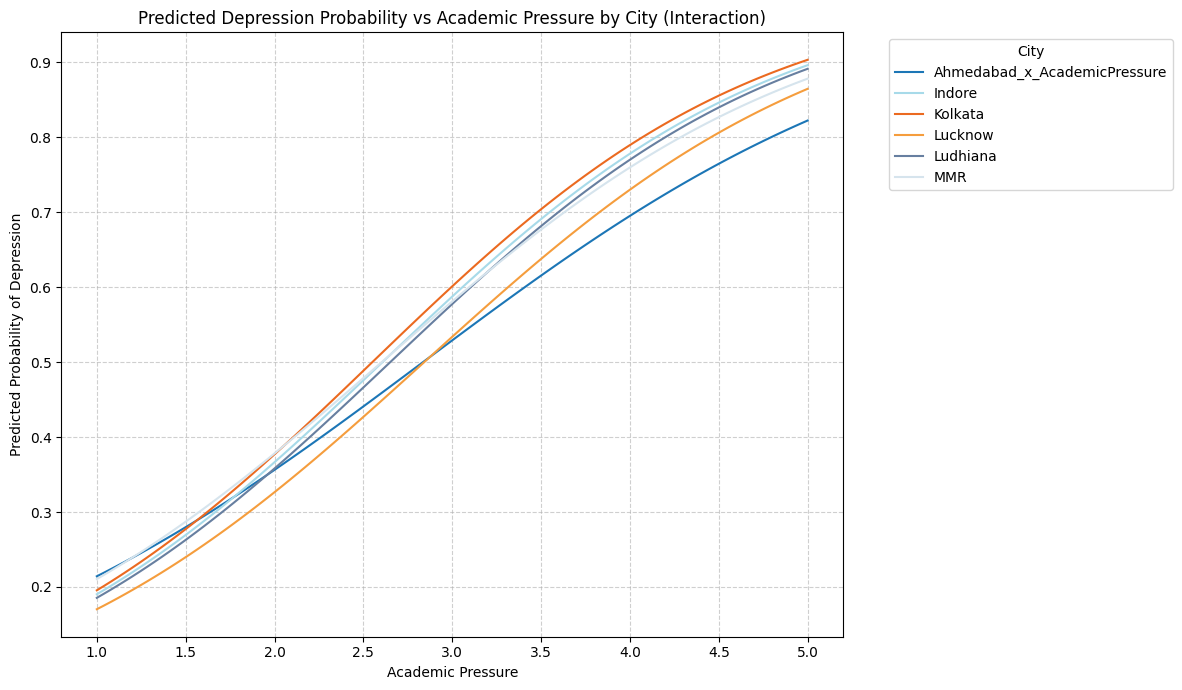

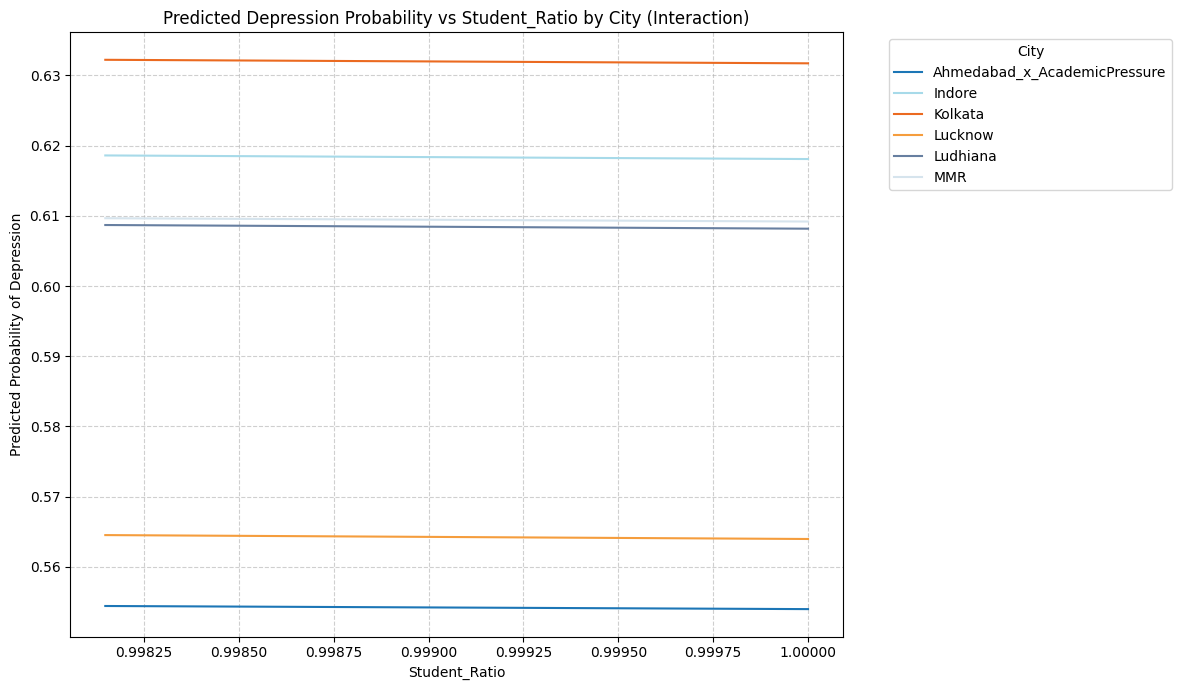

In [184]:
# prompt: 도시별 학생 수와 academic pressure의 교호작용으로 Depression에 미치는 영향을 알고 싶어

# ## 교호작용 분석
#
# ### Subtask:
# 도시별 학생 수('Student_Count' 또는 'Student_Ratio')와 학업 압박('Academic Pressure')이 Depression에 미치는 교호작용 효과를 분석합니다.
# 로지스틱 회귀 모델을 사용하며, 교호항을 포함하여 모델을 학습시키고 결과를 해석합니다.
#
# **Reasoning**:
# Investigate the interaction between city-specific student characteristics and academic pressure on depression using a logistic regression model with interaction terms.

import statsmodels.api as sm

# 분석에 필요한 컬럼 선택 (이전 단계에서 df_train에 필요한 컬럼들이 포함되어 있다고 가정)
# 'City', 'Academic Pressure', 'Depression', 'Student_Count' 또는 'Student_Ratio'를 사용합니다.
# 'Student_Ratio'가 비율이므로 분석에 더 적합할 수 있습니다.
# 만약 'Student_Ratio' 컬럼이 df_train에 없다면 이전 코드를 실행하여 생성해야 합니다.
# 여기서는 앞서 생성된 df_train에 'Student_Ratio'가 있다고 가정합니다.
# 만약 Student_Ratio가 없다면, city_stats['Student_Ratio'] 데이터를 df_train에 merge해야 합니다.

# 필요한 컬럼만 선택
# Student_Ratio 컬럼이 df_train에 없으므로, City별 Student_Ratio를 계산하여 merge합니다.
# 이전에 city_stats DataFrame에서 Student_Ratio를 계산했습니다.
# 해당 DataFrame을 df_train과 병합합니다.
# City별 Student_Ratio 계산 (이전 코드 블록 재사용)
city_total_counts = df_train['City'].value_counts().reset_index()
city_total_counts.columns = ['City', 'Total_Count']

student_counts = df_train[df_train['Working Professional or Student'] == 'Student']['City'].value_counts().reset_index()
student_counts.columns = ['City', 'Student_Count_Per_City'] # 컬럼 이름 변경하여 혼동 방지

city_stats_for_merge = pd.merge(city_total_counts, student_counts, on='City', how='left')
city_stats_for_merge['Student_Count_Per_City'] = city_stats_for_merge['Student_Count_Per_City'].fillna(0).astype(int)
city_stats_for_merge['Student_Ratio'] = city_stats_for_merge['Student_Count_Per_City'] / city_stats_for_merge['Total_Count']

# 필요한 컬럼만 선택하여 df_train에 병합
df_train = pd.merge(df_train.drop(['Student_Ratio', 'Total_Count', 'Student_Count_Per_City'], axis=1, errors='ignore'),
                    city_stats_for_merge[['City', 'Student_Ratio']],
                    on='City',
                    how='left')


# 분석에 필요한 컬럼만 포함하는 새로운 데이터프레임 생성
df_interaction_analysis = df_train[['City', 'Academic Pressure', 'Student_Ratio', 'Depression']].copy()

# 결측값 확인 및 처리
print("Missing values before interaction analysis handling:")
print(df_interaction_analysis.isnull().sum())

# 수치형 컬럼 ('Academic Pressure', 'Student_Ratio') 결측치 처리 (평균)
numerical_cols_interaction = ['Academic Pressure', 'Student_Ratio']
for col in numerical_cols_interaction:
    if df_interaction_analysis[col].isnull().sum() > 0:
        mean_val = df_interaction_analysis[col].mean()
        df_interaction_analysis[col].fillna(mean_val, inplace=True)

# 'City' 컬럼 결측치 처리 (최빈값)
if df_interaction_analysis['City'].isnull().sum() > 0:
    mode_val = df_interaction_analysis['City'].mode()[0]
    df_interaction_analysis['City'].fillna(mode_val, inplace=True)
    print(f"\nFilled missing City values with mode for interaction analysis: {mode_val}")

print("\nMissing values after interaction analysis handling:")
print(df_interaction_analysis.isnull().sum())

# 'City' 컬럼을 범주형으로 변환
df_interaction_analysis['City'] = df_interaction_analysis['City'].astype('category')

# 원-핫 인코딩 (City 컬럼)
# drop_first=True를 사용하여 다중공선성 방지
df_cities_one_hot_interaction = pd.get_dummies(df_interaction_analysis['City'], prefix='City', drop_first=True)

# 독립 변수 (X)와 종속 변수 (y) 분리
# 독립 변수에는 Academic Pressure, Student Ratio, 원-핫 인코딩된 City, 그리고 교호항이 포함됩니다.
# 종속 변수는 Depression입니다.
X_interaction = df_interaction_analysis[['Academic Pressure', 'Student_Ratio']].copy()
y_interaction = df_interaction_analysis['Depression']

# 교호항 생성
# City 더미 변수와 Academic Pressure 간의 교호항
for city_col in df_cities_one_hot_interaction.columns:
    interaction_col_name = f'{city_col}_x_AcademicPressure'
    X_interaction[interaction_col_name] = df_cities_one_hot_interaction[city_col] * X_interaction['Academic Pressure']

# City 더미 변수와 Student Ratio 간의 교호항
for city_col in df_cities_one_hot_interaction.columns:
    interaction_col_name = f'{city_col}_x_StudentRatio'
    X_interaction[interaction_col_name] = df_cities_one_hot_interaction[city_col] * X_interaction['Student_Ratio']


# 독립 변수에 원-핫 인코딩된 도시 더미 변수 추가
X_interaction = pd.concat([X_interaction, df_cities_one_hot_interaction], axis=1)

# statsmodels 로지스틱 회귀 모델 학습
# statsmodels는 상수항을 자동으로 추가하지 않으므로, X_interaction에 상수항 추가
X_interaction_sm = sm.add_constant(X_interaction)

# 모든 컬럼을 숫자형으로 변환
X_interaction_sm = X_interaction_sm.astype(float)

# 모델 정의 및 학습
logit_model_interaction = sm.GLM(y_interaction, X_interaction_sm, family=sm.families.Binomial())
result_interaction = logit_model_interaction.fit()

print("\n--- 교호작용 분석 결과 요약 (City * Academic Pressure, City * Student Ratio) ---")
print(result_interaction.summary())
print("-" * 80)

# 결과 해석:
# result_interaction.summary() 표에서 각 변수 (Academic Pressure, Student_Ratio),
# 각 도시 더미 변수 (예: City_Hyderabad), 그리고 교호작용 항 (예: City_Hyderabad_x_AcademicPressure, City_Hyderabad_x_StudentRatio)의 계수, 표준 오차, z값, p-value 등을 확인합니다.

# 주요 해석 포인트:
# 1. 개별 효과: 'Academic Pressure' 및 'Student_Ratio' 자체의 p-value를 확인하여, 도시와 무관하게 전반적인 영향이 있는지 봅니다 (기준 도시와 비교). City 더미 변수의 p-value를 통해 각 도시가 기준 도시에 비해 독립적으로 우울증 발생 확률에 영향을 미치는지 봅니다.
# 2. 교호작용 효과: 'City_X_x_AcademicPressure' 또는 'City_X_x_StudentRatio' 형태의 교호작용 항의 p-value를 확인합니다.
#    - p-value가 0.05 (또는 설정된 유의 수준)보다 작으면, 해당 도시(X)에서 Academic Pressure 또는 Student Ratio가 우울증에 미치는 영향이 기준 도시와 통계적으로 유의미하게 다르다는 것을 의미합니다.
#    - 교호작용 항의 계수 부호와 크기는 그 차이의 방향과 강도를 나타냅니다. 예를 들어, 'City_Hyderabad_x_AcademicPressure'의 계수가 양수이고 유의미하다면, Hyderabad에서는 Academic Pressure 증가가 우울증 확률을 기준 도시보다 더 크게 증가시키는 경향이 있음을 시사합니다.

# 통계적으로 유의미한 교호작용 항 추출 (p-value < 0.05)
alpha = 0.05
interaction_pvalues_filtered = result_interaction.pvalues[result_interaction.pvalues.index.str.contains('_x_')].copy()
significant_interactions_analysis = interaction_pvalues_filtered[interaction_pvalues_filtered < alpha].copy()

print(f"\n통계적으로 유의미한 교호작용 항 (p-value < {alpha}):")
display(significant_interactions_analysis.sort_values())

# 해석 요약:
# - 위 목록에 나타난 교호작용 항들이 City, Student Ratio/Academic Pressure와 Depression 간의 주요 상호작용 효과입니다.
# - 예를 들어, 'City_Rajkot_x_StudentRatio'가 유의미하다면, Rajkot 도시의 학생 비율이 우울증에 미치는 영향은 다른 도시와 다릅니다.
# - 구체적인 영향의 방향과 크기는 result_interaction.summary()에서 해당 항의 계수를 확인해야 합니다.
# - 계수가 양수이면 해당 도시에서 Student Ratio/Academic Pressure 증가가 우울증 확률을 기준 도시보다 더 증가시키는 경향이 있고, 음수이면 반대입니다.

# 시각화 (선택 사항)
# 특정 유의미한 교호작용 효과를 시각화하여 이해를 돕습니다.
# 예를 들어, Student Ratio와 Depression 확률 간의 관계를 유의미한 교호작용을 보인 몇 개 도시별로 플롯할 수 있습니다.

# 시각화할 변수와 도시 선택 (유의미한 교호작용 결과 바탕으로 선택)
# 예시: Student Ratio와 Academic Pressure의 상호작용이 유의미한 도시들을 선택
# 시각화 목록에 기준 도시를 포함하는 것도 중요합니다.
cities_with_significant_interaction = significant_interactions_analysis.index.str.split('_x_').str[0].str.replace('City_', '').unique().tolist()

# 모델 학습에 사용된 기준 도시 확인
base_city_interaction = None
for col in X_interaction_sm.columns:
    if col.startswith('City_') and col not in df_cities_one_hot_interaction.columns:
        base_city_interaction = col.replace('City_', '')
        break

if base_city_interaction and base_city_interaction not in cities_with_significant_interaction:
    cities_to_plot_interaction = [base_city_interaction] + cities_with_significant_interaction[:5] # 기준 도시와 유의미한 도시 몇 개
else:
    cities_to_plot_interaction = cities_with_significant_interaction[:6] # 유의미한 도시 몇 개

print(f"\n시각화할 도시 (예시): {cities_to_plot_interaction}")

# Student Ratio와 Academic Pressure의 예측 확률 시각화
for varying_var in numerical_cols_interaction:
    plt.figure(figsize=(12, 7))

    for city in cities_to_plot_interaction:
        # 예측을 위한 가상 데이터 생성
        # vary_var: Academic Pressure 또는 Student Ratio
        # 다른 수치형 변수는 평균값으로 고정합니다.
        # 도시 더미 변수와 교호항은 해당 도시 및 변화하는 변수 값에 따라 설정됩니다.

        num_points = 100
        # 모델 학습에 사용된 모든 독립 변수 컬럼 가져오기
        all_interaction_features = X_interaction_sm.columns.tolist() # 상수항 포함

        predict_df_int = pd.DataFrame(0.0, index=range(num_points), columns=all_interaction_features)

        # 상수항 설정
        predict_df_int['const'] = 1.0

        # 변화시킬 변수 값 생성
        varying_values_int = np.linspace(df_interaction_analysis[varying_var].min(), df_interaction_analysis[varying_var].max(), num_points)
        predict_df_int[varying_var] = varying_values_int

        # 다른 수치형 변수는 평균값으로 고정
        for col in numerical_cols_interaction:
            if col != varying_var:
                predict_df_int[col] = df_interaction_analysis[col].mean()


        # 해당 도시의 더미 변수 설정
        city_one_hot_col_int = f'City_{city}'
        if city_one_hot_col_int in all_interaction_features:
            predict_df_int[city_one_hot_col_int] = 1.0


        # 교호작용 항 값 계산
        # Academic Pressure와의 교호항
        interaction_ap_col_name = f'City_{city}_x_AcademicPressure'
        if interaction_ap_col_name in all_interaction_features:
             predict_df_int[interaction_ap_col_name] = predict_df_int[f'City_{city}'] * predict_df_int['Academic Pressure']

        # Student Ratio와의 교호항
        interaction_sr_col_name = f'City_{city}_x_StudentRatio'
        if interaction_sr_col_name in all_interaction_features:
             predict_df_int[interaction_sr_col_name] = predict_df_int[f'City_{city}'] * predict_df_int['Student_Ratio']

        # 모델 예측 확률 계산
        # statsmodels GLM 모델의 predict 메서드는 예측 확률을 직접 반환합니다.
        predicted_proba_int = result_interaction.predict(predict_df_int)

        # 결과 시각화
        sns.lineplot(x=varying_values_int, y=predicted_proba_int, label=city)

    plt.title(f'Predicted Depression Probability vs {varying_var} by City (Interaction)')
    plt.xlabel(varying_var)
    plt.ylabel('Predicted Probability of Depression')
    plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
